In [8]:
from CPlantBox_PiafMunch import * #import all the libraries

In [2]:
name = "small_2020.xml"
# name = "carbon2020_long_stem.xml"
plant = pb.Plant()

# # 2. A split pot experiment
# topBox = pb.SDF_PlantBox(22, 20, 5)
# #topBox = pb.SDF_RotateTranslate(topBox, pb.Vector3d(0, 0, 5))
# # sideBox = pb.SDF_PlantBox(12, 12, 35)
# # left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6.5, 0, -5))
# # right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6.5, 0, -5))
# sideBox = pb.SDF_PlantBox(10, 20, 35)
# left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
# right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
# box_ = []
# box_.append(topBox)
# box_.append(left)
# box_.append(right)
# splitBox = pb.SDF_Union(box_)


# # Set geometry: rotatedRhizotron, splitBox, or rhizoTube
# plant.setGeometry(splitBox)
#plant.write("splitBox.py")
plant.openXML("../../modelparameter/plant/" + name)
seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
plant.initialize(True)


carbon_logger = []
growth_rate_logger = []
exudation_logger = []
root_length_logger = []
all_length_logger = []
taproot_n_all = []
k1_logger = []
leaf_logger = []
dict_leaf_logger = []

column_name = ["time", 
               "id", 
               "organ_type", 
               "sub_type", 
               "connect_no", 
               "organ_id",
               "organ_id2",
               "parent_organ",
               "length", 
               "res_main", 
               "carbon_q",
               "c_satis",
               "root_water",
               "rw_satis",
               "c_demand_2" ,                          
               "growth_rate", 
               "exudation", 
               "order",
               "organ_length",
               "coor_x", 
               "coor_y", 
               "coor_z", 
               "connection_1", 
               "connection_2",
              ]
              
pd_output =  pd.DataFrame( [], columns= column_name )

extent = 5000
vml = 0.000143136 *extent
r_trsv = 100/extent
day_i = 0

vol_st = 2.6e-05 * extent 
vmu = 2.82627e95 *extent
r_phl_mb = 0.027157*5000 /extent

# xml_growth_rate = 

In [12]:
%%time
# growth rate percentage based on water potential: y = 20.790289211055025 + 83.59701538925951e* **(x*1.3957803144484557)
g_propotion = lambda water_potential : (20.79 + 83.597* 2.71828**(1.39578* (water_potential)) )/100
# absolute respiration maintenance of plant segment = volumen of the segment * 0.0032
# TODO to see if some other parameters from the output can be used as input
# carbon feedback loop by days.
for time in range(1, 60): # i*days to simulation
    pd_output_1day =  pd.DataFrame( [], columns= column_name )

    day_i = day_i +1
#     plant.setGeometry(splitBox)
    day = 1# the step of every loop (day)
    hour =24 # the hours of every loop (hour) used in PiafMunch
    plant.simulate(1 * day) # start simulation
    organ = plant.getOrgans()
    ana = pb.SegmentAnalyser(plant)
    ana.write("{}{}{}.vtp".format("test",str(name),day_i*day)) #writes vtp the name is followed by the number of days simulated
   
    # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
    dict_all  = convert( plant ) # convert plant to python outputs
    nodes_organtype = dict_all['nodes_organtype']
    nodes_coor = python_nodes(plant)
    segs = np.array([np.array(s) for s in plant.getSegments()])
    node_connection_o = segs
    pd_output_1day.loc[:,"id"] = list(map(int,dict_all["nodes_organtype"].T[0]))
    pd_output_1day.loc[:,"organ_type"] = list(map(int,dict_all["nodes_organtype"].T[1]))
    pd_output_1day.loc[:,"connect_no"] = list(map(int,dict_all["nodes_organtype"].T[2]))
    
    pd_output_1day.loc[:,"coor_x"] = list(nodes_coor.T[3])
    pd_output_1day.loc[:,"coor_y"] = list(nodes_coor.T[4])
    pd_output_1day.loc[:,"coor_z"] = list(nodes_coor.T[5])
    
    pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_1"] = list(map(int,dict_all["node_connection"].T[0]))
    pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_2"] = list(map(int,dict_all["node_connection"].T[1]))

    
    piafmunch_outputname = name +".ini" # set the name of the parameters
    Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
    organ_radius = [0]*((len(organ))) # initiate the radius of each segment
    k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
    kt = [0]*(len(dict_all['node_connection'])+1) # total carbon maintenance
    
    node_id_to_organ = [0]*plant.getNumberOfNodes() #
    node_id_to_subtype = [0]*plant.getNumberOfNodes() #
    node_id_to_organ2 = [0]*plant.getNumberOfNodes() #



    ########################################## python nodes conversion #########################################
    
    
    # sink nodes (nodes have one connection and on the right hand side)
    N1R_node = nodes_organtype[(nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # remove seed. get roots with one connection
    # source nodes
    N1L_node = nodes_organtype[ ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # remove seed. get stem or leaf with one connection
    leaf_logger.append(len(N1L_node)) 
    
    ########################## nodewise iteration to know which organ it belongs to ###########################################
    ########################## nodewise iteration to get maximal  ###########################################  
    
    # need more check 
    #
    for k in reversed(range(len(organ))):  # loop through all the organs
        organ_radius[k] = organ[k].getParam().a #the diameter of one organ
        j=0
        
        for j in range(1,organ[k].getNumberOfNodes()): # loop through all segments in one organs
            node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
            node_id_to_organ2[organ[k].getNodeId(j)]=organ[k].getId()
            node_id_to_subtype[organ[k].getNodeId(j)] = int(organ[k].getParameter("subType"))

            
            volumen = organ_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx
            phloem_per_section = 1#4200
            m_r = 0.0032 # Organ maintenance respiration rate (gCO2 g−1 DM)
            mass_per_volumen = 0.10 #root dry mass per unit volume (gDM cm−3) 0.05-0.14
            Carbon_main = volumen *0.0032*0.1/(24) *1000/12 # (1000/12) from grams/day/cm3 to mmol/hour/cm3 calculate the maintenance by volume (mmol)
            #Carbon_main = 1
            # print("maintenance is : ", Carbon_main) # absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main 
    k1_logger.append(np.sum(k1))
    taproot_length = [0] * (len(plant.getOrgans())-2)
    all_organ_length = [0] * (len(plant.getOrgans())-2)
    taproot_n = []
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
            taproot_n.append(root_n)
    taproot_n_all.append(taproot_n)
             ############################# water potential in left and right !root! ##################################################
    soil_wp = 0.8
    dry_soil = 0.8
    wet_soil = 0.8
#     here need more development 
    for i in range(1):
        for node_i,root_node in enumerate(N1R_node): # get all segments in one organs
            node_organ= node_id_to_organ [int(root_node[0])-1]
            organ_i = organ[ node_organ ] 
            print(node_i, organ_i.organType(), root_node,organ_i.param().subType, organ_i.getParent().getId() )
            if node_organ == taproot_n[0]:  # first taproot
                Soil_water[node_organ] = wet_soil
            elif node_organ == taproot_n[1]: 
                Soil_water[node_organ] = soil_wp
            elif node_organ == taproot_n[2]:  
                Soil_water[node_organ] = dry_soil

            elif organ_i.getParent().getId() == 1:
                Soil_water[node_organ] = wet_soil
            elif organ_i.getParent().getId() == 2:
                Soil_water[node_organ] = soil_wp
            elif organ_i.getParent().getId() == 3:
                Soil_water[node_organ] = dry_soil
            else:
                Soil_water[node_organ] = soil_wp
        

    organ_number_to_order = [0] *len(organ)
    for k in reversed(range(len(organ))):  # loop through all the organs
        if organ[k].getParent().organType() == 1:
            organ_number_to_order[k] = 1
        elif organ[k].getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 2
        elif organ[k].getParent().getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 3
        elif organ[k].getParent().getParent().getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 4
        elif organ[k].getParent().getParent().getParent().getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 5
        else:
            organ_number_to_order[k] = 6

    i=0
    for i in range(len(nodes_organtype)):
        oder_number = organ_number_to_order[node_id_to_organ[i]]
        pd_output_1day.loc[i,"order"] = oder_number 
        if oder_number == 1:
            pd_output_1day.loc[i,"parent_organ"] = 0
        else:
            pd_output_1day.loc[i,"parent_organ"] = organ[node_id_to_organ[i]].getParent().getId()
#         print("node_id_to_organ[i]", node_id_to_organ[i])
#         print("organ_number_to_order[node_id_to_organ[i]]", organ_number_to_order[node_id_to_organ[i]])        
        
        
    ############################# water potential in left and right !boxex! ##################################################
#     for i, roottip in enumerate(N1R_node): 
#         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
#             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
#         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
#             Soil_water[i] = 0.1 # actuall value is -0.5
#         else:
#             Soil_water[i] = 0.1 # actuall value is -0.1
    
    nodes_length = np.zeros(len(nodes_coor))
    for i in range(1,len(nodes_coor)):
        if nodes_coor[i][1]==2: #if the organtype is root
            nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]]  
                               + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )
        else:
            nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] 
                               + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                  + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                  + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )

    
    axial_r_xylem = []
    for i in range(0,(len(dict_all["node_connection"]))):
        second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1

        if plant.getOrgans()[node_id_to_organ[second_node]].getParent().getOrganRandomParameter().subType == 0:
            axial_r_xylem.append(
               k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[second_node]].getLength() - np.abs(nodes_length[second_node])*100))))
        else:
            axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) )

    axial_r_phloem = []
    for i in range(0,(len(dict_all["node_connection"]))):
        #     print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().subType)
        second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1
        phloem_radius = plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a
        resistance_propotional =0.04 *(0.2**4)/phloem_radius**4 # based on hagen poissuelle's law
        # print(plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a)
        axial_r_phloem.append(resistance_propotional)
        
        
    def devide_20(x):
        return x/4
    
    axial_r_xylem_0_25cm = map(devide_20, axial_r_xylem)
    ################################# coupling layer with piafmunch ###################################################
    homo_st = [0.04]*(len(dict_all["node_connection"]))
    # pass the absolute carbon maintentance to piafmunch
    write_PiafMunch_parameter(dict_all['node_connection'], 
                              dict_all['nodes_organtype'], 
                               axial_r_phloem, 
                              dict_all['unq_cnt'], 
                              Soil_water, 
                              k1, 
                              piafmunch_outputname,
                              hour, 
                              list(axial_r_xylem_0_25cm), 
                              vml, 
                              vol_st, 
                              vmu, 
                              r_phl_mb,
                              r_trsv)
    # call piafmunch and rename the output file of the PiafMunch
    os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
    now = datetime.datetime.now()
    os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_output.txt'.format(name, now.year ,now.month, now.day,name ) )
    
    ########################## convert carbon to growth rate ###########################################
    piaf_output = read_output(name,  dict_all["node_connection"])
    one_growth_log = [0] * (len(plant.getOrgans())+1)
    one_carbon_log = [0] * (len(plant.getOrgans())+1)
    one_exudation_log = [0] * (len(plant.getOrgans())+1)
    for node_i,root_node in enumerate(N1R_node): # CPlantBox growth rate: cm day-1
        # print(i)
        nodes_organ = organ[node_id_to_organ[int(root_node[0])-1]]
        pd_output_1day.loc[int(root_node[0])-1,"organ_length"] = nodes_organ.getLength()

        corss_area_root= nodes_organ.getParam().a**2*3.1415926 # this is also the carbon used for growth because mass need is 1 g DM cm−3
        # carbon_need = # mass need is 1 g DM cm−3
        # print("corss section area of root", corss_area_root)
        # carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 * 10 * volumen # directly pass the Q_ST * 1e5 to carbon content
        # num_of_phloem = 4200/0.12566370400000001
        carbon_available = piaf_output["Q_ST"][-1][int(root_node[0])-1]
        carbon_available_g_c = piaf_output["Q_ST"][-1][int(root_node[0])-1]* 12/1000 *24 #  # gram of carbon per day
        print(" " )
#         print("available carbon: ", carbon_available_g_c )
#         print(node_id_to_organ[int(root_node[0])-1])
        
#         print(nodes_organ.getOrganRandomParameter().r)
        
        rw_satis = g_propotion(0 - Soil_water[node_id_to_organ[int(root_node[0])-1]])
        #if exudation_logger == []:
        gr_water =  rw_satis * nodes_organ.getOrganRandomParameter().r
#         print("rw_satis", rw_satis)
#         print("growth rate by water", gr_water)
        # nodes_organ.getParam().r =   max([0, min([water_potential ,carbon_content])] )
        # r_carbon =  carbon_content/r_water
        gr_pot_2 = gr_water
        c_demand_2 = max(0.000001, corss_area_root *gr_pot_2  * 0.1 ) # 0.1 g DM cm−3 / day
#         print("water_satis", )
#         print("c_demand_2",c_demand_2)
        c_offer_2 = carbon_available_g_c
#         print("c_offer_2", c_offer_2)
        c_satis = c_offer_2 / c_demand_2
        
        gr_act = gr_pot_2 * max([0.000001, min([1,c_satis])])
#         print("GR_act", gr_act)
#         nodes_organ.getParam().r =   max([0, min([gr_water, carbon_content])])
        nodes_organ.getParam().r = gr_act
#         print("growth rate", nodes_organ.getParam().r)
        pd_output_1day.loc[int(root_node[0])-1, "growth_rate"] = gr_act
        pd_output_1day.loc[int(root_node[0])-1, "exudation"] = max([0 ,carbon_available_g_c - c_demand_2])  
        pd_output_1day.loc[int(root_node[0])-1, "root_water"] =  piaf_output["P_Xyl"][-1][int(root_node[0]-1)]
        pd_output_1day.loc[int(root_node[0])-1, "rw_satis"] = rw_satis
        pd_output_1day.loc[int(root_node[0])-1, "c_demand_2"] = c_demand_2
        pd_output_1day.loc[int(root_node[0])-1, "c_satis"] = c_satis
        
        
        one_carbon_log[node_id_to_organ[int(root_node[0])-1]] = carbon_available
        one_growth_log[node_id_to_organ[int(root_node[0])-1]] = gr_act
        one_exudation_log[node_id_to_organ[int(root_node[0])-1]] = max([0 ,carbon_available_g_c - c_demand_2])  
    ############################################length logger ###########################
    growth_rate_logger.append(one_growth_log)
    carbon_logger.append(one_carbon_log)
    exudation_logger.append(one_exudation_log)

    taproot_length = [0] * (len(plant.getOrgans())-2)
    all_organ_length = [0] * (len(plant.getOrgans())-2)
    
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
            taproot_length[root_n] = root.getLength()
            all_organ_length[root_n] =  root.getLength()
        elif root.organType() == 2 and root.getParent().organType()!=1: # not primary roots
            # print("lateral",root.getParent().organType() ,  root_n)
            # print(root.getParent().getId())
            taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
            all_organ_length[root_n] = root.getLength()
    root_length_logger.append(taproot_length)
    all_length_logger.append(all_organ_length)
    

    pd_output_1day.loc[:,"organ_id"] = list(map(int,node_id_to_organ))
    pd_output_1day.loc[:,"organ_id2"] = list(map(int,node_id_to_organ2))

    pd_output_1day.loc[:,"length"] = list(nodes_length)
    pd_output_1day.loc[:,"res_main"] = list(k1)
    pd_output_1day.loc[:,"carbon_q"] = piaf_output["Q_ST"][-1]
    pd_output_1day.loc[:,"time"] = day_i
    pd_output_1day.loc[:,"sub_type"] = list(node_id_to_subtype)
    pd_output_1day.loc[0,"sub_type"] = 1
    # pd_output_1day["growth_rate"] = piaf_output["Q_ST"][-1]
    #     f=np.sum
    pd_output = pd_output.append(pd_output_1day)
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[0][0]-1)], color = "red", label = "1st root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[1][0]-1)], color = "blue", label = "2nd root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[2][0]-1)], color = "green", label = "3rd root")
#     f.legend()
#     f.show()
#     print(piaf_output["Q_ST"][-1,int(N1R_node[0][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[1][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[2][0]-1)])
 # growthrate() CPlantBox growth rate: cm day-1
#total length two curve with total water potential

#change the soil water

pd_output.to_csv("newest.csv", index=False)

0 2 [9. 2. 1. 1.] 1 0
1 2 [17.  2.  1.  1.] 4 0
2 2 [25.  2.  1.  1.] 4 0
output successful
 
 
 
0 2 [38.  2.  1.  1.] 2 1
1 2 [42.  2.  1.  1.] 1 0
2 2 [45.  2.  1.  1.] 2 2
3 2 [49.  2.  1.  1.] 4 0
4 2 [52.  2.  1.  1.] 2 3
5 2 [56.  2.  1.  1.] 4 0
output successful
 
 
 
 
 
 
0 2 [65.  2.  1.  1.] 2 1
1 2 [68.  2.  1.  1.] 1 0
2 2 [70.  2.  1.  1.] 2 2
3 2 [73.  2.  1.  1.] 4 0
4 2 [75.  2.  1.  1.] 2 3
5 2 [78.  2.  1.  1.] 4 0
output successful
 
 
 
 
 
 
0 2 [85.  2.  1.  1.] 2 1
1 2 [88.  2.  1.  1.] 1 0
2 2 [90.  2.  1.  1.] 2 2
3 2 [93.  2.  1.  1.] 4 0
4 2 [95.  2.  1.  1.] 2 3
5 2 [98.  2.  1.  1.] 4 0
output successful
 
 
 
 
 
 
0 2 [105.   2.   1.   1.] 2 1
1 2 [109.   2.   1.   1.] 1 0
2 2 [111.   2.   1.   1.] 2 2
3 2 [115.   2.   1.   1.] 4 0
4 2 [117.   2.   1.   1.] 2 3
5 2 [121.   2.   1.   1.] 4 0
output successful
 
 
 
 
 
 
0 2 [125.   2.   1.   1.] 2 1
1 2 [128.   2.   1.   1.] 1 0
2 2 [129.   2.   1.   1.] 2 2
3 2 [132.   2.   1.   1.] 4 0
4 2 [133.   2.

output successful
 
 
 
 
 
 
 
 
 
 
 
 
0 2 [181.   2.   1.   1.] 2 1
1 2 [189.   2.   1.   1.] 2 2
2 2 [197.   2.   1.   1.] 2 3
3 2 [316.   2.   1.   1.] 2 1
4 2 [318.   2.   1.   1.] 2 1
5 2 [320.   2.   1.   1.] 2 2
6 2 [322.   2.   1.   1.] 2 2
7 2 [324.   2.   1.   1.] 2 3
8 2 [326.   2.   1.   1.] 2 3
9 2 [343.   2.   1.   1.] 1 0
10 2 [344.   2.   1.   1.] 4 0
11 2 [345.   2.   1.   1.] 4 0
output successful
 
 
 
 
 
 
 
 
 
 
 
 
0 2 [181.   2.   1.   1.] 2 1
1 2 [189.   2.   1.   1.] 2 2
2 2 [197.   2.   1.   1.] 2 3
3 2 [316.   2.   1.   1.] 2 1
4 2 [320.   2.   1.   1.] 2 2
5 2 [324.   2.   1.   1.] 2 3
6 2 [347.   2.   1.   1.] 2 1
7 2 [348.   2.   1.   1.] 1 0
8 2 [350.   2.   1.   1.] 2 2
9 2 [351.   2.   1.   1.] 4 0
10 2 [353.   2.   1.   1.] 2 3
11 2 [354.   2.   1.   1.] 4 0
output successful
 
 
 
 
 
 
 
 
 
 
 
 
0 2 [181.   2.   1.   1.] 2 1
1 2 [189.   2.   1.   1.] 2 2
2 2 [197.   2.   1.   1.] 2 3
3 2 [316.   2.   1.   1.] 2 1
4 2 [320.   2.   1.   1.] 2 2


output successful
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0 2 [316.   2.   1.   1.] 2 1
1 2 [320.   2.   1.   1.] 2 2
2 2 [324.   2.   1.   1.] 2 3
3 2 [347.   2.   1.   1.] 2 1
4 2 [350.   2.   1.   1.] 2 2
5 2 [353.   2.   1.   1.] 2 3
6 2 [361.   2.   1.   1.] 2 1
7 2 [364.   2.   1.   1.] 2 2
8 2 [367.   2.   1.   1.] 2 3
9 2 [430.   2.   1.   1.] 2 1
10 2 [432.   2.   1.   1.] 2 2
11 2 [434.   2.   1.   1.] 2 3
12 2 [436.   2.   1.   1.] 2 1
13 2 [438.   2.   1.   1.] 2 2
14 2 [440.   2.   1.   1.] 2 3
15 2 [445.   2.   1.   1.] 1 0
16 2 [446.   2.   1.   1.] 4 0
17 2 [447.   2.   1.   1.] 4 0
output successful
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0 2 [316.   2.   1.   1.] 2 1
1 2 [320.   2.   1.   1.] 2 2
2 2 [324.   2.   1.   1.] 2 3
3 2 [347.   2.   1.   1.] 2 1
4 2 [350.   2.   1.   1.] 2 2
5 2 [353.   2.   1.   1.] 2 3
6 2 [361.   2.   1.   1.] 2 1
7 2 [364.   2.   1.   1.] 2 2
8 2 [367.   2.   1.   1.] 2 3
9 2 [430.   2.   1.   1.] 2 1
10 2 [432.   2.   1.   1.] 2 2
11 2 [434.   

In [14]:
pd_output.to_csv("0.1_0.8_1.5water_long_lateral_1day.csv", index=False)

In [145]:
int(root_node[0]-1)

89

In [121]:
help(organ[0])

Help on Root in module plantbox object:

class Root(Organ)
 |  Method resolution order:
 |      Root
 |      Organ
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: plantbox.Root, arg0: plantbox.Organism, arg1: int, arg2: plantbox.Vector3d, arg3: float, arg4: plantbox.Organ, arg5: float, arg6: int) -> None
 |      
 |      2. __init__(self: plantbox.Root, arg0: int, arg1: plantbox.OrganSpecificParameter, arg2: bool, arg3: bool, arg4: float, arg5: float, arg6: plantbox.Vector3d, arg7: float, arg8: int, arg9: bool, arg10: int) -> None
 |  
 |  calcAge(...)
 |      calcAge(self: plantbox.Root, arg0: float) -> float
 |  
 |  calcCreationTime(...)
 |      calcCreationTime(self: plantbox.Root, arg0: float) -> float
 |  
 |  calcLength(...)
 |      calcLength(self: plantbox.Root, arg0: float) -> float
 |  
 |  dx(...)
 |      d

In [125]:
for node_i,root_node in enumerate(N1R_node): # get all segments in one organs
    node_organ = node_id_to_organ [int(root_node[0])-1]
    organ_i = organ[ node_organ ]
    print(node_organ, organ_i.getParent().getId())

1 1


AttributeError: 'NoneType' object has no attribute 'getId'

In [127]:
for i in range(1):
    for node_i,root_node in enumerate(N1R_node): # get all segments in one organs
        node_organ= node_id_to_organ [int(root_node[0])-1]
        organ_i = organ[ node_organ ] 
        print(node_i, organ_i.organType(), root_node,organ_i.param().subType，organ_i.getParent().getId() )
        if node_organ == taproot_n[0]:  # first taproot
            Soil_water[node_organ] = soil_wp
        elif node_organ == taproot_n[1]: 
            Soil_water[node_organ] = soil_wp
        elif node_organ == taproot_n[2]:  
            Soil_water[node_organ] = soil_wp 

        elif organ_i.getParent().getId() == 1:
            Soil_water[node_organ] = soil_wp
        elif organ_i.getParent().getId() == 2:
            Soil_water[node_organ] = soil_wp
        elif organ_i.getParent().getId() == 3:
            Soil_water[node_organ] = soil_wp
        else:
            Soil_water[node_organ] = soil_wp

0 2 [38.  2.  1.  1.] 2
1 2 [42.  2.  1.  1.] 1
2 2 [45.  2.  1.  1.] 2
3 2 [49.  2.  1.  1.] 4
4 2 [52.  2.  1.  1.] 2
5 2 [56.  2.  1.  1.] 4


In [63]:
Soil_water

[0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0.8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [28]:
for j,organ_i in enumerate(plant.getOrgans()): # get all segments in one organs
        print(j, organ_i.organType(), organ_i.param().subType)
#         print( )
        print(organ_i.getParent().getId() )

0 2 1
0
1 2 2
1
2 2 4
0
3 2 2
2
4 2 4
0
5 2 2
3
6 3 1
0
7 4 2
4


In [ ]:
with open("root_logger_37_days.txt", 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_NONE)
     wr.writerow(root_length_logger)

In [ ]:
with open('carbon_logger_37_days.txt') as csv_file:
    reader = csv.reader(csv_file)
    

In [46]:
pd_output = pd_output[column_name]
pd_output[pd_output["growth_rate"].notna()]

time   id organ_type sub_type connect_no organ_id    length  res_main  \
17     1   18          2        2          1        1  0.042024  0.000002   
47     1   48          2        1          1        0  0.083571  0.000035   
64     1   65          2        2          1        3  0.042024  0.000002   
94     1   95          2        4          1        2  0.083571  0.000035   
111    1  112          2        2          1        5  0.042024  0.000002   
141    1  142          2        4          1        4  0.083571  0.000035   

         carbon_q  growth_rate exudation order organ_length    coor_x  \
17  -1.996440e-07  1.40245e-06         0     2      3.20239  0.036591   
47   6.309240e-02      1.44597         0     1      8.35708  0.052146   
64  -1.996440e-07  1.40245e-06         0     2      3.20239 -0.030841   
94   6.309240e-02      1.44597         0     1      8.35708 -0.035592   
111 -1.996440e-07  1.40245e-06         0     2      3.20239  0.027870   
141  6.309240e-02      1.44597         0     1      8.35708  0.025774   

       coor_y    coor_z connection_1 connection_2  
17   0.001536 -0.026513           31           32  
47   0.046411 -0.058438            1           49  
64  -0.004640 -0.037289           78           79  
94   0.055898 -0.066517            1           96  
111 -0.022902 -0.024347          125          126  
141  0.009637 -0.092217          143            1

In [12]:
axial_r_xylem = []
for i in range(0,(len(dict_all["node_connection"]))):
    second_node = dict_all["node_connection"].T[1][i] -1
    
    if plant.getOrgans()[node_id_to_organ[second_node]].getParent().getOrganRandomParameter().subType == 0:
        axial_r_xylem.append(
           k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[second_node]].getLength() - np.abs(nodes_length[second_node])*100))))
    else:
        axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) )

In [ ]:
piaf_output["Q_ST"][-1]

In [ ]:
max(dict_all["node_connection"].T[1])

In [ ]:
for node_i,root_node in enumerate(N1R_node): # CPlantBox growth rate: cm day-1
        # print(i)
        nodes_organ = organ[node_id_to_organ[int(root_node[0])-1]]
        corss_area_root= nodes_organ.getParam().a**2*3.1415926 # this is also the carbon used for growth because mass need is 1 g DM cm−3
        # carbon_need = # mass need is 1 g DM cm−3
        # print("corss section area of root", corss_area_root)
        # carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 * 10 * volumen # directly pass the Q_ST * 1e5 to carbon content
        # num_of_phloem = 4200/0.12566370400000001
        carbon_available = piaf_output["Q_ST"][-1][int(root_node[0])-1]
        carbon_content = piaf_output["Q_ST"][-1][int(root_node[0])-1]* 12/1000 *24  /0.1/0.2 #*num_of_phloem
        print(" " )
        print("available carbon: ", carbon_available )
        print(node_id_to_organ[int(root_node[0])-1])
        
        print(nodes_organ.getOrganRandomParameter().r)
        
        rw_satis = g_propotion(0-Soil_water[node_i])
        #if exudation_logger == []:
        gr_water =  rw_satis * nodes_organ.getOrganRandomParameter().r
        print("rw_satis", rw_satis)
        print("growth rate by water", gr_water)
        # nodes_organ.getParam().r =   max([0, min([water_potential ,carbon_content])] )
        # r_carbon =  carbon_content/r_water
        gr_pot_2 = gr_water
        c_demand_2 = gr_pot_2 * corss_area_root *1
        print("water_satis", )
        print("c_demand_2",c_demand_2)
        c_offer_2 = carbon_available
        print("c_offer_2", c_offer_2)
        c_satis = c_offer_2 / c_demand_2
        
        gr_act = gr_pot_2 * min([1,c_satis])
        print("GR_act", gr_act)
        exudation = min([0, c_offer_2- c_demand_2])
#         nodes_organ.getParam().r =   max([0, min([gr_water, carbon_content])])
        nodes_organ.getParam().r = gr_act
        print("growth rate", nodes_organ.getParam().r)
        one_carbon_log[node_id_to_organ[int(root_node[0])-1]] = carbon_available
        one_growth_log[node_id_to_organ[int(root_node[0])-1]] = nodes_organ.getParam().r
        one_exudation_log[node_id_to_organ[int(root_node[0])-1]] = max([0 ,carbon_content - gr_water])  

In [158]:
pd_output.to_csv("0.1_0.8_1.5water_long_lateral_60.csv", index=False)

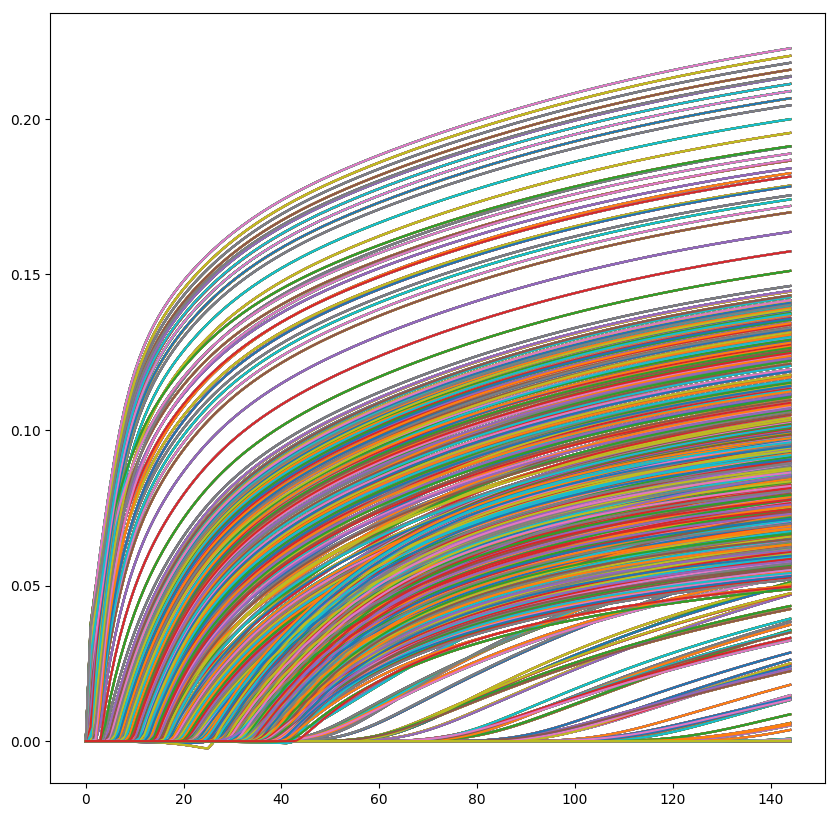

In [152]:
f=plt
for i in N1R_node:
    f.plot(piaf_output["Q_ST"])
#     print(piaf_output["Q_ST"][-1,int(i[0]-1)])
#     print(node_id_to_organ[int(i[0]-1)])

In [ ]:
all_output_pk =
{
    
"carbon_logger" : carbon_logger
"growth_rate_logger" = growth_rate_logger
"exudation_logger" = exudation_logger
"root_length_logger" = root_length_logger
"all_length_logger" = all_length_logger
"taproot_n_all" = taproot_n_all
"k1_logger" = k1_logger
"leaf_logger" = leaf_logger
"dict_leaf_logger" = dict_leaf_logger
    
}

In [84]:

import pickle
with open("hetero_carbon_logger.txt", "wb") as save:
    pickle.dump(carbon_logger, save)
    
with open("hetero_root_length_logger.txt", "wb") as save:
    pickle.dump(carbon_logger, save)

In [ ]:
with open("carbon_logger.txt", "rb") as load:
    root_he_c3 = pickle.load(load)

In [ ]:
help(pd)

In [ ]:
carbon_logger = root_he_c3  
rt_lengtooh_logger= root_he_l3

In [10]:
root_he_c3 = carbon_logger
root_he_l3 = root_length_logger

NameError: name 'carbon_logger' is not defined

In [11]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(15,10))
fig.suptitle("single plant with three basal root (each basal root in -0.1, -0.8, -1.5 water potential soil)")
a = 2
b = 3
def f2(x):
    return x #/12*1000  *0.1*0.2*0.12566370400000001
plt.style.use('default')
def f1(x):
    # return multiply *4200*24
    return x #*4200*24

root_1_l_cf = [] # root length 
root_1_c_cf = [] # available carbon
root_2_l_cf = []
root_2_c_cf = []
root_3_l_cf = []
root_3_c_cf = []


root_1_c_ec = [] # exudated carbon
root_2_c_ec = []
root_3_c_ec = []

root_1_c_gr = [] # growth rate
root_2_c_gr = []
root_3_c_gr = []

root_1_c_rr = [] #
root_2_c_rr = []
root_3_c_rr = []


growth_rate_logger 
exudation_logger 




for i, length_i in enumerate(root_he_l3):
    root_1_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_l_cf.append(length_i[np.array(root_he_l3[i]).nonzero()[0][2]])
    root_1_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_cf.append(root_he_c3[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
    root_1_c_gr.append(growth_rate_logger[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_gr.append(growth_rate_logger[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_gr.append(growth_rate_logger[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
    root_1_c_ec.append(exudation_logger[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_ec.append(exudation_logger[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_ec.append(exudation_logger[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
    root_1_c_rr.append(all_length_logger[i][np.array(root_he_l3[i]).nonzero()[0][0]])
    root_2_c_rr.append(all_length_logger[i][np.array(root_he_l3[i]).nonzero()[0][1]])
    root_3_c_rr.append(all_length_logger[i][np.array(root_he_l3[i]).nonzero()[0][2]])
    
ax1 = fig.add_subplot(a, b, 1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at three basal roots tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
days = range(1,len(root_he_c3 )+1)
ax1.plot(days,f1(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
ax1.plot(days,f1(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.8 MPa ", zorder=99)
ax1.plot(days,f1(np.array(root_3_c_cf)), marker = "o", linestyle="-", color = "red", label= "Water potential -1.5 MPa ", zorder=2)
for i, day in enumerate(carbon_logger):
    x = [i+1]*len(day)
    ax1.plot(x,f1(np.array(carbon_logger[i])), marker = "o", linestyle="", color = "lightgrey", zorder=1)
ax1.title.set_text("available carbon at each root tip")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()




ccc = np.squeeze(np.array(all_length_logger))
ax2 = fig.add_subplot(a, b, 2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
ax2.plot(days, root_2_l_cf, color= "yellow", marker = "o", label= "Water potential -0.8 MPa ")
ax2.plot(days, root_3_l_cf, color= "red", marker = "o", label= "Water potential -1.5 MPa")
for i, day in enumerate(all_length_logger):
    x = [i+1]*len(day)
    ax2.plot(x,day, marker = "o", linestyle="", color = "grey", zorder=1, markersize=1)
ax2.legend()

ax2.title.set_text("total root length on primary roots (include laterals)")
ax2.set_xlabel("time (days)")
ax2.set_ylabel("length (cm)")
ax2.set_ylim([0,60])
#ax2.set_xlim([0,120])
fig.savefig(fname= 'length2 ')





ax3 = fig.add_subplot(a, b, 3)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

ax3.plot(days, f1(np.array(k1_logger)), color= "red", marker = "o", label= "Total raspiration")
ax3.legend()
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.title.set_text("total respiration maintenance (mmol/hour ) ")
ax3.set_xlabel("time (days)")
ax3.set_ylabel("carbon mmol")
#ax3.set_ylim([0,60])
#ax3.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

total_exudation = []
for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax4 = fig.add_subplot(a, b, 4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

# for i, root_tip in enumerate(exudation_logger):
#     x = [i+1]*len(root_tip)
ax4.plot(days,total_exudation , marker = "o", linestyle="-", color = "black", zorder=1, markersize=10, label = "Total exudated carbon")
ax4.plot(days,np.array(root_1_c_ec), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
ax4.plot(days,np.array(root_2_c_ec), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.8 MPa ", zorder=99)
ax4.plot(days,np.array(root_3_c_ec), marker = "o", linestyle="-", color = "red", label= "Water potential -1.5 MPa ", zorder=2)

ax4.legend()
ax4.title.set_text("exudation")
ax4.set_xlabel("time (days)")
ax4.set_ylabel("exudated carbon mmol")
# ax4.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')


for i, root_tip in enumerate(exudation_logger):
    total_exudation.append(np.sum(root_tip))

ax5 = fig.add_subplot(a, b, 5)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

for i, root_tip in enumerate(growth_rate_logger):
    x = [i+1]*len(root_tip)
    ax5.plot(x,root_tip , marker = "o", linestyle="", color = "lightgrey", zorder=1, markersize=10)
ax5.legend()
ax5.title.set_text("growth rate")
ax5.set_xlabel("time (days)")
ax5.set_ylabel("growth rate cm/day")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])

ax5.plot(days,np.array(root_1_c_gr), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
ax5.plot(days,np.array(root_2_c_gr), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)
ax5.plot(days,np.array(root_3_c_gr), marker = "o", linestyle="-", color = "red", label= "Water potential -0.5 MPa ", zorder=2)


ax6 = fig.add_subplot(a, b, 6)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
# ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
# ax2.plot(days, root_2_l_cf, color= "red", marker = "o", label= "Water potential -0.3 MPa ")

ax6.plot(days,leaf_logger , marker = "o", linestyle="", color = "grey", zorder=1, markersize=10)
ax6.legend()
ax6.title.set_text("leaf number")
ax6.set_xlabel("days")
ax6.set_ylabel("leaf number")
# ax5.set_ylim([0,10])
#ax4.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

NameError: name 'growth_rate_logger' is not defined

<Figure size 1080x720 with 0 Axes>

In [12]:
Soil_water

NameError: name 'Soil_water' is not defined

In [21]:
# pd_output.to_csv("1.5water_new_rxyl.csv", index=False)
op_01 = pd.read_csv("1.5water_new_rxyl.csv")
# op_08 = pd.read_csv("all0.8.csv")


NameError: name 'days' is not defined

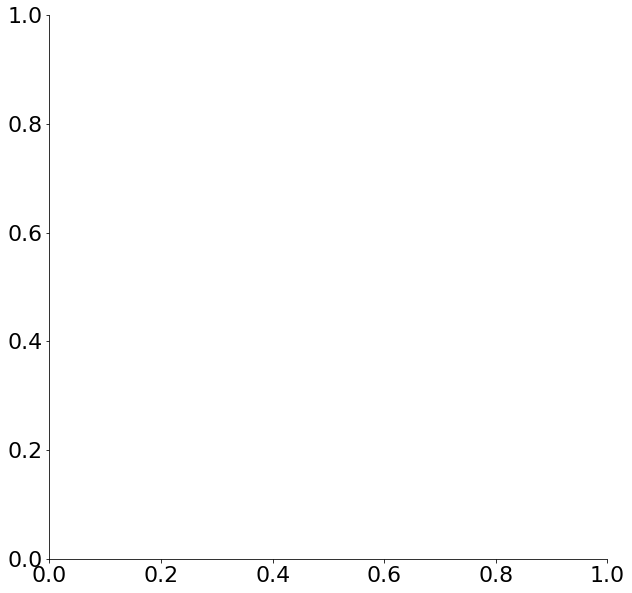

In [22]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot(1, 1, 1)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.plot(days, root_1_l_cf, color= "blue", marker = "o", label= "Water potential -0.1 MPa ")
ax2.plot(days, root_2_l_cf, color= "yellow", marker = "o", label= "Water potential -0.8 MPa ")
ax2.plot(days, root_3_l_cf, color= "red", marker = "o", label= "Water potential -1.5 MPa")
for i, day in enumerate(all_length_logger):
    x = [i+1]*len(day)
    ax2.plot(x,day, marker = "o", linestyle="", color = "grey", zorder=1, markersize=1)
ax2.legend()

ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
ax2.spines['bottom'].set_color('black')

ax2.spines['left'].set_color('black')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.title.set_text("total root length on primary roots (include laterals)")
ax2.set_xlabel("time (days)")
ax2.set_ylabel("length (cm)")
ax2.set_ylim([0,60])
#ax2.set_xlim([0,120])
fig.savefig(fname= 'length2 ')

In [22]:
# remove all non
def read_filter(file_name):
    op_01 = pd.read_csv(file_name)
    gr_column = ["time", "order", "growth_rate"]
    op_01_gr = op_01[op_01["growth_rate"].notna()]
    op_01_gr =  op_01_gr[gr_column]


    ca_column = ["time", "order", "carbon_q"]
    op_01_ca = op_01[op_01["growth_rate"].notna()]
    op_01_ca =  op_01_ca[ca_column]

    len_column = ["time", "order", "organ_length"]
    op_01_len = op_01[op_01["growth_rate"].notna()]
    op_01_len =  op_01_len[len_column]
    
    len_column = ["time", "order", "exudation"]
    op_01_ex = op_01[op_01["growth_rate"].notna()]
    op_01_ex =  op_01_ex[len_column]
    df = {"growth": op_01_gr, "carbon": op_01_ca, "length": op_01_len, "exudation":op_01_ex }
    return df
df01 = read_filter("0.8water_long_lateral.csv")
df08 = read_filter("0.8water_new_rxyl.csv")
df15 = read_filter("0.8water_long_lateral_no_carbon.csv")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


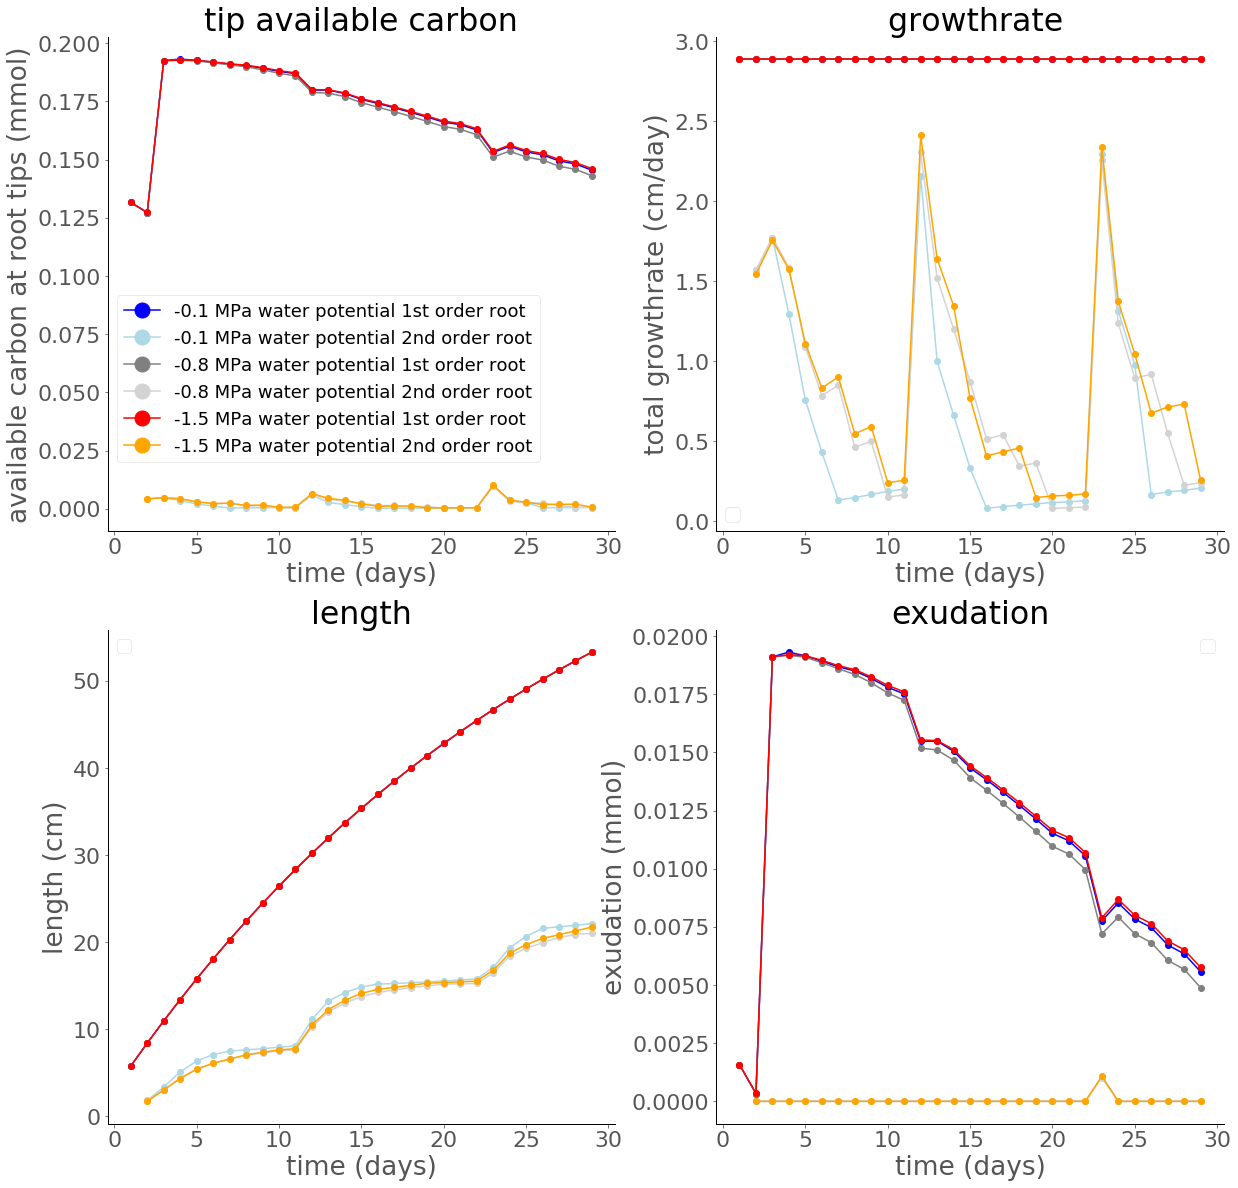

In [8]:

# remove all non


from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(20,20))


plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'lightblue', 'grey','lightgrey', 'red','orange'])))

a = 2
b = 2


ax1 = fig.add_subplot(a, b, 1)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("tip available carbon")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")

blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 1st order root')
lightblue_line = mlines.Line2D([], [], color='lightblue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 2nd order root')
grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 1st order root')
lightgrey_line = mlines.Line2D([], [], color='lightgrey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 2nd order root')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential 1st order root')
orange_line = mlines.Line2D([], [], color='orange', marker='o',
                          markersize=15, label='-1.5 MPa water potential 2nd order root')

plt.legend(loc='lower left', bbox_to_anchor=(0, 0.12, 0, 0), handles=[blue_line, lightblue_line, grey_line, lightgrey_line, red_line, orange_line])















ax1 = fig.add_subplot(a, b, 2)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("total growthrate (cm/day)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text(" growthrate")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.plot(df01["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.legend()










ax1 = fig.add_subplot(a, b, 3)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")

ax1 = fig.add_subplot(a, b, 4)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("exudation (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("exudation")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

fig_colum_name = "exudation"



ax1.plot(df01[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")


In [23]:
# remove all non
def read_filter(file_name):
    op_01 = pd.read_csv(file_name)
    gr_column = ["time", "order", "growth_rate"]
    op_01_gr = op_01[op_01["growth_rate"].notna()]
    op_01_gr =  op_01_gr[gr_column]


    ca_column = ["time", "order", "carbon_q"]
    op_01_ca = op_01[op_01["growth_rate"].notna()]
    op_01_ca =  op_01_ca[ca_column]

    len_column = ["time", "order", "organ_length"]
    op_01_len = op_01[op_01["growth_rate"].notna()]
    op_01_len =  op_01_len[len_column]
    
    len_column = ["time", "order", "exudation"]
    op_01_ex = op_01[op_01["growth_rate"].notna()]
    op_01_ex =  op_01_ex[len_column]
    df = {"growth": op_01_gr, "carbon": op_01_ca, "length": op_01_len, "exudation":op_01_ex }
    return df
# df01 = read_filter("0.1water_desktop.csv")
# df08 = read_filter("0.8water_desktop.csv")
# df15 = read_filter("1.5water_desktop.csv")
df01 = read_filter("0.1water_new_rxyl.csv")
df08 = read_filter("0.8water_new_rxyl.csv")
df15 = read_filter("1.5water_new_rxyl.csv")
df01 = read_filter("0.8water_long_lateral.csv")
df08 = read_filter("0.8water_new_rxyl.csv")
df15 = read_filter("0.8water_long_lateral_no_carbon.csv")

In [24]:
fig_colum_name ="length"
df01_l_order1 = df01[fig_colum_name][df01[fig_colum_name].order.eq(1)]
df08_l_order1 = df08[fig_colum_name][df08[fig_colum_name].order.eq(1)]
df15_l_order1 = df15[fig_colum_name][df15[fig_colum_name].order.eq(1)]

df01_l_order2 = df01[fig_colum_name][df01[fig_colum_name].order.eq(2)]
df08_l_order2 = df08[fig_colum_name][df08[fig_colum_name].order.eq(2)]
df15_l_order2 = df15[fig_colum_name][df15[fig_colum_name].order.eq(2)]

In [44]:
hetero_pd = pd.read_csv("0.1_0.8_1.5water_desktop.csv")

No handles with labels found to put in legend.


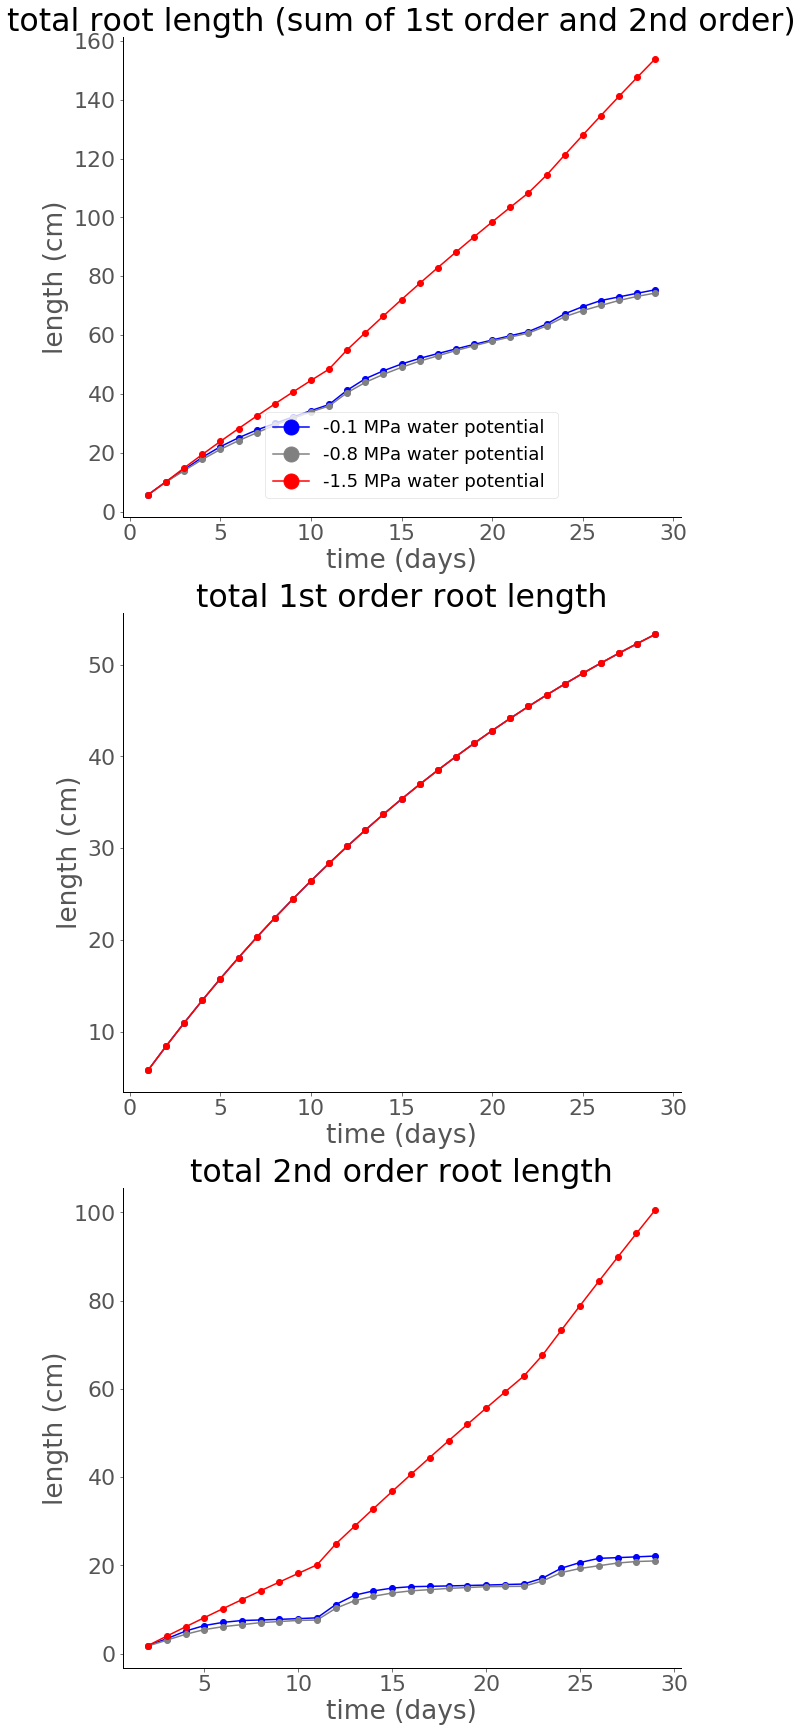

In [25]:


a = 3
b = 1

from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(10,30))
plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'grey', 'red'])))
ax1 = fig.add_subplot(a, b, 1)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("total root length (sum of 1st order and 2nd order)")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")


blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential ')

grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential ')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential')


plt.legend(loc='lower left', bbox_to_anchor=(0.24, 0.02, 0, 0), handles=[blue_line,  grey_line,  red_line, ])


ax1 = fig.add_subplot(a, b,2)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("total 1st order root length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
# ax1.legend()

ax1.plot(df01_l_order1[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08_l_order1[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15_l_order1[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")


ax1 = fig.add_subplot(a, b, 3)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("total 2nd order root length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
# ax1.legend()

ax1.plot(df01_l_order2[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08_l_order2[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15_l_order2[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")

In [15]:
# remove all non
def read_filter(file_name):
    op_01 = pd.read_csv(file_name)
    gr_column = ["time", "order", "growth_rate"]
    op_01_gr = op_01[op_01["growth_rate"].notna()]
    op_01_gr =  op_01_gr[gr_column]


    ca_column = ["time", "order", "carbon_q"]
    op_01_ca = op_01[op_01["growth_rate"].notna()]
    op_01_ca =  op_01_ca[ca_column]

    len_column = ["time", "order", "organ_length"]
    op_01_len = op_01[op_01["growth_rate"].notna()]
    op_01_len =  op_01_len[len_column]
    
    len_column = ["time", "order", "exudation"]
    op_01_ex = op_01[op_01["growth_rate"].notna()]
    op_01_ex =  op_01_ex[len_column]
    df = {"growth_rate": op_01_gr, "carbon": op_01_ca, "length": op_01_len, "exudation":op_01_ex }
    return df
# df01 = read_filter("0.1water_desktop.csv")
# df08 = read_filter("0.8water_desktop.csv")
# df15 = read_filter("1.5water_desktop.csv")

# df01 = read_filter("0.1water_new_rxyl.csv")
# df08 = read_filter("0.8water_new_rxyl.csv")
# df15 = read_filter("1.5water_new_rxyl.csv")


df01 = read_filter("0.8water_long_lateral.csv")
df08 = read_filter("0.8water_new_rxyl.csv")
df15 = read_filter("0.8water_desktop.csv")

In [26]:
fig_colum_name ="growth_rate"
df01_l_order1 = df01[fig_colum_name][df01[fig_colum_name].order.eq(1)]
df08_l_order1 = df08[fig_colum_name][df08[fig_colum_name].order.eq(1)]
df15_l_order1 = df15[fig_colum_name][df15[fig_colum_name].order.eq(1)]

df01_l_order2 = df01[fig_colum_name][df01[fig_colum_name].order.eq(2)]
df08_l_order2 = df08[fig_colum_name][df08[fig_colum_name].order.eq(2)]
df15_l_order2 = df15[fig_colum_name][df15[fig_colum_name].order.eq(2)]

a = 3
b = 1

from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(10,30))
plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'grey', 'red'])))
ax1 = fig.add_subplot(a, b, 1)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("growth rate (cm/day)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("root growth rate (sum of 1st order and 2nd order)")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01[fig_colum_name ][[fig_colum_name, 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08[fig_colum_name ][[fig_colum_name, 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15[fig_colum_name ][[fig_colum_name, 'time']].groupby(['time']).sum(),marker= "o")


blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential ')

grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential ')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential')


plt.legend(loc='lower left', bbox_to_anchor=(0.34, 0.72, 0, 0), handles=[blue_line,  grey_line,  red_line, ])


ax1 = fig.add_subplot(a, b,2)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("growth rate (cm/day)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("1st order root growth rate")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
# ax1.legend()

ax1.plot(df01_l_order1[[fig_colum_name, 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08_l_order1[[fig_colum_name, 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15_l_order1[[fig_colum_name, 'time']].groupby(['time']).sum(),marker= "o")


ax1 = fig.add_subplot(a, b, 3)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("growth rate (cm/day)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text(" 2nd order root growth rate")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
# ax1.legend()

ax1.plot(df01_l_order2[[fig_colum_name, 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08_l_order2[[fig_colum_name, 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15_l_order2[[fig_colum_name, 'time']].groupby(['time']).sum(),marker= "o")

KeyError: 'growth_rate'

In [ ]:
def read_filter(file_name):
    op_01 = pd.read_csv(file_name)
    gr_column = ["time", "order", "growth_rate"]
    op_01_gr = op_01[op_01["growth_rate"].notna()]
    op_01_gr =  op_01_gr[gr_column]


    ca_column = ["time", "order", "carbon_q"]
    op_01_ca = op_01[op_01["growth_rate"].notna()]
    op_01_ca =  op_01_ca[ca_column]

    len_column = ["time", "order", "organ_length"]
    op_01_len = op_01[op_01["growth_rate"].notna()]
    op_01_len =  op_01_len[len_column]
    
    len_column = ["time", "order", "exudation"]
    op_01_ex = op_01[op_01["growth_rate"].notna()]
    op_01_ex =  op_01_ex[len_column]
    df = {"growth": op_01_gr, "carbon": op_01_ca, "length": op_01_len, "exudation":op_01_ex }
    return df
df01 = read_filter("0.1_0.8_1.5water_long_lateral_60.csv")

No handles with labels found to put in legend.


AttributeError: 'dict' object has no attribute 'groupby'

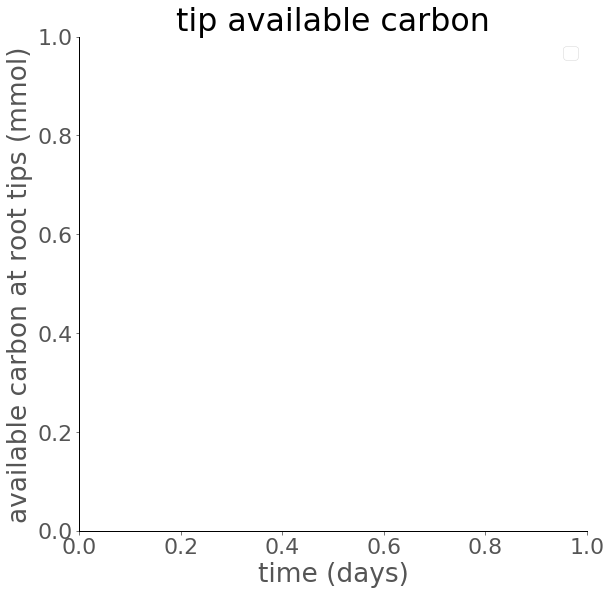

In [27]:

# remove all non


from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(20,20))


plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'lightblue', 'grey','lightgrey', 'red','orange'])))

a = 2
b = 2


ax1 = fig.add_subplot(a, b, 1)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("tip available carbon")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01.groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")

blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 1st order root')
lightblue_line = mlines.Line2D([], [], color='lightblue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 2nd order root')
grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 1st order root')
lightgrey_line = mlines.Line2D([], [], color='lightgrey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 2nd order root')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential 1st order root')
orange_line = mlines.Line2D([], [], color='orange', marker='o',
                          markersize=15, label='-1.5 MPa water potential 2nd order root')

plt.legend(loc='lower left', bbox_to_anchor=(0, 0.12, 0, 0), handles=[blue_line, lightblue_line, grey_line, lightgrey_line, red_line, orange_line])















ax1 = fig.add_subplot(a, b, 2)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("total growthrate (cm/day)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text(" growthrate")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.plot(df01["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["growth"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.legend()










ax1 = fig.add_subplot(a, b, 3)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")

ax1 = fig.add_subplot(a, b, 4)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("exudation (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("exudation")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

fig_colum_name = "exudation"



ax1.plot(df01[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")

No handles with labels found to put in legend.


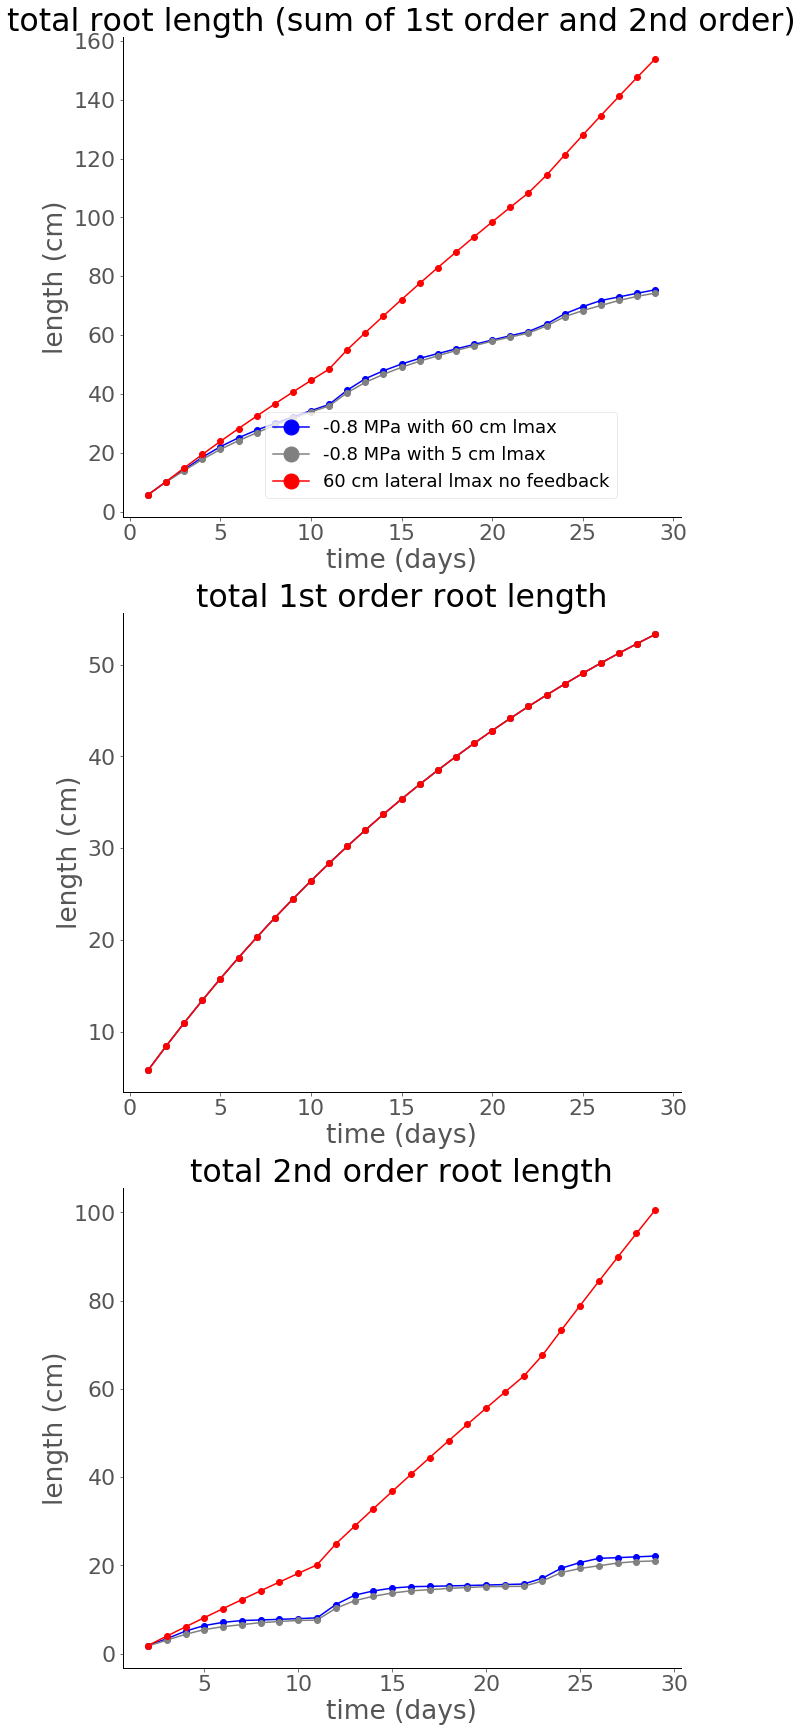

In [30]:


a = 3
b = 1

from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(10,30))
plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'grey', 'red'])))
ax1 = fig.add_subplot(a, b, 1)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("total root length (sum of 1st order and 2nd order)")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")


blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.8 MPa with 60 cm lmax ')

grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa with 5 cm lmax ')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='60 cm lateral lmax no feedback')


plt.legend(loc='lower left', bbox_to_anchor=(0.24, 0.02, 0, 0), handles=[blue_line,  grey_line,  red_line, ])


ax1 = fig.add_subplot(a, b,2)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("total 1st order root length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
# ax1.legend()

ax1.plot(df01_l_order1[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08_l_order1[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15_l_order1[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")


ax1 = fig.add_subplot(a, b, 3)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("total 2nd order root length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
# ax1.legend()

ax1.plot(df01_l_order2[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08_l_order2[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15_l_order2[['organ_length', 'time']].groupby(['time']).sum(),marker= "o")

In [159]:
hetero_pd = pd.read_csv("0.1_0.8_1.5water_long_lateral_60.csv")
fig_pd =  hetero_pd



No handles with labels found to put in legend.
/home/zxrzxr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/zxrzxr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/zxrzxr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



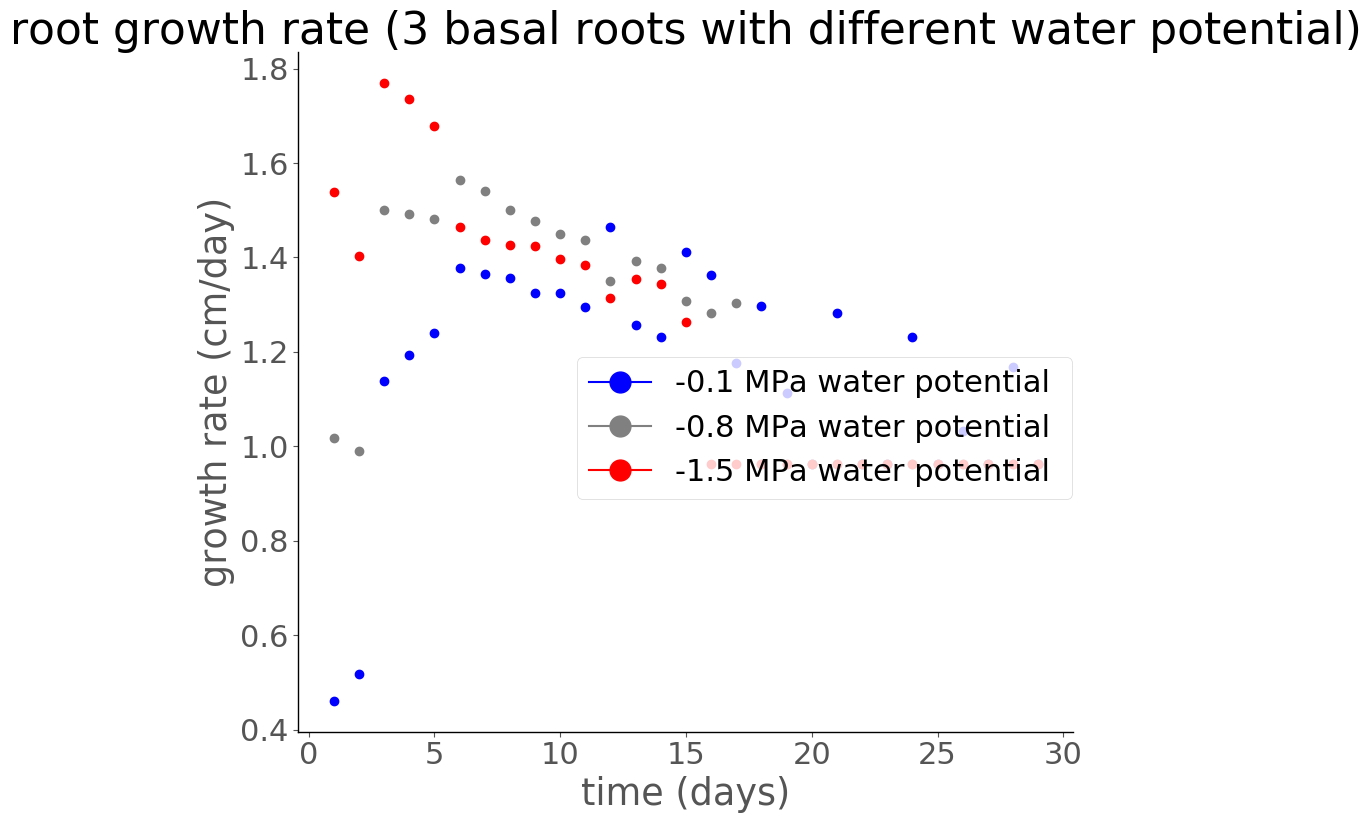

In [160]:
a = 3
b = 1

from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(10,30))
plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'grey', 'red'])))
ax1 = fig.add_subplot(a, b, 1)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("growth rate (cm/day)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("root growth rate (3 basal roots with different water potential)")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()



for i in range(1,30):
    ax1.plot(i,fig_pd[fig_pd["time"] ==i][fig_pd["order"]==1].iloc[0]["growth_rate"] , marker = "o" )
    ax1.plot(i,fig_pd[fig_pd["time"] ==i][fig_pd["order"]==1].iloc[1]["growth_rate"] , marker = "o" )
    ax1.plot(i,fig_pd[fig_pd["time"] ==i][fig_pd["order"]==1].iloc[2]["growth_rate"] , marker = "o" )



blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential ')

grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential ')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential')


plt.legend(loc='lower left', bbox_to_anchor=(0.34, 0.32, 0, 0), handles=[blue_line,  grey_line,  red_line, ])

In [60]:
fig_pd[fig_pd["time"] ==7][fig_pd["order"]==1]

/home/zxrzxr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



time  organ_id  growth_rate  order
619     7         0     1.083241      1
622     7         2     0.963165      1
625     7         4     0.621840      1

In [51]:
fig_pd[fig_pd["time"] ==4][fig_pd["order"]==1].iloc[0]

/home/zxrzxr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



time            4.000000
organ_id        0.000000
organ_length    3.695183
order           1.000000
Name: 247, dtype: float64

In [ ]:
.iloc[2]

In [161]:
fig_pd

time  organ_id   growth_rate  order
8         1         0  4.609171e-01      1
16        1         1  1.016780e+00      1
24        1         2  1.537633e+00      1
72        2         1  2.255683e-01      2
74        2         0  5.174176e-01      1
77        2         3  5.354488e-01      2
81        2         2  9.897273e-01      1
84        2         5  8.897916e-01      2
90        2         4  1.403568e+00      1
161       3         1  4.965940e-01      2
163       3         0  1.138426e+00      1
165       3         3  6.073903e-01      2
168       3         2  1.501496e+00      1
171       3         5  6.849715e-01      2
176       3         4  1.769065e+00      1
267       4         1  3.803193e-01      2
271       4         0  1.193405e+00      1
273       4         3  4.645157e-01      2
278       4         2  1.491276e+00      1
281       4         5  3.953831e-01      2
286       4         4  1.735313e+00      1
402       5         1  3.488574e-01      2
406       5         0  1.239658e+00      1
408       5         3  2.824555e-01      2
413       5         2  1.481939e+00      1
415       5         5  1.618400e-01      2
421       5         4  1.677588e+00      1
548       6         5  1.402446e-06      2
559       6         1  6.292965e-02      2
563       6         0  1.376861e+00      1
...     ...       ...           ...    ...
19052    57        15  7.538511e-03      2
19069    57         7  1.416091e-03      2
19119    57        10  1.402446e-06      2
19131    57         4  2.961101e-03      2
19133    57         5  1.470322e-03      2
19135    57        16  7.223741e-07      2
19141    57        17  1.079475e-02      2
19146    57        11  7.210724e-03      2
19150    57         3  2.393057e-02      2
19155    57        12  9.631654e-01      1
19156    57         6  9.347554e-01      1
19157    57         0  6.218402e-01      1
19389    58        14  1.750490e-03      2
19415    58         8  5.976472e-03      2
19421    58         2  1.028145e-03      2
19455    58         1  1.204440e-03      2
19501    58        13  1.402446e-06      2
19509    58         9  1.402446e-06      2
19519    58        15  7.647602e-03      2
19536    58         7  1.414562e-03      2
19586    58        10  1.402446e-06      2
19598    58         4  2.958846e-03      2
19600    58         5  1.468917e-03      2
19602    58        16  7.223741e-07      2
19608    58        17  1.154995e-02      2
19613    58        11  7.219452e-03      2
19617    58         3  2.392719e-02      2
19623    58         6  9.350121e-01      1
19624    58         0  9.507089e-01      1
19625    58        12  6.218402e-01      1

[719 rows x 4 columns]

##Length of each connection

The connections are stored in *node_connection* list. Every element of the list is a two number list. The first element of this two numbered list is the first connected node and the second element of this two numbered list is the second connected node.

In [61]:
pd_output

Empty DataFrame
Columns: [time, id, organ_type, sub_type, connect_no, organ_id, length, res_main, carbon_q, growth_rate, exudation, order, organ_length, coor_x, coor_y, coor_z, connection_1, connection_2]
Index: []

In [ ]:
(nodes_coor[np.amax(node_connection[i])-1][3]-nodes_coor[np.amin(node_connection[i])-1][3])**2 

In [ ]:
node_c_length=[]
node_c_length = [0] * (len(node_connection) +1)

In [ ]:
i=0
for i, connection in enumerate(node_connection):
    node_c_length[i+1] = node_c_length[np.amin(node_connection[i])-1] + ((nodes_coor[np.amax(node_connection[i])-1][3]-nodes_coor[np.amin(node_connection[i])-1][3])**2 + (nodes_coor[np.amax(node_connection[i])-1][4]-nodes_coor[np.amin(node_connection[i])-1][4])**2 + (nodes_coor[np.amax(node_connection[i])-1][5]-nodes_coor[np.amin(node_connection[i])-1][5])**2)**(0.5) 


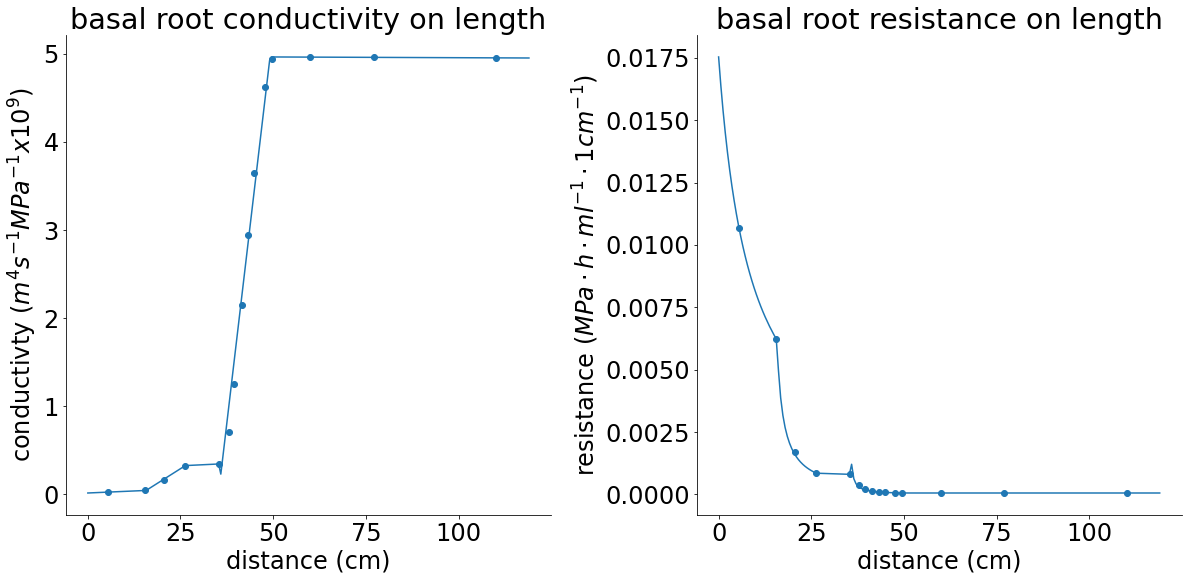

In [9]:
plt.rcParams['figure.figsize'] = [20, 30]
plt.rcParams.update({'font.size': 24})
f = plt.figure()
plt.rcParams.update({'legend.fontsize': 18})
f.subplots_adjust(wspace=0.3)

x_axis_cm = [
5.506136884, 
15.55448305, 
20.57316414, 
26.18098606,
35.34262534,
37.98477221,
39.43565633,
41.46070314,
43.19517371,
44.93363844,
47.69361348,
49.59883503,
59.94275016,
77.08574995,
110.1894737,]

y_axis_r_primary = [
0.02602038694,
0.04459330144,
0.1653671729,
0.3265820678,
0.3453047639,
0.7097233202,
1.256775536,
2.148325359,
2.938572914,
3.647738714,
4.620245475,
4.944247972,
4.962770959,
4.959875182,
4.954283337,  
]

ax = plt.subplot(321)

ax.scatter(x_axis_cm, y_axis_r_primary)
# primary_r_interval = [0, 15, 35, ] 
def k_primary(x):
    if x < 15.55:
        return 0.001848355360491469*x+0.015843089314858807
    elif 26.18> x >= 15.55 :
        return 0.0265794629572805*x-0.3731958224157048
    elif 35.34> x >= 26.18 :
        return 0.0020435967328327315*x +0.2730786902254447
    elif 49.59> x >= 35.34 :
        return 0.35677667926196793*x -12.57081093520535
    elif 120> x >= 49.59 :
        return -0.00016891891420869065*x +4.9728964232362864 
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_color('black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.title.set_text("basal root conductivity on length")
ax.set_xlabel("distance (cm)")
ax.set_ylabel("conductivty ($m^4 s^{-1} MPa^{-1} x 10^9$)")

#     from conductivity to resistance from m^4 s^-1 MPa^-1 x 10^9  to  MPa h ml^-1 /1 cm
def k_to_r(k): 
    return 10e-9 *100*100*100*100 /3600/k
    
x = np.linspace(0,119,200)
y = np.zeros(200)
for i in range (0,len(x)):
    y[i] = k_primary(x[i])

ax.plot(x, y)


ax = plt.subplot(322)

yc2 = np.zeros(len(x_axis_cm))
for i in range (0,len(x_axis_cm)):
    yc2[i] = k_to_r(y_axis_r_primary[i])

ax.scatter(x_axis_cm,yc2)
x = np.linspace(0,119,200)
y2 = np.zeros(200)
for i in range (0,len(x)):
    y2[i] = k_to_r((k_primary(x[i])))
    
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_color('black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.title.set_text("basal root resistance on length")
ax.set_xlabel("distance (cm)")
ax.set_ylabel("resistance ($MPa \cdot h \cdot ml^{-1} \cdot 1cm^{-1}$)")    
    
ax.plot(x, y2)

In [ ]:
y

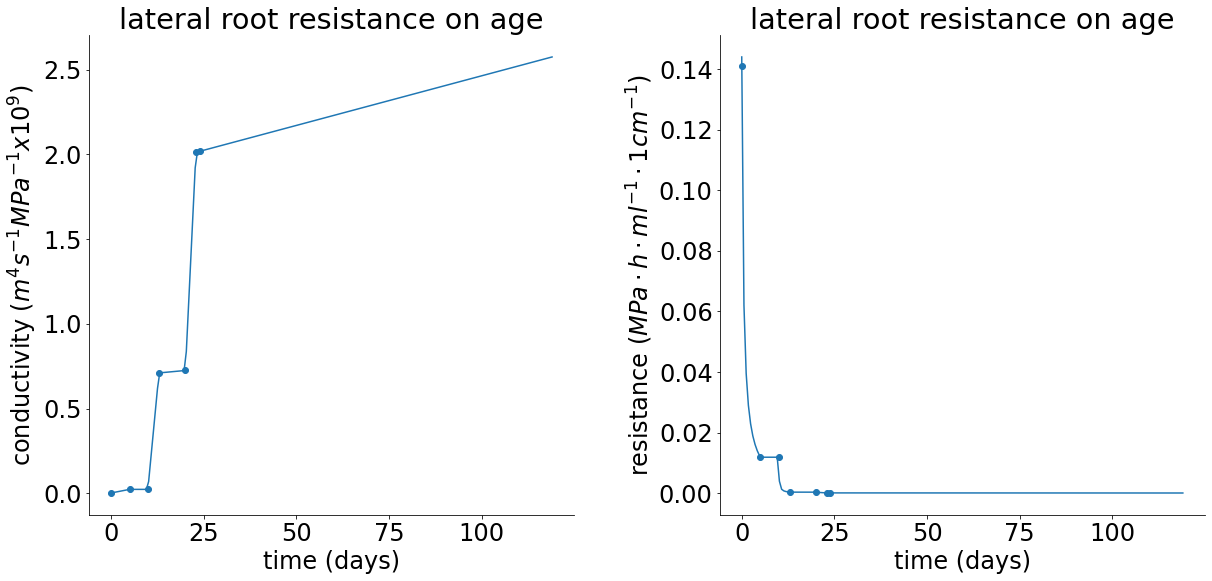

In [10]:
plt.rcParams['figure.figsize'] = [20, 30]
plt.rcParams.update({'font.size': 24})
f = plt.figure()
plt.rcParams.update({'legend.fontsize': 18})
f.subplots_adjust(wspace=0.3)

x_axis_day = [
0.009810055459,
5.020713492,
9.963766575,
12.95495271,
20.08446367,
22.92530994,
23.92745418,]

y_axis_r_lateral = [
0.001971122598,
0.0233102711,
0.02327989941,
0.710208532,
0.7246776045,
2.011526056,
2.017393866,  
]

ax = plt.subplot(321)

ax.scatter(x_axis_day, y_axis_r_lateral)
# primary_r_interval = [0, 15, 35, ] 
def k_lateral(x):
    if x < 5:
        return 0.004258543149115853*x+0.0019293460538895271
    elif  9.96> x >= 5:
        return 0.0000019478470310608697*x+0.02330049151582271
    elif 12.95> x >= 9.96 :
        return 0.22965091485084213*x -2.2649082099802036
    elif 20> x >= 12.95 :
        return 0.0020294621328947786*x + 0.6839169460538098
    elif 23> x >= 20 :
        return 0.45298067054396246*x +-8.373196214574355 
    elif  x >= 23 :
        return 0.005855255182446519*x +1.877292516018327

#     from conductivity to resistance from m^4 s^-1 MPa^-1 x 10^9  to  MPa h ml^-1 /5 cm
def k_to_r(k): 
    return 10e-9 *100*100*100*100 /3600/k
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_color('black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)    
x = np.linspace(0,119,200)
y = np.zeros(200)
for i in range (0,len(x)):
    y[i] = k_lateral(x[i])

ax.title.set_text("lateral root resistance on age")
ax.set_xlabel("time (days)")
ax.set_ylabel("conductivity ($m^4 s^{-1} MPa^{-1} x 10^9$)")
    
ax.plot(x, y)


ax = plt.subplot(322)

yc2 = np.zeros(len(x_axis_day))
for i in range (0,len(x_axis_day)):
    yc2[i] = k_to_r(y_axis_r_lateral[i])

ax.scatter(x_axis_day,yc2)
x = np.linspace(0,119,200)
y2 = np.zeros(200)
for i in range (0,len(x)):
    y2[i] = k_to_r((k_lateral(x[i])))
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_color('black')

ax.spines['left'].set_color('black')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.title.set_text("lateral root resistance on age")
ax.set_xlabel("time (days)")
ax.set_ylabel("resistance ($MPa \cdot h \cdot ml^{-1} \cdot 1cm^{-1}$)")    
    
    
ax.plot(x, y2)

In [ ]:
nodes_length = np.zeros(len(nodes_coor))
for i in range(1,len(nodes_coor)):
    if nodes_coor[i][1]==2: #if the organtype is root
        nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] - ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 
    else:
        nodes_length[i] = nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) 


In [ ]:
1

In [ ]:
for i, node_l in enumerate(nodes_length):
#     print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().subType)
    phloem_radius = plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().r
    resistance_propotional =20 *(2**4)/phloem_radius**4 # based on hagen poissuelle's law
    print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().r)
    

In [ ]:
for i in range(0,(len(node_connection)+1)):    
    print(plant.getOrgans()[node_id_to_organ[i]].getLength()/100) 

In [ ]:
axial_r_xylem = []
for i in range(0,(len(node_connection))):
    if plant.getOrgans()[node_id_to_organ[i+1]].getParent().getOrganRandomParameter().subType == 0:
        axial_r_xylem.append(
           k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[i+1]].getLength() - np.abs(nodes_length[i+1])*100))))
    else:
        axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) )

In [ ]:
axial_r_xylem

In [ ]:
len(to_tip_distance)

In [ ]:
plant.getOrgans()[1].getChild(0).getAge()

In [ ]:
plant.getOrgans()[1].getChild(1).getAge()

In [ ]:
N1L_node

In [ ]:
all_marker_c = [] # all the marker for connections
N1L_connection = [] # all the marker for connections
N1R_connection = [] # all the marker for connections
for i,n in enumerate(N1R_node.T[0]):
    N1R_connection.append(np.where(node_connection[:,1] == N1R_node.T[0][i] )[0][0])
for i,n in enumerate(N1L_node.T[0]):
    N1L_connection.append(np.where(node_connection[:,0] == N1L_node.T[0][i] )[0][0])
all_marker_c.append(N1L_connection)

In [ ]:
for i in N1L_connection:
    print(node_connection[i][0])

In [ ]:
piaf_output["JS_ST"]

In [ ]:
len(piaf_output["JW_Xyl"][1])

In [ ]:
for i,n in enumerate(N1L_node.T[0]):
    print(np.where(node_connection[:,0] == N1L_node.T[0][i] )[0][0])

In [ ]:
dict_all["node_connection"]

In [ ]:
all_marker_c_1

In [ ]:
stem_mid_node

In [ ]:
def add_day_night():
    #trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    #ax.fill_between(x, np.min(y), np.max(y), where=[ 12<x<18] , facecolor='lightgrey', alpha=1, interpolate=False,zorder=0,transform=trans)
    for i in range(0,4):
        ax.axvspan(0,5,facecolor='lightgrey', zorder=0)
        ax.axvspan(18+24*i,29+24*i,facecolor='lightgrey',zorder=0)
        
plt.style.use('default')
x=piaf_output["time"]
lable_size=16
title_size =24

def line_style(int): #set line style in the plot figure
    if  i ==1 : #int is a small part of main stem which are shown in dashed line 
        return ':'
    else: #
        return '-'
stem_line = mlines.Line2D([], [], color='darkgreen', marker='', linestyle='-', linewidth= 5,
                          markersize=30, label='Stem')
root_line = mlines.Line2D([], [], color='wheat', marker='', linestyle='-', linewidth= 5,
                          markersize=30, label='Root')
leaf_line = mlines.Line2D([], [], color='lightgreen', marker='', linestyle='-', linewidth= 5,
                          markersize=30, label='Leaf')
stem_line1 = mlines.Line2D([], [], color='darkgreen', marker='', linestyle=':', linewidth= 5,
                          markersize=30, label='Stem\n between\n two\n leaves')


csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Comic Sans MS'}

plt.rcParams['figure.figsize'] = [20, 30]
plt.rcParams.update({'font.size': 24})
f = plt.figure()
plt.rcParams.update({'legend.fontsize': 18})
f.subplots_adjust(wspace=0.3)

node_connection =dict_all['node_connection']

stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 1)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 3)][:,0] 
# get all the end nodes
for k in reversed(range(len(organ))):  # loop through all the organs
    if organ[k].organType()==3 and organ[k].getParent().organType()==1:
        stem_mid_node = organ[k].getNodeId(2)
all_marker = np.concatenate((N1L_node.T[0], N1R_node.T[0], [stem_mid_node]  ), axis=0, out=None).astype(int)
all_marker_1  = map(lambda x: x-1, all_marker)
all_marker_1 = list(all_marker_1)
#  =[3, 10, 17, 23,28, 31,]

all_marker_c = [] # all the marker for connections
for i,n in enumerate(N1R_node.T[0]):
    all_marker_c.append(np.where(node_connection[:,1] == N1R_node.T[0][i] )[0][0])
for i,n in enumerate(N1L_node.T[0]):
    all_marker_c.append(np.where(node_connection[:,0] == N1L_node.T[0][i] )[0][0])
all_marker_c.append(np.where(node_connection[:,1] == stem_mid_node)[0][0])

# all_marker_c_1  = map(lambda x: x-1, all_marker_c)
all_marker_c_1 = list(all_marker_c)
    
def organ_color_n(int):
    if int+1 in N1L_node.T[0]: #int is source 
        return 'lightgreen'
    elif int+1 in N1R_node.T[0] : #int is sink
        return 'wheat'
    elif int+1 == stem_mid_node :
        return 'darkgreen'
    else:
        return 'None'    

def organ_color_c(int):
    if node_connection[int,0] in N1L_node.T[0]: #int is source 
        return 'lightgreen'
    elif node_connection[int,1] in N1R_node.T[0] : #int is sink
        return 'wheat'
    elif  node_connection[int,1] == stem_mid_node :
        return 'darkgreen'
    else:
        return 'None'       
time = piaf_output["time"]

ax = plt.subplot(321)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
plt.xlabel("Time (hour)")
plt.ylabel("Xylem Pressure (MPa)", color='black')
#plt.ylabel("Xylem water flow (ml h$^{-1}$)".format(output.columns[n_begin]))
#plt.title("{}th figure {} ".format(i ,output.columns[n_begin]))
plt.title("A: Xylem Pressure", color='black' ,loc="left")
#plt.title("Xylem Water Flow with Constant Transpiration".format(i ,output.columns[n_begin]))
for i in all_marker_1:
    ax.plot(x,piaf_output["P_Xyl"].T[i], linewidth=5
                ,c=organ_color_n(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()








ax = plt.subplot(322)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
plt.xlabel("Time (hour)")
plt.ylabel("Xylem Water Flow (ml h$^{-1}$)")
plt.title("B: Xylem Water Flow",loc="left")
#plt.title("Xylem Water Flow with Constant Transpiration".format(i ,output.columns[n_begin]))
for i in all_marker_c_1:
    ax.plot(x,piaf_output["JW_Xyl"].T[i], linewidth=5,c=organ_color_c(i),alpha=0.8,zorder=0, ls = line_style(i))
# plt.ylim((-0.0001, 0.0005))
# plt.xlim((15, 32))
add_day_night()


ax = plt.subplot(323)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
plt.xlabel("Time (hour)", **hfont)
plt.ylabel('Water from Xylem to Phloem (ml h⁻¹)', color='black')
plt.title('C: Water from Xylem to Phloem', color='black', loc="left")  
for i in all_marker_1:
        ax.plot(x,piaf_output["JW_Trsv"].T[i], linewidth=5,
                c=organ_color_n(i),alpha=0.8, ls = line_style(i))
add_day_night()




ax = plt.subplot(324)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


plt.xlabel("Time (hour)", **hfont)

plt.ylabel('Carbon Flow (mmol h⁻¹)', color='black')
 
plt.title('D: Phloem Carbon Flow', color='black',loc="left")  
for i in all_marker_c_1:
    ax.plot(x,piaf_output["JS_ST"].T[i], linewidth=5
                ,c=organ_color_c(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()


ax = plt.subplot(325)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


plt.xlabel("Time (hour)", **hfont)

plt.ylabel('Phloem pressure (MPa)', color='black')
 
plt.title('E: Phloem pressure', color='black',loc="left")  
for i in all_marker_c_1:
    ax.plot(x,piaf_output["P_ST"].T[i], linewidth=5
                ,c=organ_color_c(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()

ax = plt.subplot(326)
ax.tick_params(width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)


plt.xlabel("Time (hour)", **hfont)

plt.ylabel('Phloem Flow (ml h⁻¹)', color='black')
 
plt.title('E: Phloem Flow', color='black',loc="left")  
for i in all_marker_c_1:
    ax.plot(x,piaf_output["JW_ST"].T[i], linewidth=5
                ,c=organ_color_c(i),alpha=0.8,zorder=0, ls = line_style(i))
add_day_night()

plt.show()
# s =output.columns[n_begin]
# s = s.replace('/', '')
s = "small_2020"
# f.savefig("diural_homogeneous{}.png".format(s), bbox_inches='tight', dpi=600)



In [ ]:
# castor beans phloem flow rate: 0.2 (mm^3 s^-1)*3600/1000 = 0.72 ml/h doi: 10.1111/j.1365-3040.2006.01544.x
# castor beans Xylem flow rate: 4 (mm^3 s^-1) *3600/1000 = 14.5

In [ ]:
nodes_coor

In [ ]:

# nodes_coor = np.column_stack([dict_all["nodes_organtype"], dict_all["nodes"]])
nodes_coor = python_nodes(plant)
node_connection = dict_all["node_connection"]
plt.rcParams['figure.figsize'] = [20, 20]

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt




fig = plt.figure()

ax = fig.add_subplot(122, projection='3d')
plt.rcParams.update({'font.size': 90})
plt.title('PiafMünch')
x =nodes_coor[:,3]*100
y =nodes_coor[:,4]*100
z =nodes_coor[:,5]*100

# Get rid of colored axes planes
# First remove fill
#ax.set_axis_off()
# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Now set color to white (or whatever is "invisible")
#ax.xaxis.pane.set_edgecolor('w')
#ax.yaxis.pane.set_edgecolor('w')
#ax.zaxis.pane.set_edgecolor('w')


ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

# Bonus: To get rid of the grid as well:
ax.grid(False)

def so_si_color(int):
    if int in N1L_node[:,0]: #int is source 
        return 'lightgreen'
    elif int in N1R_node[:,0]: #int is sink
        return 'orange'
    else:
        return 'darkgreen'
    


for i in range(len(nodes_coor)):
    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(i),
            markersize=20, color=so_si_color(i+1), alpha=1)
    #ax.scatter(cor_x[i], cor_y[i],cor_z[i], s=100, marker = organ_marker(node_connection[i,0]) ,edgecolors= organ_color3(i))

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xlim3d(-1.2, 1)
ax.set_ylim3d(1.5 ,0.5)
ax.set_zlim3d(-8.8,0)

#ax.elev = 89.9
#ax.azim = 270.1
ax.dist = 6.0
#ax.view_init(0, 90)
ax.view_init(0, 90)
stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 3)][:,0] 
root_nodes = nodes_organtype[(nodes_organtype[:,1]== 2)][:,0] 
leaf_nodes = nodes_organtype[(nodes_organtype[:,1]== 4)][:,0] 
#(nodes_organtype[:,1]== 8)|
#print(stem_nodes)



ax = fig.add_subplot(121, projection='3d')
plt.rcParams.update({'font.size': 90})
plt.title('CPlantBox$\u2192$ ')
x =nodes_coor[:,3]*100
y =nodes_coor[:,4]*100
z =nodes_coor[:,5]*100
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

# Bonus: To get rid of the grid as well:
#ax.grid(False)
#for i in range(len(nodes_coor)):
#    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(nodes_coor[i,1]),
#            markersize=12, color='black')
def organ_color(int):
    if int in leaf_nodes: #int is source 
        return 'lightgreen'
    elif int in root_nodes: #int is sink
        return 'orange'
    elif int in stem_nodes:
        return 'darkgreen'
    else:
        return 'black'

for i in range(len(node_connection)):
    #xline = [x[node_connection[:,0][i]]],[x[node_connection[:,1][i]]] )
    #yline = np.array([y[node_connection[:,0][i]]],[y[node_connection[:,1][i]]] )
    #zline = np.array([z[node_connection[:,0][i]]],[z[node_connection[:,1][i]]] )
    ax.plot3D(np.array([[x[node_connection[:,0][i]-1]][0],[x[node_connection[:,1][i]-1]][0]]), 
              np.array([[y[node_connection[:,0][i]-1]][0],[y[node_connection[:,1][i]-1]][0]]), 
              np.array([[z[node_connection[:,0][i]-1]][0],[z[node_connection[:,1][i]-1]][0]]), 
              color=organ_color(node_connection[i,1]), alpha=0.9, linewidth=12)

    
#ax.scatter([x[715]], [y[715]], [z[715]], c='r', s=99)
#ax.scatter([x[860]], [y[860]], [z[860]], c='g', s=99)
#ax.scatter([x[627]], [y[627]], [z[627]], c='g', s=99)

ax.dist = 6.0
ax.set_xlabel('',labelpad=0)
ax.set_ylabel('',labelpad=0)
ax.set_zlabel('',labelpad=0)
ax.set_xlim3d(-1.2, 1)
ax.set_ylim3d(1.5 ,0.5)
ax.set_zlim3d(-8.8,0)
#ax.xaxis.set_ticks(np.arange(0, 3, 1))
#ax.yaxis.set_ticks(np.arange(0 ,3, 1))
#ax.zaxis.set_ticks(np.arange(-3,2, 1))
plt.rcParams.update({'font.size': 40})
root_patch = mpatches.Patch(color='orange', label='Root')
# seed_patch = mpatches.Patch(color='black', label='seed')
stem_patch = mpatches.Patch(color='darkgreen', label='Stem')
leaf_patch = mpatches.Patch(color='lightgreen', label='Leaf')
plt.legend(handles=[leaf_patch,stem_patch,  root_patch],bbox_to_anchor=(0.5, 0.3), loc=2, borderaxespad=0.)
ax.view_init(0, 90)
plt.show()


fig.savefig("{}.svg".format('CPlantBox_to_PiafMunch'), bbox_inches='tight')

In [ ]:
i =5
[x[node_connection[:,0][i]]][0]

In [19]:
%%time
# growth rate percentage based on water potential: y = 20.790289211055025 + 83.59701538925951e* **(x*1.3957803144484557)
g_propotion = lambda water_potential : (20.79 + 83.597* 2.71828**(1.39578* (water_potential)) )/100
# absolute respiration maintenance of plant segment = volumen of the segment * 0.0032
# TODO to see if some other parameters from the output can be used as input
# carbon feedback loop by days.
for time in range(1,30): # i*days to simulation
    pd_output_1day =  pd.DataFrame( [], columns= column_name )

    day_i = day_i +1
#     plant.setGeometry(splitBox)
    day = 1# the step of every loop (day)
    hour =24 # the hours of every loop (hour) used in PiafMunch
    plant.simulate(1 * day) # start simulation
    organ = plant.getOrgans()
    ana = pb.SegmentAnalyser(plant)
    ana.write("{}{}{}.vtp".format("test",str(name),day_i*day)) #writes vtp the name is followed by the number of days simulated
   
    # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
    dict_all  = convert( plant ) # convert plant to python outputs
    nodes_organtype = dict_all['nodes_organtype']
    nodes_coor = python_nodes(plant)
    segs = np.array([np.array(s) for s in plant.getSegments()])
    node_connection_o = segs
    pd_output_1day.loc[:,"id"] = list(map(int,dict_all["nodes_organtype"].T[0]))
    pd_output_1day.loc[:,"organ_type"] = list(map(int,dict_all["nodes_organtype"].T[1]))
    pd_output_1day.loc[:,"connect_no"] = list(map(int,dict_all["nodes_organtype"].T[2]))
    
    pd_output_1day.loc[:,"coor_x"] = list(nodes_coor.T[3])
    pd_output_1day.loc[:,"coor_y"] = list(nodes_coor.T[4])
    pd_output_1day.loc[:,"coor_z"] = list(nodes_coor.T[5])
    
    pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_1"] = list(map(int,dict_all["node_connection"].T[0]))
    pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_2"] = list(map(int,dict_all["node_connection"].T[1]))

    
    piafmunch_outputname = name +".ini" # set the name of the parameters
    Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
    organ_radius = [0]*((len(organ))) # initiate the radius of each segment
    k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
    kt = [0]*(len(dict_all['node_connection'])+1) # total carbon maintenance
    
    node_id_to_organ = [0]*plant.getNumberOfNodes() #
    node_id_to_subtype = [0]*plant.getNumberOfNodes() #



    ########################################## python nodes conversion #########################################
    
    
    # sink nodes (nodes have one connection and on the right hand side)
    N1R_node = nodes_organtype[(nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # remove seed. get roots with one connection
    # source nodes
    N1L_node = nodes_organtype[ ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # remove seed. get stem or leaf with one connection
    leaf_logger.append(len(N1L_node)) 
    
    ########################## nodewise iteration to know which organ it belongs to ###########################################
    ########################## nodewise iteration to get maximal  ###########################################  
    
    # need more check 
    #
    for k in reversed(range(len(organ))):  # loop through all the organs
        organ_radius[k] = organ[k].getParam().a #the diameter of one organ
        j=0
        
        for j in range(1,organ[k].getNumberOfNodes()): # loop through all segments in one organs
            node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number

            node_id_to_subtype[organ[k].getNodeId(j)] = int(organ[k].getParameter("subType"))

            
            volumen = organ_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx
            phloem_per_section = 1#4200
            m_r = 0.0032 # Organ maintenance respiration rate (gCO2 g−1 DM)
            mass_per_volumen = 0.10 #root dry mass per unit volume (gDM cm−3) 0.05-0.14
            Carbon_main = volumen *0.0032*0.1/(24) *1000/12 # (1000/12) from grams/day/cm3 to mmol/hour/cm3 calculate the maintenance by volume (mmol)
            #Carbon_main = 1
            # print("maintenance is : ", Carbon_main) # absolute carbon maintentance
            k1[organ[k].getNodeId(j)] = Carbon_main 
    k1_logger.append(np.sum(k1))
    taproot_length = [0] * (len(plant.getOrgans())-2)
    all_organ_length = [0] * (len(plant.getOrgans())-2)
    taproot_n = []
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
            taproot_n.append(root_n)
    taproot_n_all.append(taproot_n)
             ############################# water potential in left and right !root! ##################################################
    soil_wp = 0.8
    for j,organ_i in enumerate(plant.getOrgans()): # get all segments in one organs
        print(j, organ_i.organType())
        if j == taproot_n[0] or organ_i.getParent().getId() == 1: # first taproot
            Soil_water[j] = soil_wp
        elif j == taproot_n[1] or organ_i.getParent().getId() == 2:
            Soil_water[j] = soil_wp
        elif j == taproot_n[2] or organ_i.getParent().getId() == 3:
            Soil_water[j] = soil_wp 
        else:
            Soil_water[j] = soil_wp
        

    organ_number_to_order = [0] *len(organ)
    for k in reversed(range(len(organ))):  # loop through all the organs
        if organ[k].getParent().organType() == 1:
            organ_number_to_order[k] = 1
        elif organ[k].getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 2
        elif organ[k].getParent().getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 3
        elif organ[k].getParent().getParent().getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 4
        elif organ[k].getParent().getParent().getParent().getParent().getParent().organType() == 1:
            organ_number_to_order[k] = 5
        else:
            organ_number_to_order[k] = 6

    i=0
    for i in range(len(nodes_organtype)):
        pd_output_1day.loc[i,"order"] = organ_number_to_order[node_id_to_organ[i]]
#         print("node_id_to_organ[i]", node_id_to_organ[i])
#         print("organ_number_to_order[node_id_to_organ[i]]", organ_number_to_order[node_id_to_organ[i]])        
        
        
    ############################# water potential in left and right !boxex! ##################################################
#     for i, roottip in enumerate(N1R_node): 
#         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
#             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
#         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
#             Soil_water[i] = 0.1 # actuall value is -0.5
#         else:
#             Soil_water[i] = 0.1 # actuall value is -0.1
    
    nodes_length = np.zeros(len(nodes_coor))
    for i in range(1,len(nodes_coor)):
        if nodes_coor[i][1]==2: #if the organtype is root
            nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]]  
                               + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )
        else:
            nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] 
                               + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                  + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                  + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )

    
    axial_r_xylem = []
    for i in range(0,(len(dict_all["node_connection"]))):
        second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1

        if plant.getOrgans()[node_id_to_organ[second_node]].getParent().getOrganRandomParameter().subType == 0:
            axial_r_xylem.append(
               k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[second_node]].getLength() - np.abs(nodes_length[second_node])*100))))
        else:
            axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) )

    axial_r_phloem = []
    for i in range(0,(len(dict_all["node_connection"]))):
        #     print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().subType)
        second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1
        phloem_radius = plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a
        resistance_propotional =0.04 *(0.2**4)/phloem_radius**4 # based on hagen poissuelle's law
        # print(plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a)
        axial_r_phloem.append(resistance_propotional)
        
        
    def devide_20(x):
        return x/4
    
    axial_r_xylem_0_25cm = map(devide_20, axial_r_xylem)
    ################################# coupling layer with piafmunch ###################################################
    homo_st = [0.04]*(len(dict_all["node_connection"]))
    # pass the absolute carbon maintentance to piafmunch
    write_PiafMunch_parameter(dict_all['node_connection'], 
                              dict_all['nodes_organtype'], 
                               axial_r_phloem, 
                              dict_all['unq_cnt'], 
                              Soil_water, 
                              k1, 
                              piafmunch_outputname,
                              hour, 
                              list(axial_r_xylem_0_25cm), 
                              vml, 
                              vol_st, 
                              vmu, 
                              r_phl_mb,
                              r_trsv)
    # call piafmunch and rename the output file of the PiafMunch
#     os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
#     now = datetime.datetime.now()
#     os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_output.txt'.format(name, now.year ,now.month, now.day,name ) )
    
    ########################## convert carbon to growth rate ###########################################
#     piaf_output = read_output(name,  dict_all["node_connection"])
    one_growth_log = [0] * (len(plant.getOrgans())+1)
    one_carbon_log = [0] * (len(plant.getOrgans())+1)
    one_exudation_log = [0] * (len(plant.getOrgans())+1)
    for node_i,root_node in enumerate(N1R_node): # CPlantBox growth rate: cm day-1
        # print(i)
        nodes_organ = organ[node_id_to_organ[int(root_node[0])-1]]
        pd_output_1day.loc[int(root_node[0])-1,"organ_length"] = nodes_organ.getLength()

        corss_area_root= nodes_organ.getParam().a**2*3.1415926 # this is also the carbon used for growth because mass need is 1 g DM cm−3
        # carbon_need = # mass need is 1 g DM cm−3
        # print("corss section area of root", corss_area_root)
        # carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 * 10 * volumen # directly pass the Q_ST * 1e5 to carbon content
        # num_of_phloem = 4200/0.12566370400000001
        carbon_available = 9999 #piaf_output["Q_ST"][-1][int(root_node[0])-1]
        carbon_available_g_c = 9999#piaf_output["Q_ST"][-1][int(root_node[0])-1]* 12/1000 *24 #  # gram of carbon per day
        print(" " )
#         print("available carbon: ", carbon_available_g_c )
#         print(node_id_to_organ[int(root_node[0])-1])
        
#         print(nodes_organ.getOrganRandomParameter().r)
        
        rw_satis = g_propotion(0 - Soil_water[node_i])
        #if exudation_logger == []:
        gr_water =  rw_satis * nodes_organ.getOrganRandomParameter().r
#         print("rw_satis", rw_satis)
#         print("growth rate by water", gr_water)
        # nodes_organ.getParam().r =   max([0, min([water_potential ,carbon_content])] )
        # r_carbon =  carbon_content/r_water
        gr_pot_2 = gr_water
        c_demand_2 = max(0.000001, corss_area_root *gr_pot_2  * 0.1 ) # 0.1 g DM cm−3 / day
#         print("water_satis", )
#         print("c_demand_2",c_demand_2)
        c_offer_2 = carbon_available_g_c
#         print("c_offer_2", c_offer_2)
        c_satis = c_offer_2 / c_demand_2
        
        gr_act = gr_pot_2 * max([0.000001, min([1,c_satis])])
#         print("GR_act", gr_act)
#         nodes_organ.getParam().r =   max([0, min([gr_water, carbon_content])])
        nodes_organ.getParam().r = gr_act
#         print("growth rate", nodes_organ.getParam().r)
        pd_output_1day.loc[int(root_node[0])-1, "growth_rate"] = gr_act
        pd_output_1day.loc[int(root_node[0])-1, "exudation"] = max([0 ,carbon_available_g_c - c_demand_2])  
        
        
        one_carbon_log[node_id_to_organ[int(root_node[0])-1]] = carbon_available
        one_growth_log[node_id_to_organ[int(root_node[0])-1]] = gr_act
        one_exudation_log[node_id_to_organ[int(root_node[0])-1]] = max([0 ,carbon_available_g_c - c_demand_2])  
    ############################################length logger ###########################
    growth_rate_logger.append(one_growth_log)
    carbon_logger.append(one_carbon_log)
    exudation_logger.append(one_exudation_log)

    taproot_length = [0] * (len(plant.getOrgans())-2)
    all_organ_length = [0] * (len(plant.getOrgans())-2)
    
    for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
        if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
            taproot_length[root_n] = root.getLength()
            all_organ_length[root_n] =  root.getLength()
        elif root.organType() == 2 and root.getParent().organType()!=1: # not primary roots
            # print("lateral",root.getParent().organType() ,  root_n)
            # print(root.getParent().getId())
            taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
            all_organ_length[root_n] = root.getLength()
    root_length_logger.append(taproot_length)
    all_length_logger.append(all_organ_length)
    

    pd_output_1day.loc[:,"organ_id"] = list(map(int,node_id_to_organ))
    pd_output_1day.loc[:,"length"] = list(nodes_length)
    pd_output_1day.loc[:,"res_main"] = list(k1)
    pd_output_1day.loc[:,"carbon_q"] = 999 # piaf_output["Q_ST"][-1]
    pd_output_1day.loc[:,"time"] = day_i
    pd_output_1day.loc[:,"sub_type"] = list(node_id_to_subtype)
    pd_output_1day.loc[0,"sub_type"] = 1
    # pd_output_1day["growth_rate"] = piaf_output["Q_ST"][-1]
    #     f=np.sum
    pd_output = pd_output.append(pd_output_1day)
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[0][0]-1)], color = "red", label = "1st root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[1][0]-1)], color = "blue", label = "2nd root")
#     f.plot(piaf_output["Q_ST"][:,int(N1R_node[2][0]-1)], color = "green", label = "3rd root")
#     f.legend()
#     f.show()
#     print(piaf_output["Q_ST"][-1,int(N1R_node[0][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[1][0]-1)])
#     print(piaf_output["Q_ST"][-1,int(N1R_node[2][0]-1)])
 # growthrate() CPlantBox growth rate: cm day-1
#total length two curve with total water potential

#change the soil water

0 2
1 2
2 2
3 3
4 4
output successful
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 3
7 4
8 4
output successful
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 3
10 4
11 4
output successful
 
 
 
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 3
10 4
11 4
output successful
 
 
 
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 3
10 4
11 4
output successful
 
 
 
 
 
 
 
 
 
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 3
10

In [4]:
water_p_list = [[0.1, 0.1, 0.1], [0.8, 0.8, 0.8], [1.5, 1.5, 1.5], [1.5, 0.8, 0.1] , [0.3, 0.3, 0.3] , [0.5, 0.5, 0.5] , [0.7, 0.7, 0.7] , [0.9, 0.9, 0.9], [1.1, 1.1, 1.1] , [1.3, 1.3, 1.3]  ]
name = "small_2020.xml"
time_total = 60
name_list = []
for i, water_p in enumerate(water_p_list):
    water_dry, water_middle, water_wet =  water_p
    output_name = "{}_{}_{}_{}_{}".format(name, time_total, water_dry, water_middle, water_wet)
    name_list.append("{}.csv".format(output_name))

In [6]:
name_list

['small_2020.xml_60_0.1_0.1_0.1.csv',
 'small_2020.xml_60_0.8_0.8_0.8.csv',
 'small_2020.xml_60_1.5_1.5_1.5.csv',
 'small_2020.xml_60_1.5_0.8_0.1.csv',
 'small_2020.xml_60_0.3_0.3_0.3.csv',
 'small_2020.xml_60_0.5_0.5_0.5.csv',
 'small_2020.xml_60_0.7_0.7_0.7.csv',
 'small_2020.xml_60_0.9_0.9_0.9.csv',
 'small_2020.xml_60_1.1_1.1_1.1.csv',
 'small_2020.xml_60_1.3_1.3_1.3.csv']

In [6]:
def read_filter(file_name):
    op_01 = pd.read_csv(file_name)
    gr_column = ["time", "order", "growth_rate"]
    op_01_gr = op_01[op_01["growth_rate"].notna()]
    op_01_gr =  op_01_gr[gr_column]


    ca_column = ["time", "order", "carbon_q"]
    op_01_ca = op_01[op_01["growth_rate"].notna()]
    op_01_ca =  op_01_ca[ca_column]

    len_column = ["time", "order", "organ_length"]
    op_01_len = op_01[op_01["growth_rate"].notna()]
    op_01_len =  op_01_len[len_column]
    
    len_column = ["time", "order", "exudation"]
    op_01_ex = op_01[op_01["growth_rate"].notna()]
    op_01_ex =  op_01_ex[len_column]
    
    len_column = ["time", "order", "rw_satis"]
    op_01_ws = op_01[op_01["growth_rate"].notna()]
    op_01_ws =  op_01_ws[len_column]
    
    len_column = ["time", "order", "c_satis"]
    op_01_cs = op_01[op_01["growth_rate"].notna()]
    op_01_cs =  op_01_cs[len_column]
    
    
    df = {"growth_rate": op_01_gr, "carbon": op_01_ca, "length": op_01_len, 
          "exudation":op_01_ex ,"rw_satis":op_01_ws, "c_satis":op_01_cs }
    return df

df01 = read_filter(name_list[0])
df08 = read_filter(name_list[1])
df15 = read_filter(name_list[2])


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


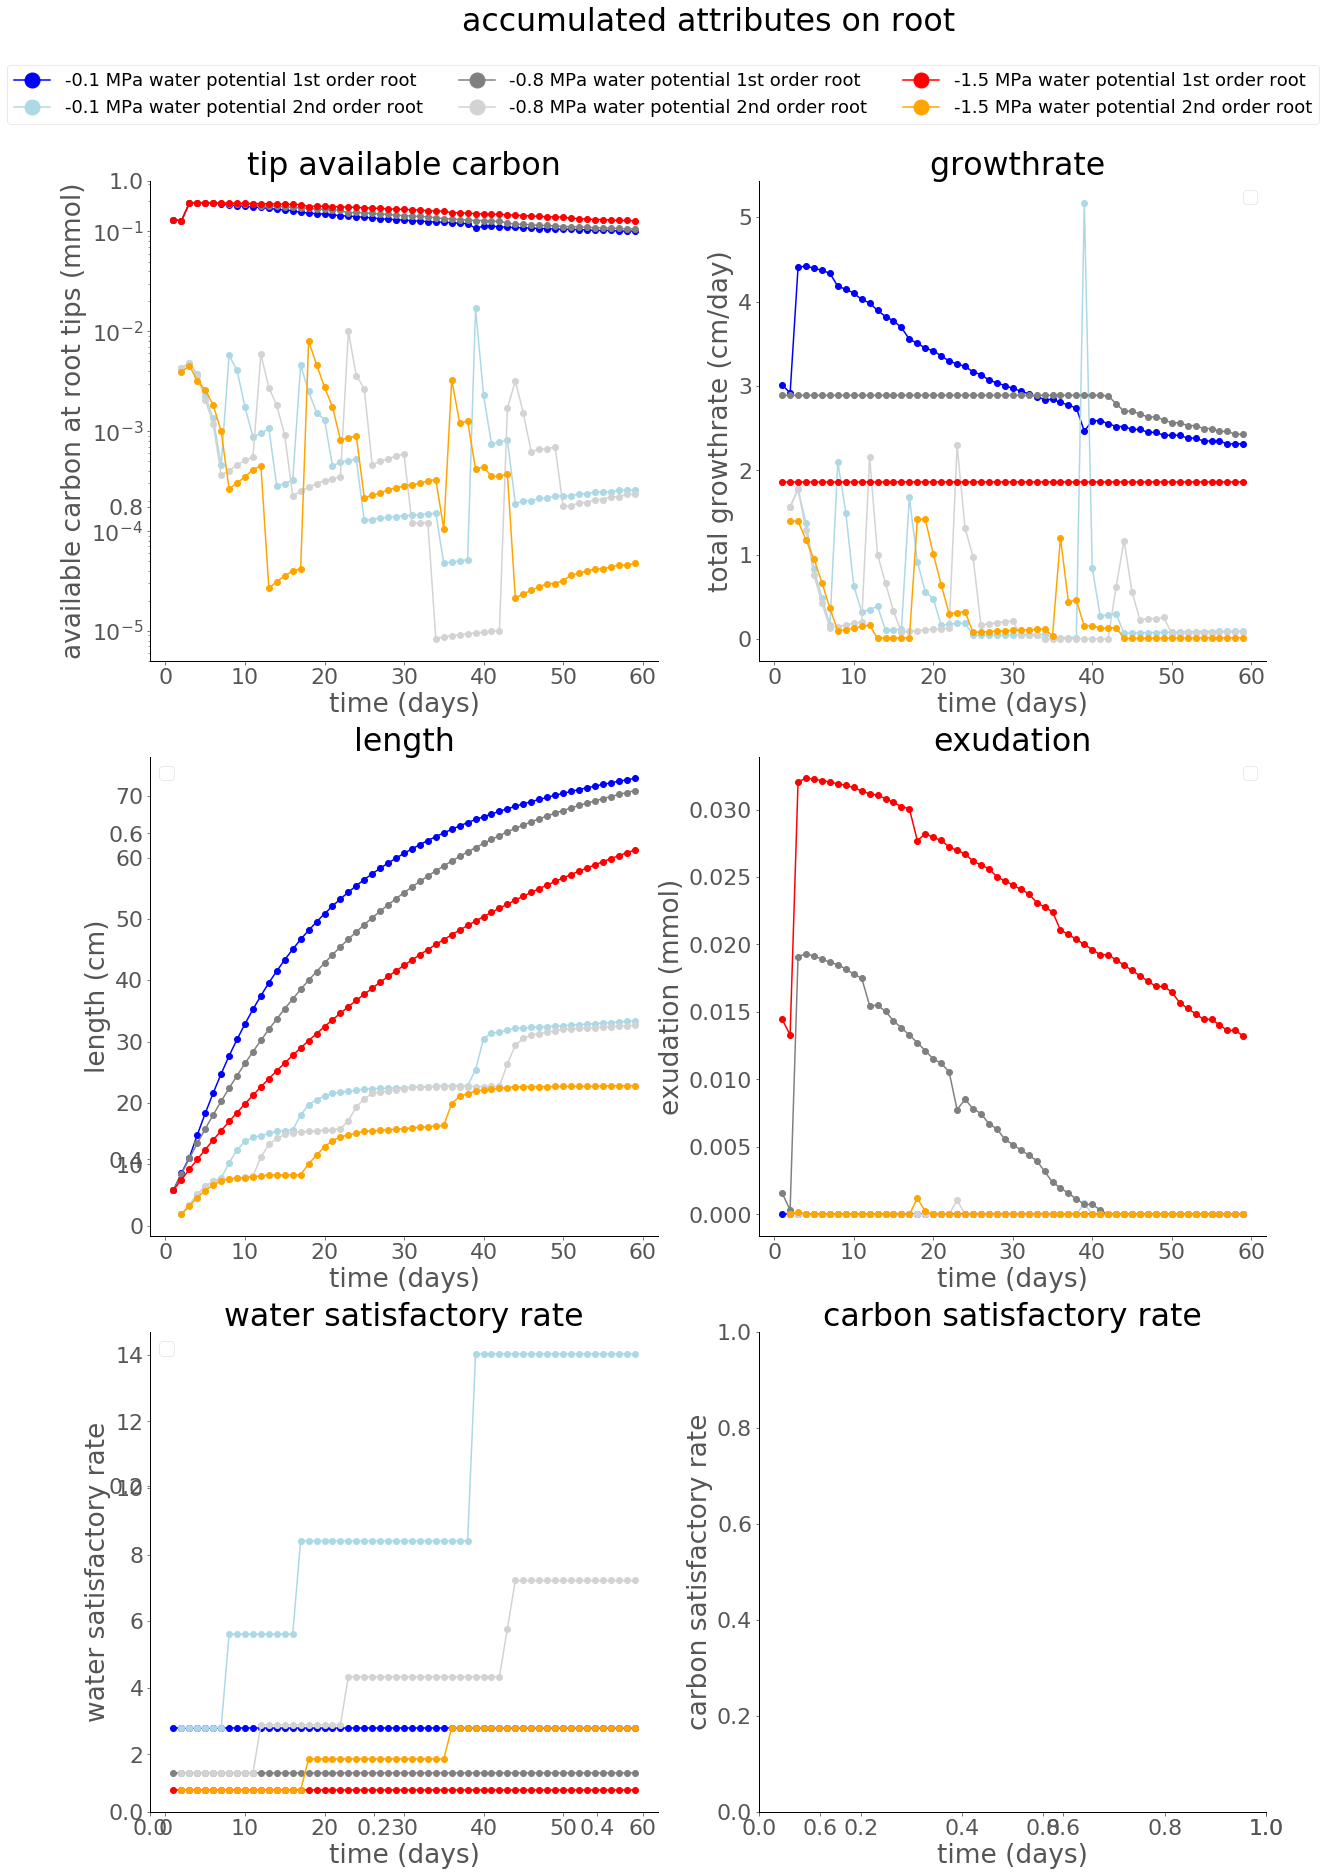

In [7]:

# remove all non


from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(20,30))

plt.title("accumulated attributes on root", pad = 150)
plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'lightblue', 'grey','lightgrey', 'red','orange'])))

a = 3
b = 2


ax1 = fig.add_subplot(a, b, 1)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')
ax1.set_yscale('log')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("available carbon at root tips (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("tip available carbon")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["carbon"].groupby(['time',"order"]).sum().unstack(),marker= "o")

blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 1st order root')
lightblue_line = mlines.Line2D([], [], color='lightblue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 2nd order root')
grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 1st order root')
lightgrey_line = mlines.Line2D([], [], color='lightgrey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 2nd order root')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential 1st order root')
orange_line = mlines.Line2D([], [], color='orange', marker='o',
                          markersize=15, label='-1.5 MPa water potential 2nd order root')

plt.legend(loc='lower left', bbox_to_anchor=(-0.3, 1.1, 0, 0),ncol=3, handles=[blue_line, lightblue_line, grey_line, lightgrey_line, red_line, orange_line])















ax1 = fig.add_subplot(a, b, 2)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("total growthrate (cm/day)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text(" growthrate")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.plot(df01["growth_rate"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["growth_rate"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["growth_rate"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.legend()










ax1 = fig.add_subplot(a, b, 3)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15["length"].groupby(['time',"order"]).sum().unstack(),marker= "o")

ax1 = fig.add_subplot(a, b, 4)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("exudation (mmol)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("exudation")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

fig_colum_name = "exudation"



ax1.plot(df01[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")


ax1 = fig.add_subplot(a, b, 5)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("water satisfactory rate")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("water satisfactory rate")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

fig_colum_name = "rw_satis"



ax1.plot(df01[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df08[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
ax1.plot(df15[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")


ax1 = fig.add_subplot(a, b, 6)


ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("carbon satisfactory rate")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("carbon satisfactory rate")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
# ax1.legend()

fig_colum_name = "c_satis"



# ax1.plot(df01[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
# ax1.plot(df08[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
# ax1.plot(df15[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")



In [67]:
g_propotion(-0.1)

0.9349642286541388

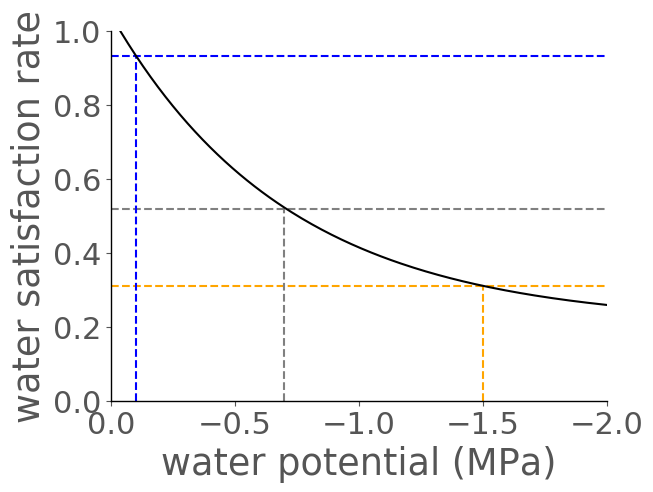

In [77]:
g_propotion = lambda water_potential : (20.79 + 83.597* 2.71828**(1.39578* (water_potential)) )/100
fig= plt.figure()
axes = plt.gca()
plt.xlim(-2,0)
ax1 = fig.add_subplot(1, 1, 1)
t = np.arange(-2, 0.5, 0.01)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
axes.set_xlim([0,-2])
axes.set_ylim([0,1])
axes.set_xlabel("water potential (MPa)")
ax1.set_ylabel("water satisfaction rate")
ax1.axvline(x=-1.5, ymin=0, ymax=0.31, color = "orange", linestyle= "--")
ax1.axhline(0.31, color = "orange", linestyle= "--")

ax1.axvline(x=-0.7, ymin=0, ymax=0.52, color = "grey", linestyle= "--")
ax1.axhline(0.52, color = "grey", linestyle= "--")

ax1.axvline(x=-0.1, ymin=0, ymax=0.934, color = "blue", linestyle= "--")
ax1.axhline(0.934,color = "blue", linestyle= "--")

ax1.plot(t, g_propotion(t), color = "black")
fig.show()

In [34]:
g_propotion(-1)

0.41491963961843936

In [72]:
df15["rw_satis"]

time  order  rw_satis  organ_id  organ_id2
8         1      1   0.31092         0          1
16        1      1   0.31092         1          2
24        1      1   0.31092         2          3
72        2      2   0.31092         1          5
74        2      1   0.31092         0          1
77        2      2   0.31092         3          6
79        2      1   0.31092         2          2
82        2      2   0.31092         5          7
84        2      1   0.31092         4          3
150       3      2   0.31092         1          5
153       3      1   0.31092         0          1
155       3      2   0.31092         3          6
158       3      1   0.31092         2          2
160       3      2   0.31092         5          7
163       3      1   0.31092         4          3
247       4      2   0.31092         1          5
249       4      1   0.31092         0          1
251       4      2   0.31092         3          6
253       4      1   0.31092         2          2
255       4      2   0.31092         5          7
257       4      1   0.31092         4          3
357       5      2   0.31092         1          5
359       5      1   0.31092         0          1
360       5      2   0.31092         3          6
362       5      1   0.31092         2          2
363       5      2   0.31092         5          7
365       5      1   0.31092         4          3
475       6      2   0.31092         1          5
477       6      1   0.31092         0          1
478       6      2   0.31092         3          6
...     ...    ...       ...       ...        ...
14586    57      2   0.31092         3         15
14588    57      2   0.31092         7         16
14590    57      2   0.31092        11         17
14625    57      1   0.31092         0          1
14626    57      1   0.31092         4          2
14627    57      1   0.31092         8          3
14916    58      2   0.31092         2         12
14918    58      2   0.31092         6         13
14920    58      2   0.31092        10         14
14961    58      2   0.31092         1          5
14963    58      2   0.31092         5          6
14965    58      2   0.31092         9          7
14970    58      2   0.31092         3         15
14972    58      2   0.31092         7         16
14974    58      2   0.31092        11         17
15009    58      1   0.31092         0          1
15010    58      1   0.31092         4          2
15011    58      1   0.31092         8          3
15300    59      2   0.31092         2         12
15302    59      2   0.31092         6         13
15304    59      2   0.31092        10         14
15345    59      2   0.31092         1          5
15347    59      2   0.31092         5          6
15349    59      2   0.31092         9          7
15354    59      2   0.31092         3         15
15356    59      2   0.31092         7         16
15358    59      2   0.31092        11         17
15396    59      1   0.31092         0          1
15397    59      1   0.31092         4          2
15398    59      1   0.31092         8          3

[549 rows x 5 columns]

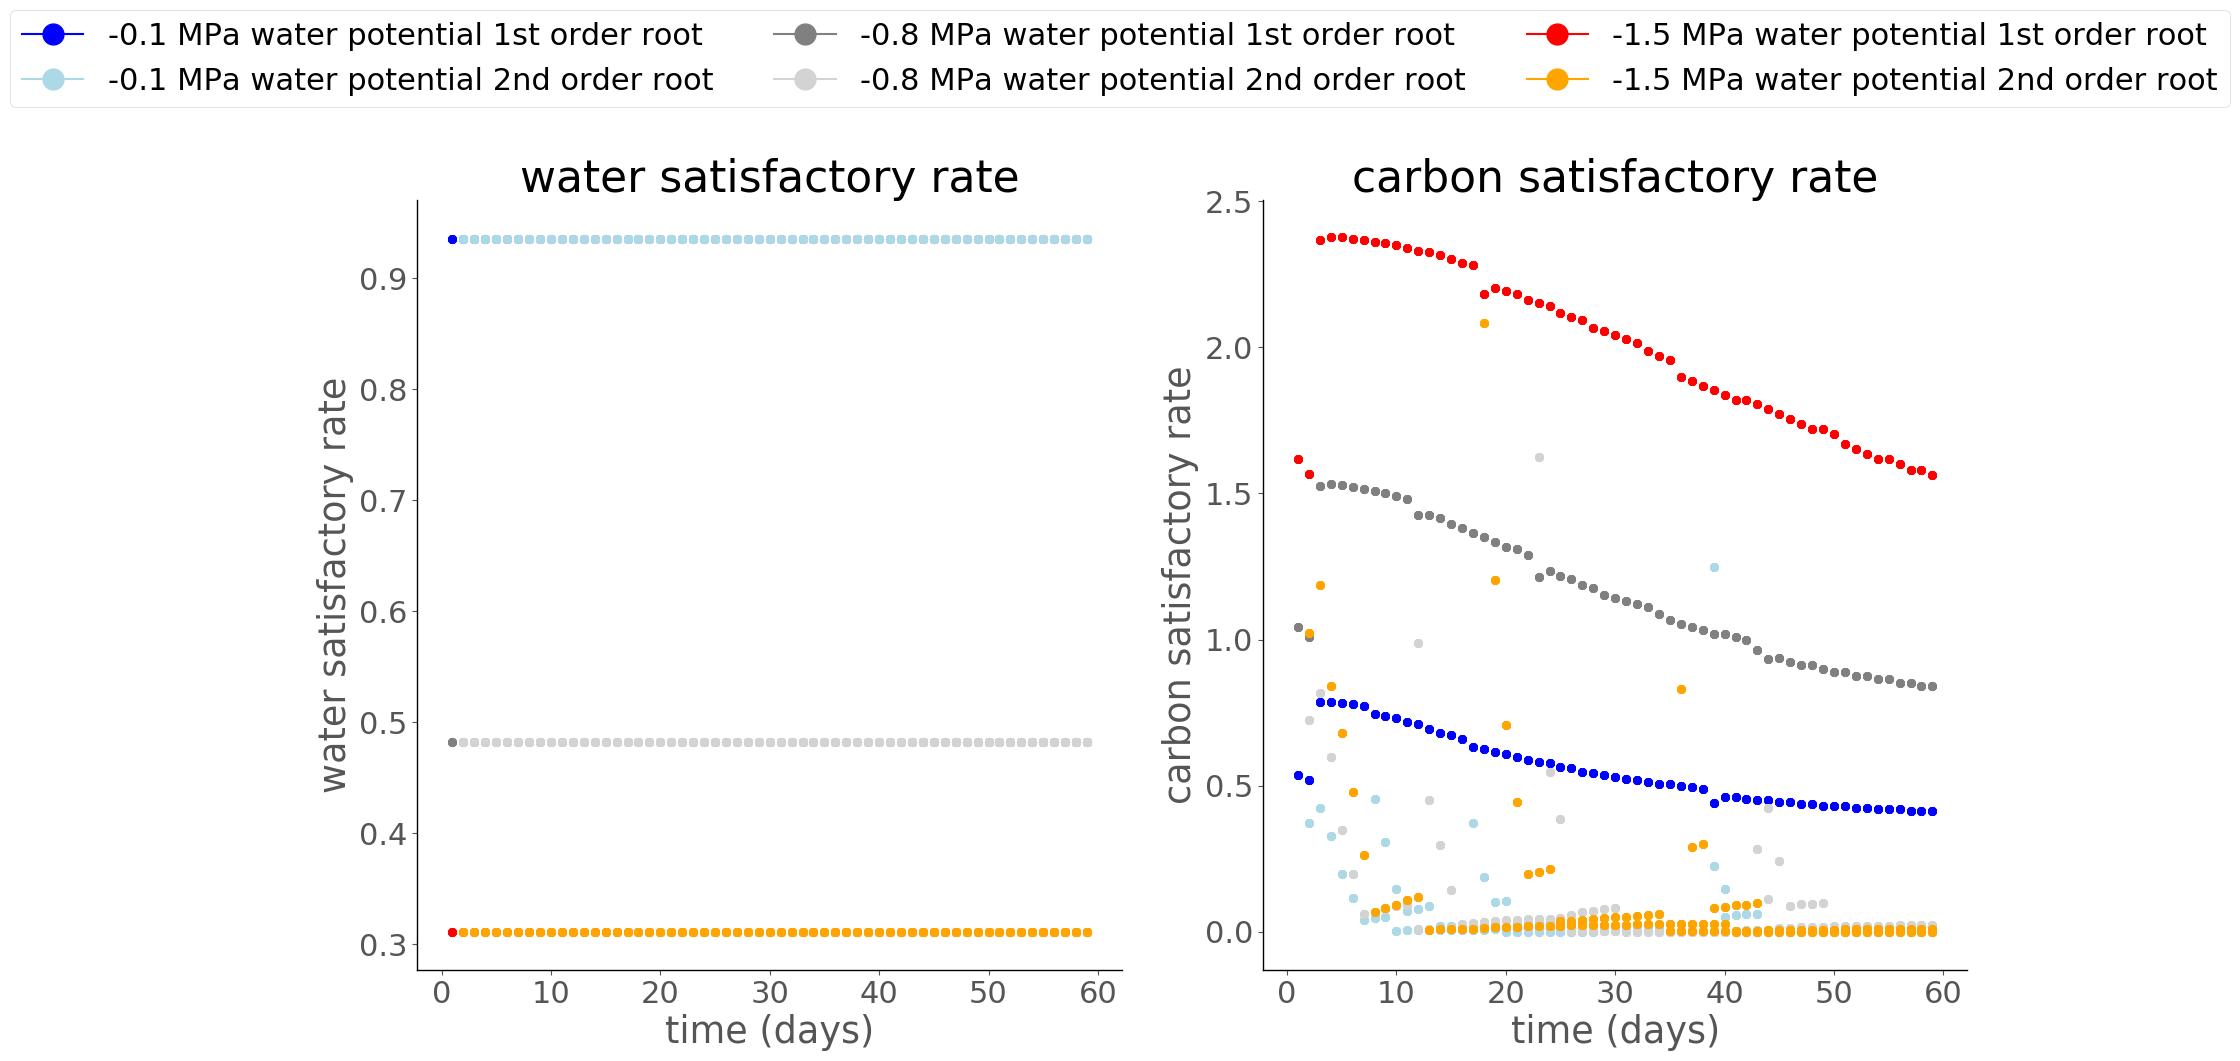

In [23]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(20,10))

#plt.title("individual attributes on root", pad = 30)
plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'lightblue', 'grey','lightgrey', 'red','orange'])))

a = 1
b = 2

ax1 = fig.add_subplot(a, b, 1)

ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("water satisfactory rate")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("water satisfactory rate")

# ax1.plot(df15[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
column = "rw_satis"

o1 = df01[column][df01[column]["order"] == 1]
o2= df01[column][df01[column]["order"] == 2]

ax1.scatter(o1["time"],o1[column])
ax1.scatter(o2["time"], o2[column])


o1 = df08[column][df08[column]["order"] == 1]
o2 = df08[column][df08[column]["order"] == 2]

ax1.scatter(o1["time"],o1[column])
ax1.scatter(o2["time"],o2[column])

o1 = df15[column][df15[column]["order"] == 1]
o2 = df15[column][df15[column]["order"] == 2]

ax1.scatter(o1["time"],o1[column])
ax1.scatter(o2["time"],o2[column])



ax1 = fig.add_subplot(a, b, 2)

ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("carbon satisfactory rate")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("carbon satisfactory rate")

# ax1.plot(df15[fig_colum_name].groupby(['time',"order"]).sum().unstack(),marker= "o")
column = "c_satis"

o1 = df01[column][df01[column]["order"] == 1]
o2= df01[column][df01[column]["order"] == 2]

ax1.scatter(o1["time"],o1[column])
ax1.scatter(o2["time"], o2[column])


o1 = df08[column][df08[column]["order"] == 1]
o2 = df08[column][df08[column]["order"] == 2]

ax1.scatter(o1["time"],o1[column])
ax1.scatter(o2["time"],o2[column])

o1 = df15[column][df15[column]["order"] == 1]
o2 = df15[column][df15[column]["order"] == 2]

ax1.scatter(o1["time"],o1[column])
ax1.scatter(o2["time"],o2[column])
blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 1st order root')
lightblue_line = mlines.Line2D([], [], color='lightblue', marker='o',
                          markersize=15, label='-0.1 MPa water potential 2nd order root')
grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 1st order root')
lightgrey_line = mlines.Line2D([], [], color='lightgrey', marker='o',
                          markersize=15, label='-0.8 MPa water potential 2nd order root')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential 1st order root')
orange_line = mlines.Line2D([], [], color='orange', marker='o',
                          markersize=15, label='-1.5 MPa water potential 2nd order root')

plt.legend(loc='lower left', bbox_to_anchor=(-1.8, 1.1, 0, 0),ncol=3, handles=[blue_line, lightblue_line, grey_line, lightgrey_line, red_line, orange_line])



fig.show()

In [77]:
df01["c_satis"][df01["c_satis"]["order"] == 2]

time  order   c_satis  organ_id  organ_id2
72        2      2  0.372825         1          5
79        2      2  0.372825         3          6
86        2      2  0.372825         5          7
162       3      2  0.421662         1          5
167       3      2  0.421662         3          6
172       3      2  0.421662         5          7
265       4      2  0.325971         1          5
272       4      2  0.325971         3          6
279       4      2  0.325971         5          7
400       5      2  0.196545         1          5
407       5      2  0.196545         3          6
414       5      2  0.196545         5          7
556       6      2  0.116923         1          5
561       6      2  0.116923         3          6
566       6      2  0.116923         5          7
723       7      2  0.039913         1          5
728       7      2  0.039913         3          6
733       7      2  0.039913         5          7
888       8      2  0.045482         1          5
893       8      2  0.045482         4          6
898       8      2  0.045482         7          7
906       8      2  0.453893         2         12
914       8      2  0.453893         5         13
922       8      2  0.453893         8         14
1077      9      2  0.050970         1          5
1082      9      2  0.050970         4          6
1087      9      2  0.050970         7          7
1117      9      2  0.305362         2         12
1123      9      2  0.305362         5         13
1129      9      2  0.305362         8         14
...     ...    ...       ...       ...        ...
19932    58      2  0.000898         2         12
19934    58      2  0.000898         8         13
19936    58      2  0.000898        14         14
19959    58      2  0.004012         3         15
19962    58      2  0.004012         9         16
19965    58      2  0.004012        15         17
19998    58      2 -0.000013         1          5
19999    58      2 -0.000013         7          6
20000    58      2 -0.000013        13          7
20047    58      2  0.007603         5         19
20049    58      2  0.007603        11         21
20051    58      2  0.007603        17         23
20058    58      2  0.009833         4         18
20059    58      2  0.009833        10         20
20060    58      2  0.009833        16         22
20403    59      2  0.000899         2         12
20405    59      2  0.000899         8         13
20407    59      2  0.000899        14         14
20430    59      2  0.004015         3         15
20433    59      2  0.004015         9         16
20436    59      2  0.004015        15         17
20469    59      2 -0.000013         1          5
20470    59      2 -0.000013         7          6
20471    59      2 -0.000013        13          7
20518    59      2  0.007609         5         19
20520    59      2  0.007609        11         21
20522    59      2  0.007609        17         23
20529    59      2  0.009840         4         18
20530    59      2  0.009840        10         20
20531    59      2  0.009840        16         22

[585 rows x 5 columns]

KeyError: 'organ_id'

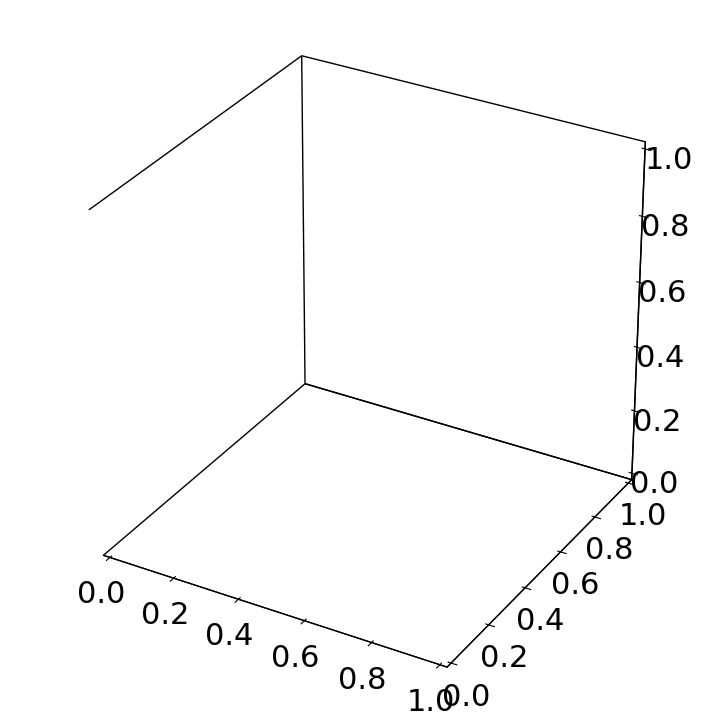

In [13]:
plt.style.use('default')
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
        
from cycler import cycler

plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})



plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'lightblue', 'grey','lightgrey', 'red','orange'])))


order1_root = df01["rw_satis"][df01["rw_satis"]["order"] == 1]
order2_root = df01["rw_satis"][df01["rw_satis"]["order"] == 2]

order1_root2 = df08["rw_satis"][df08["rw_satis"]["order"] == 1]
order2_root2 = df08["rw_satis"][df08["rw_satis"]["order"] == 2]

order1_root3 = df15["rw_satis"][df15["rw_satis"]["order"] == 1]
order2_root3 = df15["rw_satis"][df15["rw_satis"]["order"] == 2]

ax = fig.add_subplot(221, projection='3d')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

# Bonus: To get rid of the grid as well:
ax.grid(False)
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))



ax.w_zaxis.line.set_lw(1.)
# ax.invert_yaxis()
# ax.invert_xaxis()
ax.scatter(order1_root["time"], order1_root["organ_id"], order1_root["rw_satis"])
ax.scatter(order2_root["time"], order2_root["organ_id"], order2_root["rw_satis"])

ax.scatter(order1_root2["time"], order1_root2["organ_id"], order1_root2["rw_satis"])
ax.scatter(order2_root2["time"], order2_root2["organ_id"], order2_root2["rw_satis"])


ax.scatter(order1_root3["time"], order1_root3["organ_id"], order1_root3["rw_satis"])
ax.scatter(order2_root3["time"], order2_root3["organ_id"], order2_root3["rw_satis"])
ax.view_init(elev=20, azim=135)


ax = fig.add_subplot(222, projection='3d')
ax.scatter(order1_root["time"], order1_root["organ_id2"], order1_root["rw_satis"])
ax.scatter(order2_root["time"], order2_root["organ_id2"], order2_root["rw_satis"])

order1_root = df01["c_satis"][df01["c_satis"]["order"] == 1]
order2_root = df01["c_satis"][df01["c_satis"]["order"] == 2]

ax2 = fig.add_subplot(223, projection='3d')
ax2.scatter(order1_root["time"], order1_root["organ_id"], order1_root["c_satis"])
ax2.scatter(order2_root["time"],order2_root["organ_id"], order2_root["c_satis"])


ax2 = fig.add_subplot(224, projection='3d')
ax2.scatter(order1_root["time"], order1_root["organ_id2"], order1_root["c_satis"])
ax2.scatter(order2_root["time"], order2_root["organ_id2"], order2_root["c_satis"])



In [12]:
import plotly.graph_objects as go
from IPython.display import Image
from itertools import cycle
order1_root = df01["rw_satis"][df01["rw_satis"]["order"] == 1]
df = order1_root

colors = ['#531e7d', '#5e59b0', '#6d91bf', '#a7c0ca',  '#cfb19c', '#bf735d', '#9d3a4f',
          "rgb(255, 127, 14)",
          "rgb(44, 160, 44)",
          "rgb(214, 39, 40)"]

data =[go.Scatter3d(
        x=df['time'],
        y=df['organ_id'],
        z=df['rw_satis'],
        text=df['time'],
        textposition="top center",
        mode='markers',
        marker=dict(size=3,  color=colors),
        name=str(df['organ_id2'])
        )
    ]

h = 0.25
xm, xM = df['time'].min()-h, df['time'].max()+h
ym, yM = df['organ_id'].min()-h, df['organ_id'].max()+h
zm, zM = df['rw_satis'].min()-h, df['rw_satis'].max()+h

layout =go.Layout(width=600, height=600,
                  scene=dict(
                          xaxis =dict(range=[xm, xM]),
                          yaxis=dict(range=[ym, yM]),
                          zaxis=dict(range=[zm, zM]),
                  camera=dict(eye=dict(x=1.25, y=1.55, z= 1))),
                  
                 updatemenus=[dict(type='buttons', showactive=False,
                                y=0,
                                x=1.05,
                                xanchor='right',
                                yanchor='top',
                                pad=dict(t=0, r=10),
                                buttons=[dict(label='Play',
                                              method='animate',
                                              args=[None, 
                                                    dict(frame=dict(duration=50, 
                                                                    redraw=True),
                                                         transition=dict(duration=0),
                                                         fromcurrent=True,
                                                         mode='immediate')
                                                   ]
                                             )
                                        ]
                               )
                          ]     )

fig = go.Figure(data=data, layout=layout)
fig.show()
# fig.write_image("images/fig1.png")
# img_bytes = fig.to_image(format="png")
# Image(img_bytes)

KeyError: 'organ_id'

In [113]:
df = pd.read_csv("small_2020.xml_60_0.1_0.1_0.1.csv")


In [114]:
water_p_list = [[0.1, 0.1, 0.1], [0.8, 0.8, 0.8], [1.5, 1.5, 1.5], [1.5, 0.8, 0.1] , 
                [0.3, 0.3, 0.3] , [0.5, 0.5, 0.5] , [0.7, 0.7, 0.7] , [0.9, 0.9, 0.9], 
                [1.1, 1.1, 1.1] , [1.3, 1.3, 1.3] ,[1.5, 1.2, 0.6] , [1.5, 1.3, 0.7] ]
name = "small_2020.xml"
time_total = 60
name_list = []
for i, water_p in enumerate(water_p_list):
    water_dry, water_middle, water_wet =  water_p
    output_name = "{}_{}_{}_{}_{}".format(name, time_total, water_dry, water_middle, water_wet)
    name_list.append("{}.csv".format(output_name))

In [115]:
def read_filter(file_name):
    op_01 = pd.read_csv(file_name)
    gr_column = ["time", "order", "growth_rate"]
    op_01_gr = op_01[op_01["growth_rate"].notna()]
    op_01_gr =  op_01_gr[gr_column]


    ca_column = ["time", "order", "carbon_q"]
    op_01_ca = op_01[op_01["growth_rate"].notna()]
    op_01_ca =  op_01_ca[ca_column]

    len_column = ["time", "order", "organ_length"]
    op_01_len = op_01[op_01["growth_rate"].notna()]
    op_01_len =  op_01_len[len_column]
    
    len_column = ["time", "order", "exudation"]
    op_01_ex = op_01[op_01["growth_rate"].notna()]
    op_01_ex =  op_01_ex[len_column]
    
    len_column = ["time", "order", "rw_satis", "organ_id", "organ_id2"]
    op_01_ws = op_01[op_01["growth_rate"].notna()]
    op_01_ws =  op_01_ws[len_column]
    
# , "organ_id2", "id", "organ_type", "connection_1","connection_2"
    len_column = ["time", "order", "c_satis", "organ_id",  "organ_id2"]
    op_01_cs = op_01[op_01["growth_rate"].notna()]
    op_01_cs =  op_01_cs[len_column]
    
    
    df = {"growth_rate": op_01_gr, "carbon": op_01_ca, "length": op_01_len, 
          "exudation":op_01_ex ,"rw_satis":op_01_ws, "c_satis":op_01_cs }
    return df



In [26]:
name_list

['small_2020.xml_60_0.1_0.1_0.1.csv',
 'small_2020.xml_60_0.8_0.8_0.8.csv',
 'small_2020.xml_60_1.5_1.5_1.5.csv',
 'small_2020.xml_60_1.5_0.8_0.1.csv',
 'small_2020.xml_60_0.3_0.3_0.3.csv',
 'small_2020.xml_60_0.5_0.5_0.5.csv',
 'small_2020.xml_60_0.7_0.7_0.7.csv',
 'small_2020.xml_60_0.9_0.9_0.9.csv',
 'small_2020.xml_60_1.1_1.1_1.1.csv',
 'small_2020.xml_60_1.3_1.3_1.3.csv']

In [71]:
df["order"].astype(str).tolist()

['1',
 '1',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '1',
 '2',
 '2',
 '1',
 '2',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2'

In [73]:
def color_map(name):
    k = {"1":"red", "2":"blue" }
    return k[name]
c =list(map(color_map, df["order"].astype(str).tolist()))

In [46]:
len(all_trace)

24

In [14]:
from plotly.subplots import make_subplots
from itertools import cycle

all_trace = []
all_name = ["1st order wet root", "2st order wet root",
            "1st order medium root","2st order medium root",
            "1st order dry root","2st order dry root",
           "1st order wet root", "2st order wet root",
            "1st order medium root","2st order medium root",
            "1st order dry root","2st order dry root",
           "1st order wet root", "2st order wet root",
            "1st order medium root","2st order medium root",
            "1st order dry root","2st order dry root",
           "1st order wet root", "2st order wet root",
            "1st order medium root","2st order medium root",
            "1st order dry root","2st order dry root",]
for j,name in enumerate(name_list[0:3]):
    df = read_filter(name)
    df = df["rw_satis"]
    all_trace.append(df[df["order"] == 1])
    all_trace.append(df[df["order"] == 2])
for j,name in enumerate(name_list[0:3]):
    df = read_filter(name)
    df = df["rw_satis"]
    all_trace.append(df[df["order"] == 1])
    all_trace.append(df[df["order"] == 2])
    
    
for j,name in enumerate(name_list[0:3]):
    df = read_filter(name)
    df = df["c_satis"]
    all_trace.append(df[df["order"] == 1])
    all_trace.append(df[df["order"] == 2])
    
for j,name in enumerate(name_list[0:3]):
    df = read_filter(name)
    df = df["c_satis"]
    all_trace.append(df[df["order"] == 1])
    all_trace.append(df[df["order"] == 2])
fig =  make_subplots(rows=2, cols=2,
                    specs=[[{'is_3d': True},{'is_3d': True} ], [{'is_3d': True}, {'is_3d': True}]],
                    print_grid=False, subplot_titles=["water satisfactory rate getOrgan", 
                                                      
                                                      "carbon satisfactory rate getOrgan",
                                                       "water satisfactory rate organId",
                                                       "carbon satisfactory rate organId"],
                    horizontal_spacing = 0.1,
                     vertical_spacing = 0.1,
                    
                    )
column_list = ["rw_satis","rw_satis","rw_satis","rw_satis","rw_satis","rw_satis",              
               "rw_satis","rw_satis","rw_satis","rw_satis","rw_satis","rw_satis",
                "c_satis","c_satis","c_satis","c_satis" , "c_satis","c_satis","c_satis","c_satis" ,
               "c_satis","c_satis","c_satis","c_satis", "c_satis","c_satis","c_satis","c_satis" ]  
order_list = [1,2,1,2,1,2,
              1,2,1,2,1,2,
              1,2,1,2,1,2,
              1,2,1,2,1,2
             ]

f_row = [1,1,1,1,1,1,
        2,2,2,2,2,2,
        1,1,1,1,1,1,
        2,2,2,2,2,2]
f_column = [1,1,1,1,1,1,
            1,1,1,1,1,1,
            2,2,2,2,2,2, 
            2,2,2,2,2,2,]

organ_name = ["organ_id","organ_id","organ_id","organ_id","organ_id","organ_id",
             "organ_id2","organ_id2","organ_id2","organ_id2","organ_id2","organ_id2",
             "organ_id","organ_id","organ_id","organ_id","organ_id","organ_id",
             "organ_id2","organ_id2","organ_id2","organ_id2","organ_id2","organ_id2",]

color_name = ["blue" ,"lightblue","darkgrey","lightgrey","red","orange",
             "blue" ,"lightblue","darkgrey","lightgrey","red","orange",
              "blue" ,"lightblue","darkgrey","lightgrey","red","orange",
              "blue" ,"lightblue","darkgrey","lightgrey","red","orange",
            
             ]

for j,df in enumerate(all_trace):

#     k = [{"1":"#1f77b4", "2":"#419ede" }, {"1":"#1c2f2f", "2":"#4c7f7f" }, {"1" : "#73141d", "2" : "#de4150"}]
   



    fig.add_trace(
        go.Scatter3d(
            x=df["time"],
            y=df[organ_name[j]],
            z=df[column_list[j]],
#             mode='lines+markers',
            mode='markers',
#             line={"color":cm[df["rw_satis"]], "width" : 8},
            marker=dict(
            color= color_name[j],
            size=2,
            line=dict(
                color=color_name[j],
                width=1)
        ),
            name=all_name[j]
            
     
    ),
           row=f_row[j], col=f_column[j]
    )
        


        
# fig.update_layout(title = 'Locales', width=1950, height=750, plot_bgcolor='rgb(255,255,255)')

scence = dict(
                    xaxis = dict(
                         backgroundcolor="rgb(250, 250, 250)",
                         gridcolor="lightgrey",
                         showbackground=True,
                         zerolinecolor="black",),
                    yaxis = dict(
                        backgroundcolor="rgb(250, 250,250)",
                        gridcolor="lightgrey",
                        showbackground=True,
                        zerolinecolor="black"),
                    zaxis = dict(
                        backgroundcolor="rgb(250, 250,250)",
                        gridcolor="lightgrey",
                        showbackground=True,
                        zerolinecolor="black",),)
# fig.update_layout(scene = scence,
#                     width=700,
#                     margin=dict(
#                     r=10, l=10,
#                     b=10, t=10)
#                   )

# fig.update_layout(scene2 = scence,
#                     width=700,
#                     margin=dict(
#                     r=10, l=10,
#                     b=10, t=10)
#                   )


# fig.update_layout(scene3 = scence,
#                     width=1800,
#                     margin=dict(
#                     r=10, l=10,
#                     b=10, t=10)
#                   )


# camera = dict(
# eye=dict(x=0, y=2, z=0.1))
    

# fig.update_layout(scene_camera=camera)
# fig.update_layout(scene2_camera=camera)
# fig.update_layout(scene3_camera=camera)

fig.update_layout(autosize=True, 
                  legend = {"font" : dict( size= 10 ), "itemsizing" : "constant",},
                  scene = dict(
                    xaxis_title='Time ',
                    yaxis_title='Organ Id',
                    zaxis_title=' Water Satisfactory Ratio'),
                    width=1000,
                    height = 750,

                    margin=dict(r=5, b=5, l=5, t=40), title_text= "plant structure by order")


fig.show()

In [57]:
map(color_map, df["order"])

In [17]:
df =  pd.read_csv(name_list[0])

In [24]:
df.head()

time  id  organ_type  sub_type  connect_no  organ_id  organ_id2  \
0     1   1           2         1           4         0          0   
1     1   2           2         1           2         0          1   
2     1   3           2         1           2         0          1   
3     1   4           2         1           2         0          1   
4     1   5           2         1           2         0          1   

   parent_organ  length  res_main      ...       c_demand_2  growth_rate  \
0             0  0.0000  0.000000      ...              NaN          NaN   
1             0  0.0025  0.000035      ...              NaN          NaN   
2             0  0.0050  0.000035      ...              NaN          NaN   
3             0  0.0075  0.000035      ...              NaN          NaN   
4             0  0.0100  0.000035      ...              NaN          NaN   

   exudation  order  organ_length    coor_x    coor_y    coor_z  connection_1  \
0        NaN      1           NaN  0.000000  0.000000 -0.020000           1.0   
1        NaN      1           NaN  0.000926  0.001857 -0.021393           2.0   
2        NaN      1           NaN  0.001541  0.003610 -0.023067           3.0   
3        NaN      1           NaN  0.001944  0.005198 -0.024956           4.0   
4        NaN      1           NaN  0.002746  0.006135 -0.027130           5.0   

   connection_2  
0           2.0  
1           3.0  
2           4.0  
3           5.0  
4           6.0  

[5 rows x 24 columns]

In [25]:
df.groupby(["time"],["organ_id"])

TypeError: unhashable type: 'list'

In [ ]:

organ_number = df[df["time"] ==t]["organ_id"].max()
features = []
organs = []
orders = []
df = test.sort_index()

for i in range(organ_number+1):
    corx=df[df["time"] ==t ][df["organ_id"] == i]["coor_x"].tolist()
    cory=df[df["time"] ==t ][df["organ_id"] == i]["coor_y"].tolist()
    corz=df[df["time"] ==t ][df["organ_id"] == i]["coor_z"].tolist()
    organ_id=df[df["time"] ==t ][df["organ_id"] == i]["organ_id"].tolist()
    order=df[df["time"] ==t ][df["organ_id"] == i]["order"].tolist()

    features.append([corx, cory, corz])
    organs.append(organ_id)
    orders.append(order)




In [ ]:
name_list[0:3]

In [117]:
from plotly.subplots import make_subplots
from itertools import cycle




def plotly_color_map(names):

    plotly_colors = cycle(['#1f77b4',  # muted blue
                           '#ff7f0e',  # safety orange
                           '#2ca02c',  # cooked asparagus green
                           '#d62728',  # brick red
                           
                           ])

    return dict(zip(names, plotly_colors))


fig =  make_subplots(rows=1, cols=3,
                    specs=[[{'is_3d': True}, {'is_3d': True},{'is_3d': True}]],
                    print_grid=False, subplot_titles=("wet root","medium root", "dry root") )




for j,name in enumerate(name_list[0:3]):
    df = pd.read_csv(name)
    t = 59
    test = df[df["time"] ==t ]
    organ_number = df[df["time"] ==t]["organ_id"].max()
    features = []
    organs = []
    orders = []


    for i in range(organ_number+1):
        ogs = test[test["organ_id"] == i]
        missing_2nd_id = ogs[ogs["id"] == ogs["id"].min()]["id"].tolist()[0]
    #     print(   i, missing_2nd_id)
        if test[test["id"] == missing_2nd_id]["organ_type"].tolist()[0] < 3:
            missing_1st_id = test[test["connection_2"] == missing_2nd_id]["connection_1"].tolist()[0]
        else:
            missing_1st_id = test[test["connection_1"] == missing_2nd_id]["connection_2"].tolist()[0]
        missing_node = test[test["id"] == missing_1st_id]
        ms = missing_node.copy(deep=True)
    #     print(ms["id"].tolist())
        ms.loc[:,"organ_id"]= i
    #     print(ms)
        test=test.append(ms)


    df = test.sort_index()

    for i in range(organ_number+1):
        corx=df[df["time"] ==t ][df["organ_id"] == i]["coor_x"].tolist()
        cory=df[df["time"] ==t ][df["organ_id"] == i]["coor_y"].tolist()
        corz=df[df["time"] ==t ][df["organ_id"] == i]["coor_z"].tolist()
        organ_id=df[df["time"] ==t ][df["organ_id"] == i]["organ_id"].tolist()
        order=df[df["time"] ==t ][df["organ_id"] == i]["order"].tolist()

        features.append([corx, cory, corz])
        organs.append(organ_id)
        orders.append(order)






    # features = [np.random.rand(4,2).tolist(), 
    #             np.random.rand(5,2).tolist(), 
    #             np.random.rand(6,2).tolist(), 
    #             np.random.rand(5,2).tolist(), 
    #             np.random.rand(9,2).tolist()]

    # labels = [[1, 1, 1, 1],
    #           [1, 1, 1, 1, 1],
    #           [2, 2, 2, 2, 2, 2],
    #           [2, 2, 2, 2, 2],
    #           [0, 0, 0, 0, 0, 0, 0, 0, 0]]

    legend_groups = [l[1] for l in orders]

    traces = [False if (len(legend_groups[:i])>0 and l in legend_groups[:i]) 
              else True for i, l in enumerate(legend_groups)]

    cm = plotly_color_map(set(legend_groups))




    for i, feat in enumerate(features):
        feat = np.array(feat)
        fig.add_trace(
            go.Scatter3d(
                x=feat[0,:],
                y=feat[1,:],
                z=feat[2,:],
    #             mode='lines+markers',
                mode='lines',
                line={"color":cm[legend_groups[i]], "width" : 8},
    #             marker=dict(
    #             color=cm[legend_groups[i]],
    #             size=0,
    #             line=dict(
    #                 color='MediumPurple',
    #                 width=0
    #             )
    #         ),
                legendgroup=legend_groups[i],
                hovertext=orders[i],
                showlegend=traces[i],
                name="label_{}".format(legend_groups[i]),
            ),
            row=1, col=j+1
        )
        


        
# fig.update_layout(title = 'Locales', width=1950, height=750, plot_bgcolor='rgb(255,255,255)')

scence = dict(
                    xaxis = dict(
                         backgroundcolor="rgb(250, 250, 250)",
                         gridcolor="lightgrey",
                         showbackground=True,
                         zerolinecolor="black",),
                    yaxis = dict(
                        backgroundcolor="rgb(250, 250,250)",
                        gridcolor="lightgrey",
                        showbackground=True,
                        zerolinecolor="black"),
                    zaxis = dict(
                        backgroundcolor="rgb(250, 250,250)",
                        gridcolor="lightgrey",
                        showbackground=True,
                        zerolinecolor="black",),)
fig.update_layout(scene = scence,
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )

fig.update_layout(scene2 = scence,
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )


fig.update_layout(scene3 = scence,
                    width=1800,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )


camera = dict(
eye=dict(x=0, y=2, z=0.1))
    

fig.update_layout(scene_camera=camera)
fig.update_layout(scene2_camera=camera)
fig.update_layout(scene3_camera=camera)

fig.update_layout(autosize=False, scene = dict(
                    xaxis_title='X AXIS ',
                    yaxis_title='Y AXIS ',
                    zaxis_title='Z AXIS '),
                    width=1000,
                    margin=dict(r=20, b=20, l=20, t=50), title_text= "plant structure by order")

fig.show()

In [2]:
plotly_colors = [['blue',  'lightblue' ], 
                          [ 'darkgrey',  
                           'lightgrey'] ,
                          [ 'red',  
                           'orange']  
                           ]

In [118]:
from plotly.subplots import make_subplots
from itertools import cycle


plotly_colors = [['blue',  'lightblue' ], 
                          [ 'darkgrey',  
                           'lightgrey'] ,
                          [ 'red',  
                           'orange']  
                           ]



fig =  make_subplots(rows=1, cols=3,
                    specs=[[{'is_3d': True}, {'is_3d': True},{'is_3d': True}]],
                    print_grid=False, subplot_titles=("wet root","medium root", "dry root") )




for j,name in enumerate(name_list[0:3]):
    def plotly_color_map(names):
        return dict(zip(names, plotly_colors[j]))
    df = pd.read_csv(name)
    t = 59
    test = df[df["time"] ==t ]
    organ_number = df[df["time"] ==t]["organ_id"].max()
    features = []
    organs = []
    orders = []


    for i in range(organ_number+1):
        ogs = test[test["organ_id"] == i]
        missing_2nd_id = ogs[ogs["id"] == ogs["id"].min()]["id"].tolist()[0]
    #     print(   i, missing_2nd_id)
        if test[test["id"] == missing_2nd_id]["organ_type"].tolist()[0] < 3:
            missing_1st_id = test[test["connection_2"] == missing_2nd_id]["connection_1"].tolist()[0]
        else:
            missing_1st_id = test[test["connection_1"] == missing_2nd_id]["connection_2"].tolist()[0]
        missing_node = test[test["id"] == missing_1st_id]
        ms = missing_node.copy(deep=True)
    #     print(ms["id"].tolist())
        ms.loc[:,"organ_id"]= i
    #     print(ms)
        test=test.append(ms)


    df = test.sort_index()

    for i in range(organ_number+1):
        corx=df[df["time"] ==t ][df["organ_id"] == i]["coor_x"].tolist()
        cory=df[df["time"] ==t ][df["organ_id"] == i]["coor_y"].tolist()
        corz=df[df["time"] ==t ][df["organ_id"] == i]["coor_z"].tolist()
        organ_id=df[df["time"] ==t ][df["organ_id"] == i]["organ_id"].tolist()
        order=df[df["time"] ==t ][df["organ_id"] == i]["order"].tolist()

        features.append([corx, cory, corz])
        organs.append(organ_id)
        orders.append(order)






    # features = [np.random.rand(4,2).tolist(), 
    #             np.random.rand(5,2).tolist(), 
    #             np.random.rand(6,2).tolist(), 
    #             np.random.rand(5,2).tolist(), 
    #             np.random.rand(9,2).tolist()]

    # labels = [[1, 1, 1, 1],
    #           [1, 1, 1, 1, 1],
    #           [2, 2, 2, 2, 2, 2],
    #           [2, 2, 2, 2, 2],
    #           [0, 0, 0, 0, 0, 0, 0, 0, 0]]

    legend_groups = [l[1] for l in orders]

    traces = [False if (len(legend_groups[:i])>0 and l in legend_groups[:i]) 
              else True for i, l in enumerate(legend_groups)]

    cm = plotly_color_map(set(legend_groups))




    for i, feat in enumerate(features):
        feat = np.array(feat)
        fig.add_trace(
            go.Scatter3d(
                x=feat[0,:],
                y=feat[1,:],
                z=feat[2,:],
    #             mode='lines+markers',
                mode='lines',
                line={"color":cm[legend_groups[i]], "width" : 8},
    #             marker=dict(
    #             color=cm[legend_groups[i]],
    #             size=0,
    #             line=dict(
    #                 color='MediumPurple',
    #                 width=0
    #             )
    #         ),
                legendgroup=legend_groups[i],
                hovertext=orders[i],
                showlegend=traces[i],
                name="{} order root".format(legend_groups[i]),
            ),
            row=1, col=j+1
        )
        


        
# fig.update_layout(title = 'Locales', width=1950, height=750, plot_bgcolor='rgb(255,255,255)')

scence = dict(
                    xaxis = dict(
                         backgroundcolor="rgb(250, 250, 250)",
                         gridcolor="lightgrey",
                         showbackground=True,
                         zerolinecolor="black",),
                    yaxis = dict(
                        backgroundcolor="rgb(250, 250,250)",
                        gridcolor="lightgrey",
                        showbackground=True,
                        zerolinecolor="black"),
                    zaxis = dict(
                        backgroundcolor="rgb(250, 250,250)",
                        gridcolor="lightgrey",
                        showbackground=True,
                        zerolinecolor="black",),)
fig.update_layout(scene = scence,
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )

fig.update_layout(scene2 = scence,
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )


fig.update_layout(scene3 = scence,
                    width=1800,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )


camera = dict(
eye=dict(x=0, y=2, z=0.1))
    

fig.update_layout(scene_camera=camera)
fig.update_layout(scene2_camera=camera)
fig.update_layout(scene3_camera=camera)

fig.update_layout(autosize=False, scene = dict(
                    xaxis_title='X AXIS ',
                    yaxis_title='Y AXIS ',
                    zaxis_title='Z AXIS '),
                    width=1000,
                    margin=dict(r=20, b=20, l=20, t=50), title_text= "plant structure by order")

fig.show()

In [202]:
legend_groups

[-1.5,
 -0.1,
 -0.1,
 -0.1,
 -0.8,
 -0.8,
 -1.5,
 -0.8,
 -0.1,
 -1.5,
 -0.8,
 -0.8,
 -1.5,
 -0.1,
 -0.1,
 -0.8,
 nan,
 nan,
 nan]

In [201]:
waters

[[nan, nan, nan, nan, nan, nan, nan, nan],
 [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  -1.5],
 [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  n

{-0.1: 'blue', -0.8: 'lightblue', nan: 'red', nan: 'orange'}

In [45]:
from plotly.subplots import make_subplots
from itertools import cycle


water_p_list = [[0.1, 0.1, 0.1], [0.8, 0.8, 0.8], [1.5, 1.5, 1.5], [1.5, 0.8, 0.1] , 
                [0.3, 0.3, 0.3] , [0.5, 0.5, 0.5] , [0.7, 0.7, 0.7] , [0.9, 0.9, 0.9], 
                [1.1, 1.1, 1.1] , [1.3, 1.3, 1.3] ,[1.5, 1.2, 0.6] , [1.5, 1.3, 0.7] ]
name = "small_2020.xml"
time_total = 60
name_list = []
for i, water_p in enumerate(water_p_list):
    water_dry, water_middle, water_wet =  water_p
    output_name = "{}_{}_{}_{}_{}".format(name, time_total, water_dry, water_middle, water_wet)
    name_list.append("{}.csv".format(output_name))


plotly_colors = [['blue', 'darkgreen',"lightgreen",  'lightgreen' , "darkgrey",  
                           'red'], 
                          [ 'darkgrey',  
                           'lightgrey'] ,
                          [ 'red',  
                           'orange']  
                           ]



fig =  make_subplots(rows=1, cols=3,
                    specs=[[{'is_3d': True}, {'is_3d': True},{'is_3d': True}]],
                    print_grid=False, subplot_titles=("wet root","medium root", "dry root") )


nnn=59
# def runfig(nnn):
for j,name in enumerate(name_list[11:12]):
    def plotly_color_map(names):
        return dict(zip(names, plotly_colors[j]))
    df = pd.read_csv(name)
    t = nnn
    test = df[df["time"] ==t ]
    organ_number = df[df["time"] ==t]["organ_id"].max()
    features = []
    organs = []
    orders = []
    waters = []

    i =0
    for i in range(int(organ_number)+1):
        ogs = test[test["organ_id"] == i]
        missing_2nd_id = ogs[ogs["id"] == ogs["id"].min()]["id"].tolist()[0]
    #     print(   i, missing_2nd_id)
        if test[test["id"] == missing_2nd_id]["organ_type"].tolist()[0] < 3:
            missing_1st_id = test[test["connection_2"] == missing_2nd_id]["connection_1"].tolist()[0]
        else:
            missing_1st_id = test[test["connection_1"] == missing_2nd_id]["connection_2"].tolist()[0]
        missing_node = test[test["id"] == missing_1st_id]
        ms = missing_node.copy(deep=True)
    #     print(ms["id"].tolist())
        ms.loc[:,"organ_id"]= i
    #     print(ms)
        test=test.append(ms)


    df = test.sort_index()

    for i in range(organ_number+1):
        corx=df[df["time"] ==t ][df["organ_id"] == i]["coor_x"].tolist()
        cory=df[df["time"] ==t ][df["organ_id"] == i]["coor_y"].tolist()
        corz=df[df["time"] ==t ][df["organ_id"] == i]["coor_z"].tolist()
        organ_id=df[df["time"] ==t ][df["organ_id"] == i]["organ_id"].tolist()
        order=df[df["time"] ==t ][df["organ_id"] == i]["order"].tolist()
        water=df[df["time"] ==t ][df["organ_id"] == i]["root_water"].tolist()

        features.append([corx, cory, corz])
        organs.append(organ_id)
        orders.append(order)
        waters.append(water)



    legend_groups = [l[-1] for l in waters]

    traces = [False if (len(legend_groups[:i])>0 and l in legend_groups[:i]) 
              else True for i, l in enumerate(legend_groups)]

    cm = plotly_color_map(set(legend_groups))




    for i, feat in enumerate(features):
        feat = np.array(feat)
        fig.add_trace(
            go.Scatter3d(
                x=feat[0,:],
                y=feat[1,:],
                z=feat[2,:],
    #             mode='lines+markers',
                mode='lines',
                line={"color":cm[legend_groups[i]], "width" : 8},
    #             marker=dict(
    #             color=cm[legend_groups[i]],
    #             size=0,
    #             line=dict(
    #                 color='MediumPurple',
    #                 width=0
    #             )
    #         ),
                legendgroup=legend_groups[i],
                hovertext=orders[i],
                showlegend=traces[i],
                name="{} water potential root".format(legend_groups[i]),
            ),
            row=1, col=j+1
        )




# fig.update_layout(title = 'Locales', width=1950, height=750, plot_bgcolor='rgb(255,255,255)')

scence = dict(
                    xaxis = dict(
                         backgroundcolor="rgb(250, 250, 250)",
                         gridcolor="lightgrey",
                         showbackground=True,
                         zerolinecolor="black",),
                    yaxis = dict(
                        backgroundcolor="rgb(250, 250,250)",
                        gridcolor="lightgrey",
                        showbackground=True,
                        zerolinecolor="black"),
                    zaxis = dict(
                        backgroundcolor="rgb(250, 250,250)",
                        gridcolor="lightgrey",
                        showbackground=True,
                        zerolinecolor="black",),)
fig.update_layout(scene = scence,
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )

fig.update_layout(scene2 = scence,
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )


fig.update_layout(scene3 = scence,
                    width=1800,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )


camera = dict(
eye=dict(x=0, y=2, z=-0.3))


fig.update_layout(scene_camera=camera)
fig.update_layout(scene2_camera=camera)
fig.update_layout(scene3_camera=camera)

fig.update_layout(autosize=False, scene = dict(
                    xaxis_title='X AXIS ',
                    yaxis_title='Y AXIS ',
                    zaxis_title='Z AXIS '),
                    width=1000,
                    margin=dict(r=20, b=20, l=20, t=50), title_text= "plant structure by order")

fig.show()

In [67]:
i=0
for nnn in range(59,59):
    runfig(nnn)

In [13]:
df[df["time"] == 59].count()

time            472
id              472
organ_type      472
sub_type        472
connect_no      472
organ_id        472
organ_id2       472
parent_organ    472
length          472
res_main        472
carbon_q        472
c_satis          16
root_water       16
rw_satis         16
c_demand_2       16
growth_rate      16
exudation        16
order           472
organ_length     16
coor_x          472
coor_y          472
coor_z          472
connection_1    471
connection_2    471
dtype: int64

In [2]:
# df = pd.read_csv("small_2020.xml_60_1.5_0.8_0.1.csv")

df = pd.read_csv("small_2020.xml_60_1.5_1.2_0.6.csv")

In [4]:
df[df["time"] == 59][df["root_water"] == -1.5]

/home/zxrzxr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



time   id  organ_type  sub_type  connect_no  organ_id  organ_id2  \
18679    59  373           2         2           1        12         14   
18680    59  374           2         2           1        13         17   
18688    59  382           2         2           1        15         21   
18707    59  401           2         2           1        11          7   
18726    59  420           2         2           1        14         20   
18754    59  448           2         4           1        10          3   

       parent_organ    length  res_main      ...       c_demand_2  \
18679             3  0.097572  0.000002      ...         0.001101   
18680             3  0.153665  0.000002      ...         0.001101   
18688             3  0.209163  0.000002      ...         0.000567   
18707             3  0.042510  0.000002      ...         0.000567   
18726             3  0.207987  0.000002      ...         0.000366   
18754             0  0.230028  0.000035      ...         0.012103   

        growth_rate  exudation  order  organ_length    coor_x    coor_y  \
18679  1.963960e-04    0.00000      2      2.757224  0.040285 -0.015506   
18680  2.083018e-03    0.00000      2      2.366490  0.053504 -0.066591   
18688  3.040116e-03    0.00000      2      1.847108  0.071133 -0.045479   
18707  7.223741e-07    0.00000      2      3.251015  0.006011  0.000968   
18726  4.446373e-03    0.00000      2      1.798701  0.042988 -0.032710   
18754  9.631654e-01    0.00033      1     23.002848  0.050120 -0.038662   

         coor_z  connection_1  connection_2  
18679 -0.088224         107.0         122.0  
18680 -0.123702         122.0         123.0  
18688 -0.189839         198.0         199.0  
18707 -0.057309         364.0         365.0  
18726 -0.191994          29.0          28.0  
18754 -0.221473         126.0         111.0  

[6 rows x 24 columns]

/home/zxrzxr/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



time
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
15    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
17    AxesSubplot(0.125,0.125;0.775x0.755)
18    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
20    AxesSubplot(0.125,0.125;0.775x0.755)
21    AxesSubplot(0.125,0.125;0.775x0.755)
22    AxesSubplot(0.125,0.125;0.775x0.755)
23    AxesSubplot(0.125,0.125;0.775x0.755)
24    

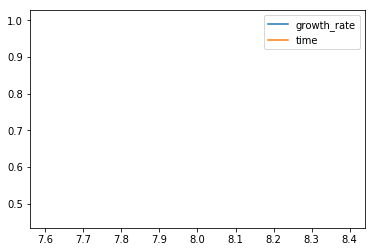

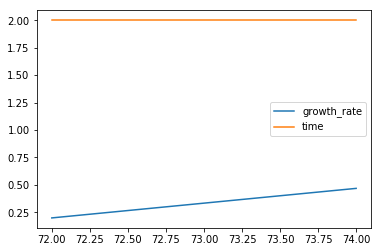

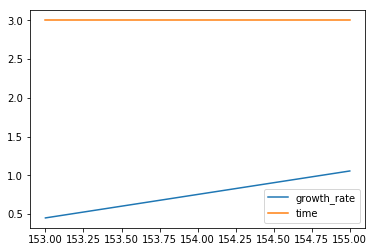

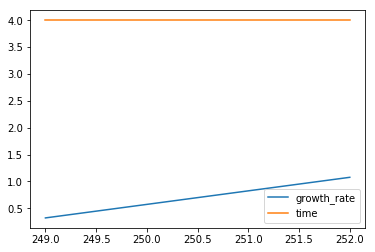

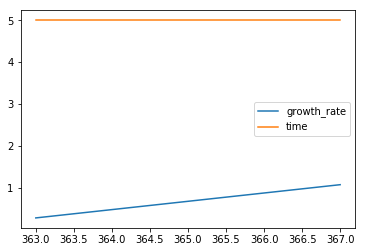

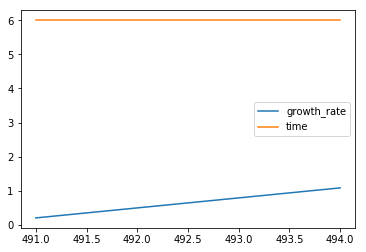

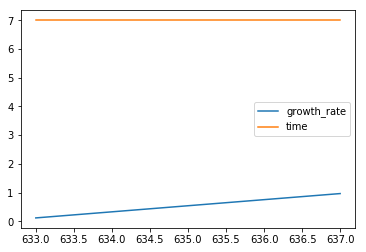

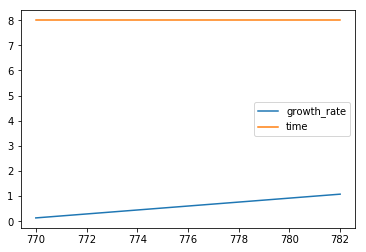

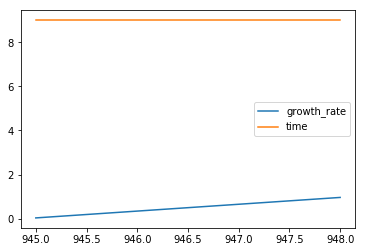

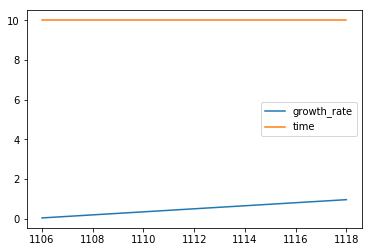

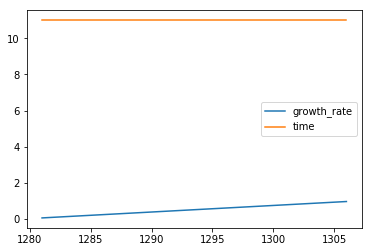

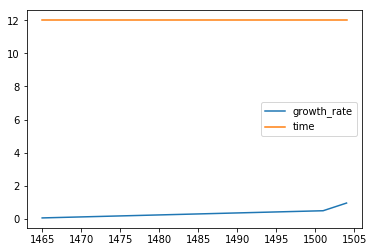

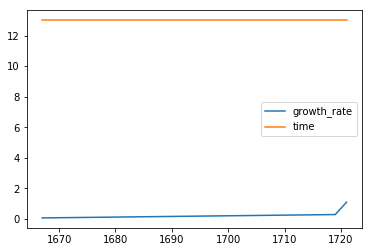

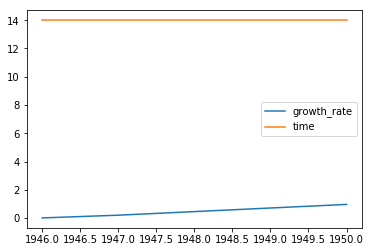

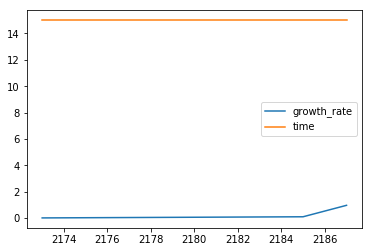

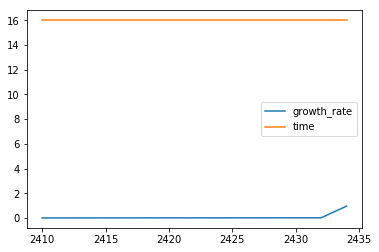

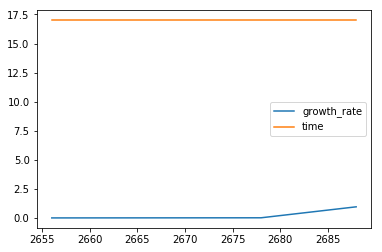

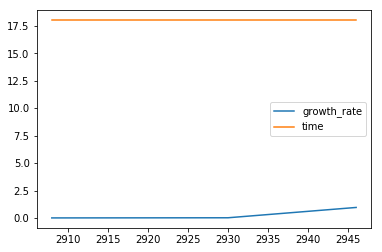

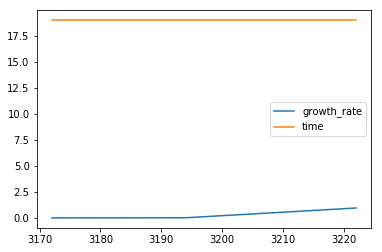

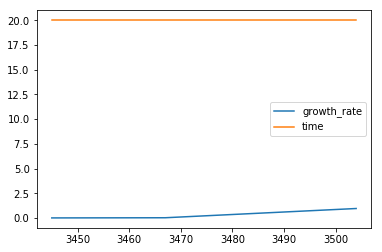

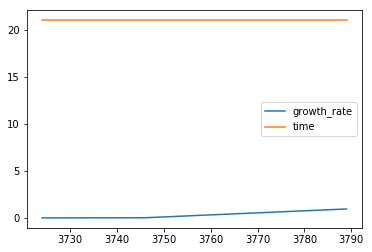

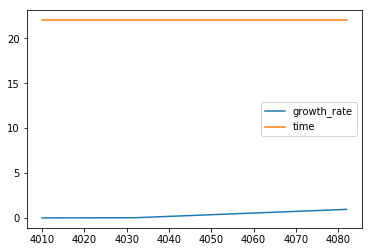

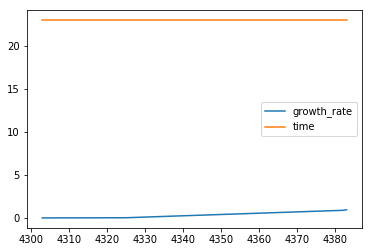

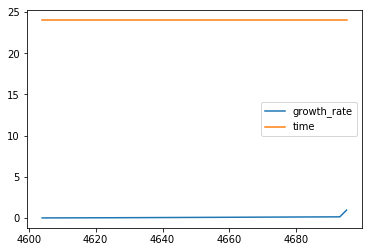

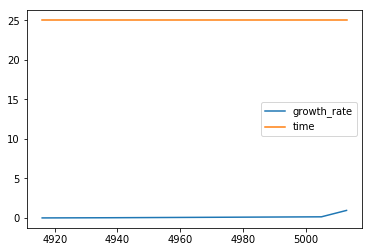

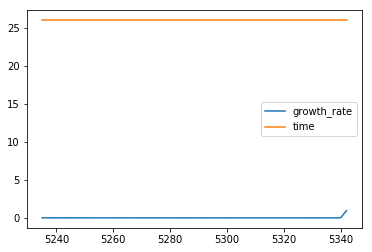

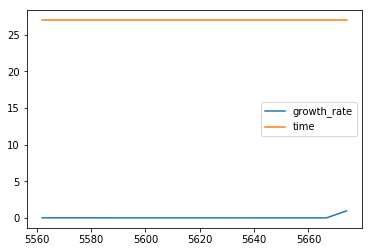

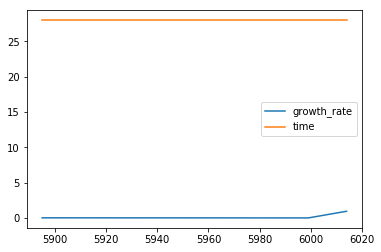

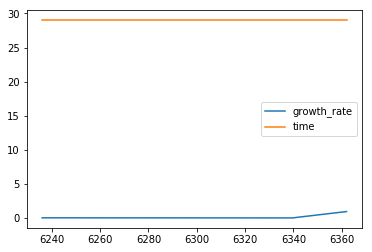

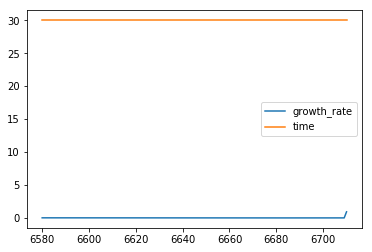

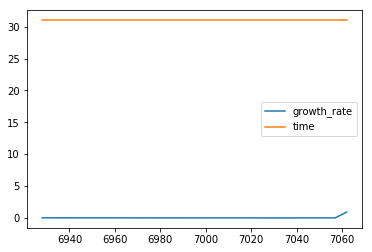

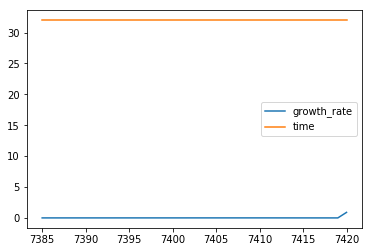

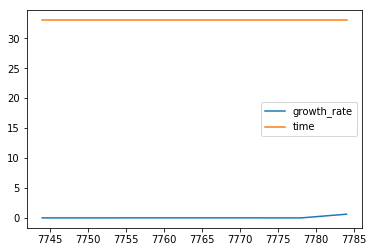

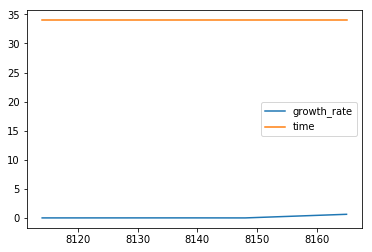

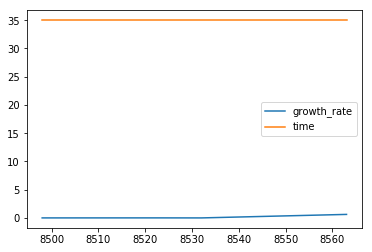

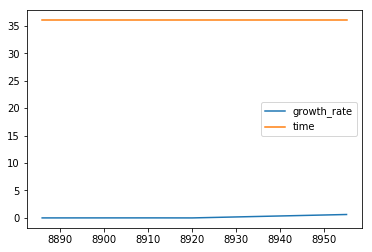

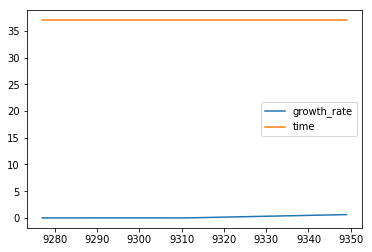

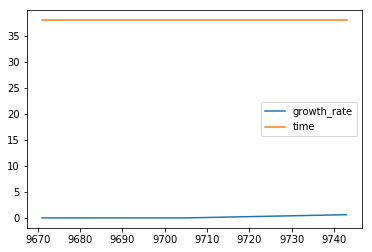

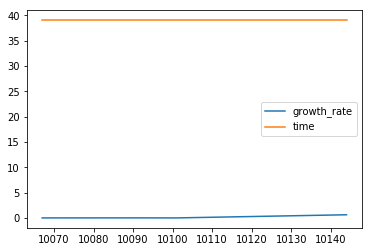

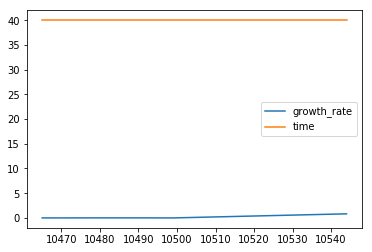

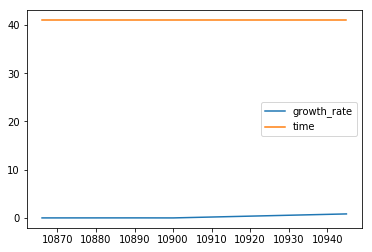

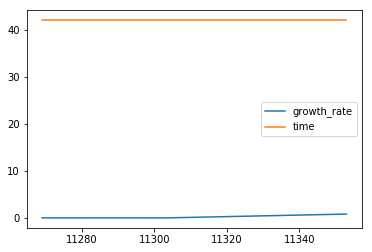

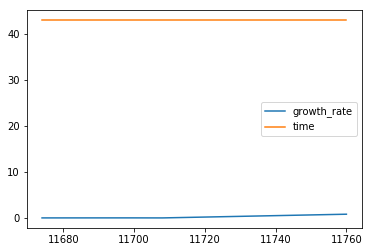

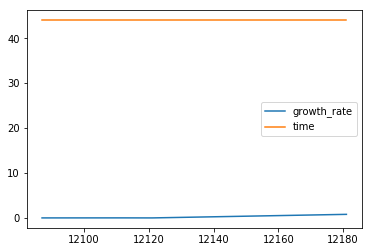

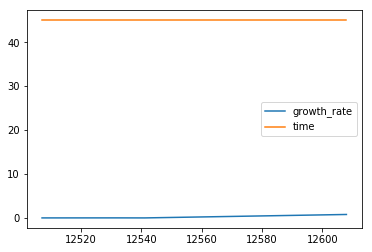

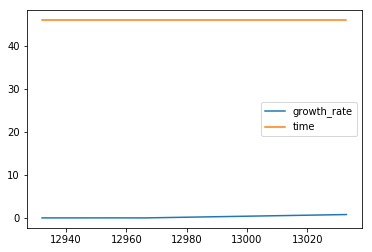

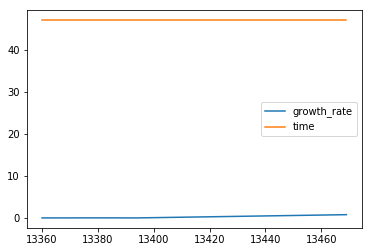

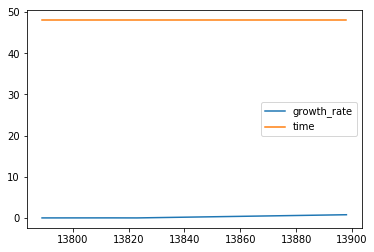

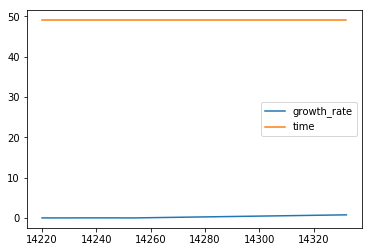

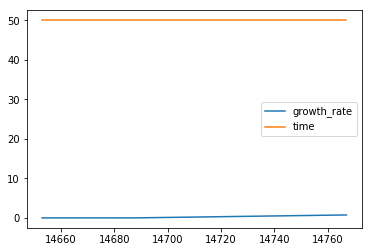

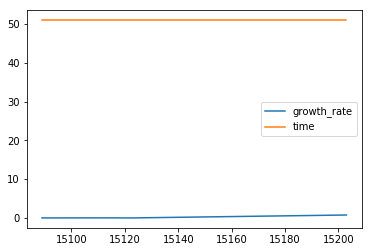

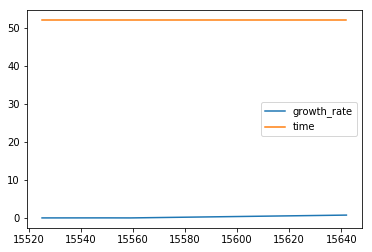

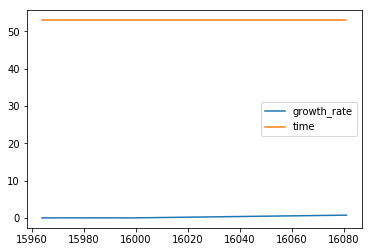

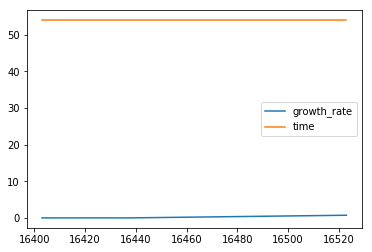

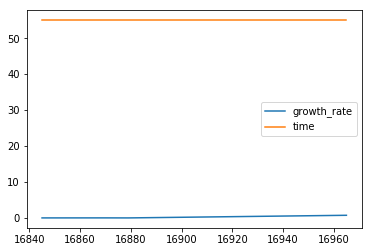

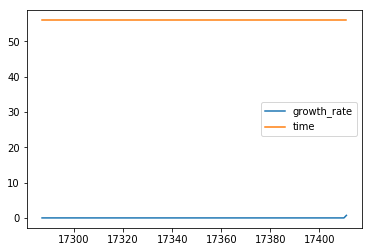

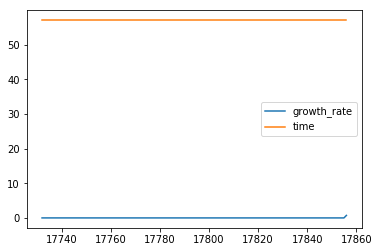

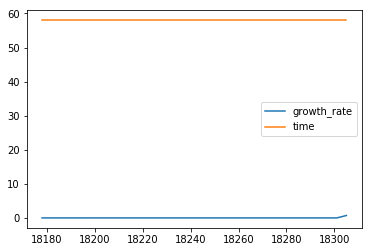

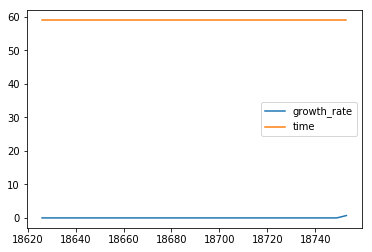

In [6]:
col = "growth_rate"
df[df["root_water"] == -0.1][[col,"time"]].groupby(['time'], as_index = True).plot()

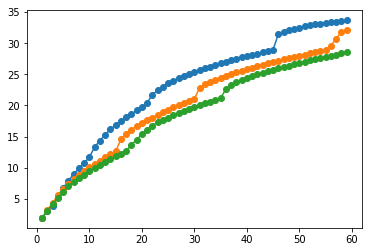

In [4]:
col = "organ_length"
plt.plot(df[df["root_water"] == -0.6][[col,"time"]].groupby(['time']).sum(),marker= "o")
plt.plot(df[df["root_water"] == -1.2][[col,"time"]].groupby(['time']).sum(),marker= "o")
plt.plot(df[df["root_water"] == -1.5][[col,"time"]].groupby(['time']).sum(),marker= "o")

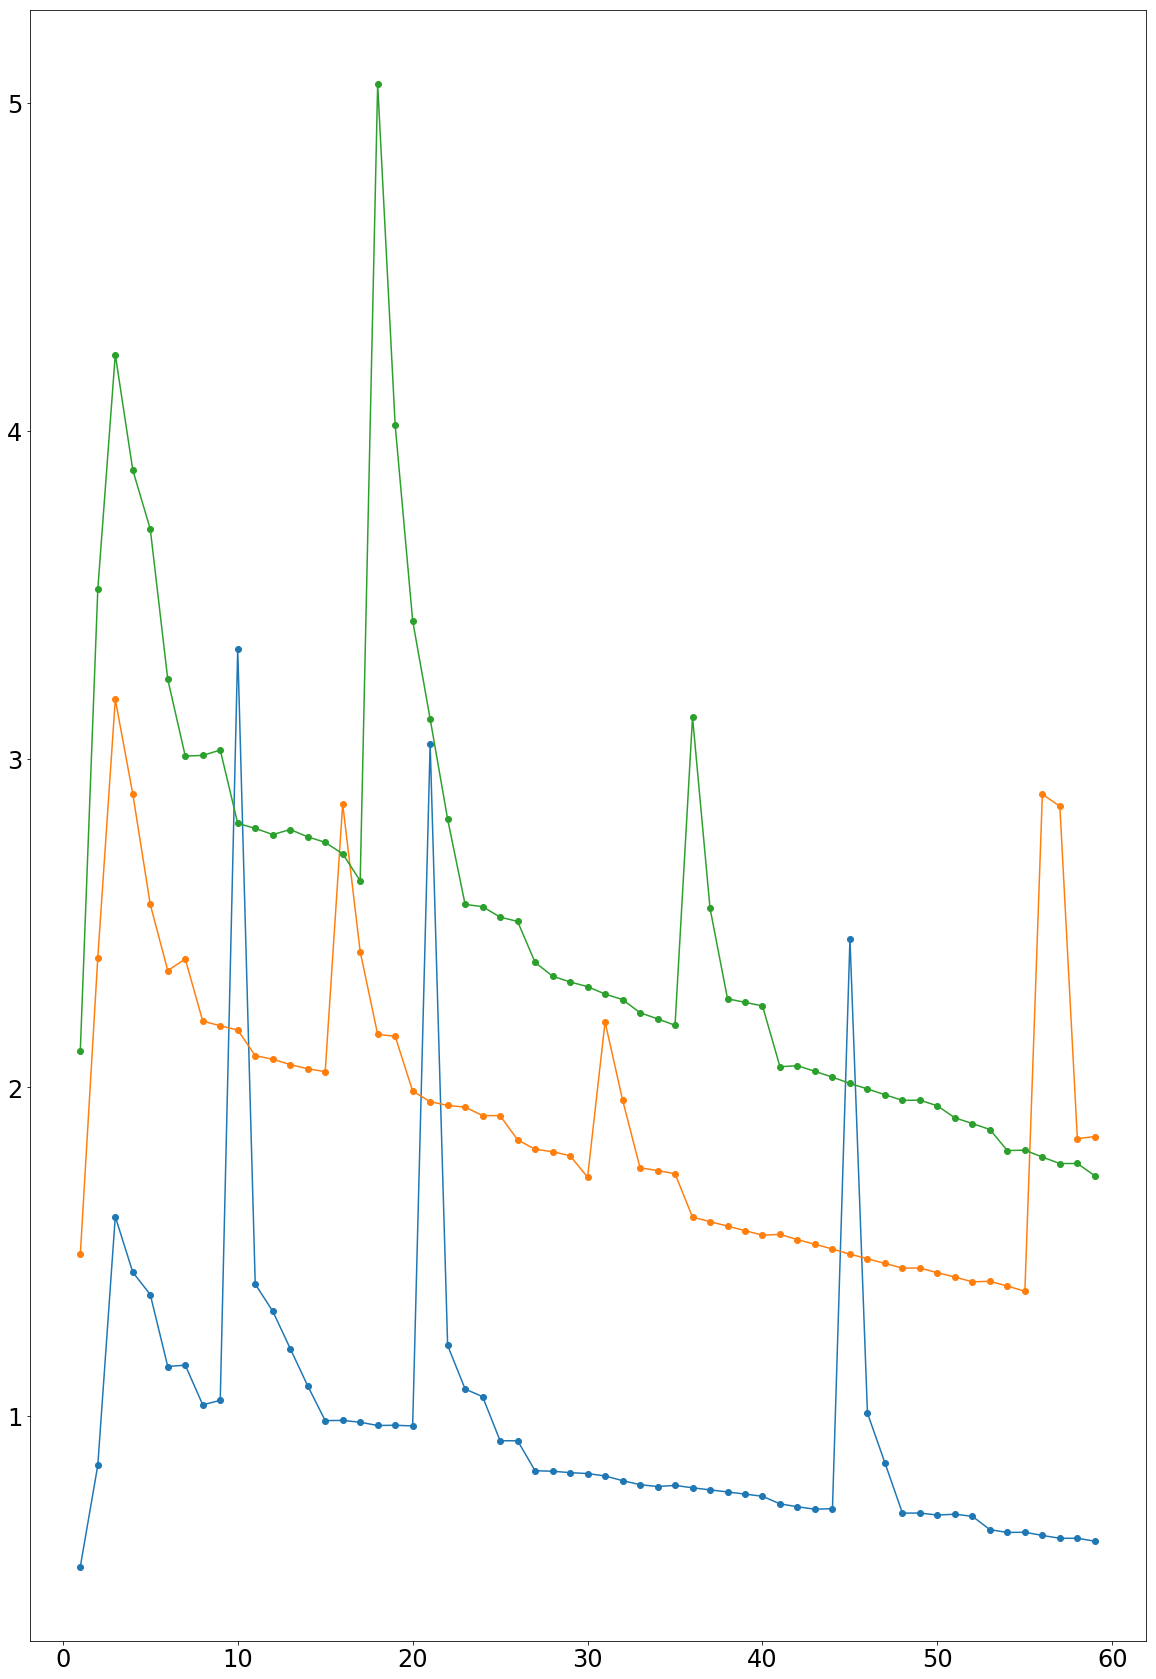

In [11]:
col = "c_satis"
plt.plot(df[df["root_water"] == -0.6][[col,"time"]].groupby(['time']).sum(),marker= "o")
plt.plot(df[df["root_water"] == -1.2][[col,"time"]].groupby(['time']).sum(),marker= "o")
plt.plot(df[df["root_water"] == -1.5][[col,"time"]].groupby(['time']).sum(),marker= "o")

<Figure size 720x720 with 0 Axes>

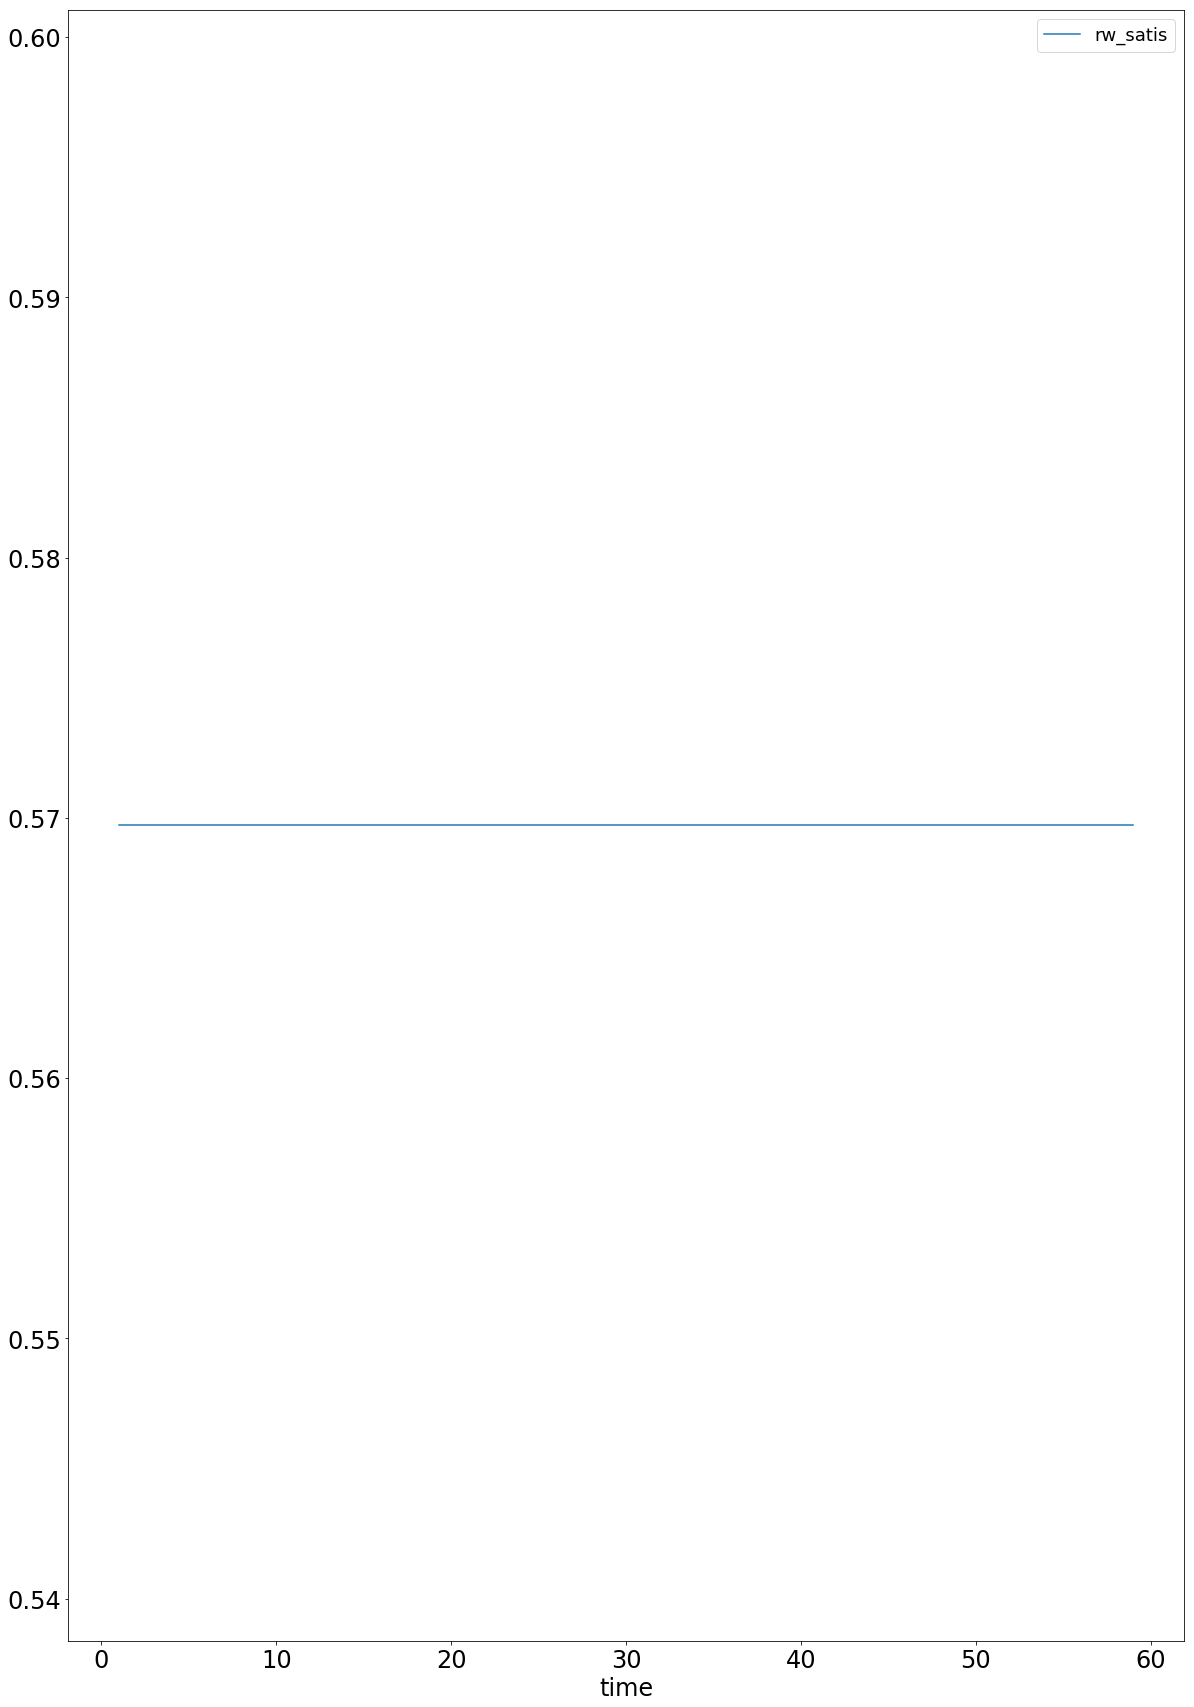

In [22]:
# plt.rcParam()
plt.figure(figsize=(10,10))
col = "rw_satis"
df[df["root_water"] == -0.6][["time",col]].set_index('time').plot()

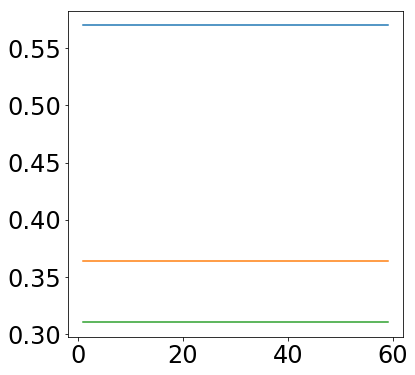

In [26]:
col = "rw_satis"
plt.figure(figsize=(6,6))
plt.plot(df[df["root_water"] == -0.6][["time",col]].set_index('time'))
plt.plot(df[df["root_water"] == -1.2][["time",col]].set_index('time'))
plt.plot(df[df["root_water"] == -1.5][["time",col]].set_index('time'))

In [29]:
col = "growth_rate"
plt.figure(figsize=(6,6))
plt.plot(df[df["root_water"] == -0.6][["time",col,"order"]].groupby("order").set_index('time'))
plt.plot(df[df["root_water"] == -1.2][["time",col]].set_index('time'))
plt.plot(df[df["root_water"] == -1.5][["time",col]].set_index('time'))

AttributeError: Cannot access callable attribute 'set_index' of 'DataFrameGroupBy' objects, try using the 'apply' method

<Figure size 432x432 with 0 Axes>

In [ ]:
col = "rw_satis"
df[df["root_water"] == -0.8][["time",col]].set_index('time').plot()

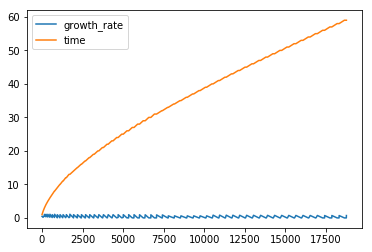

In [12]:
df[df["root_water"] == -0.1][[col,"time"]].plot()

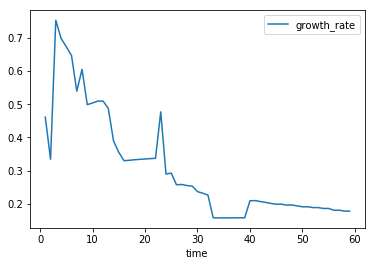

In [7]:
df[df["root_water"] == -0.1][[col,"time"]].groupby('time').mean().plot()

In [9]:
df[df["root_water"] == -0.1][[col,"time"]].groupby(['time'].plot

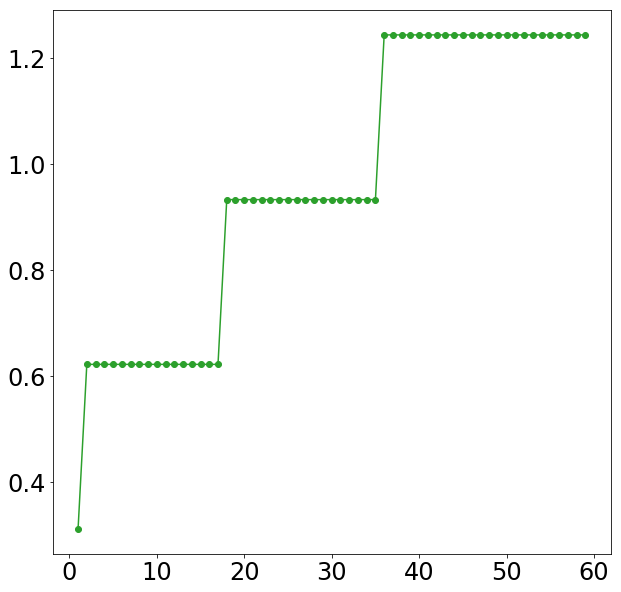

In [18]:

plt.figure(figsize=(10,10))

col = "rw_satis"
plt.plot(df[df["root_water"] == -0.1][[col,"time"]].groupby(['time']).sum(),marker= "o")
plt.plot(df[df["root_water"] == -0.8][[col,"time"]].groupby(['time']).sum(),marker= "o")
plt.plot(df[df["root_water"] == -1.5][[col,"time"]].groupby(['time']).sum(),marker= "o")

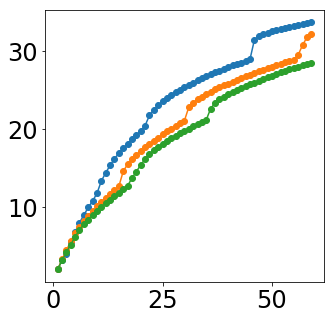

In [17]:
plt.figure(figsize=(5,5))
plt.plot(df[df["root_water"] == -0.6][["organ_length","time"]].groupby(['time']).sum(),marker= "o")
plt.plot(df[df["root_water"] == -1.2][["organ_length","time"]].groupby(['time']).sum(),marker= "o")
plt.plot(df[df["root_water"] == -1.5][["organ_length","time"]].groupby(['time']).sum(),marker= "o")

In [16]:
df[df["time"] == 59][df["root_water"] == -0.8]

time   id  organ_type  sub_type  connect_no  organ_id  organ_id2  \
18595    59  289           2         2           1         6         13   
18643    59  337           2         2           1         7         15   
18667    59  361           2         2           1         5          6   
18728    59  422           2         2           1         8         18   
18739    59  433           2         2           1         9         19   
18755    59  449           2         4           1         4          2   

       parent_organ    length  res_main      ...       c_demand_2  \
18595             2  0.092980  0.000002      ...         0.000366   
18643             2  0.150500  0.000002      ...         0.000366   
18667             2  0.040100  0.000002      ...         0.000366   
18728             2  0.206856  0.000002      ...         0.000366   
18739             2  0.208398  0.000002      ...         0.000366   
18755             0  0.238193  0.000035      ...         0.012103   

        growth_rate  exudation  order  organ_length    coor_x    coor_y  \
18595  1.477670e-03        0.0      2      2.297973  0.020559 -0.050607   
18643  4.663802e-07        0.0      2      2.050028  0.008369 -0.054871   
18667  9.647876e-06        0.0      2      3.009964 -0.005285 -0.031859   
18728  1.460843e-02        0.0      2      1.685594  0.031529 -0.013432   
18739  8.569615e-03        0.0      2      1.571668  0.046397 -0.009212   
18755  7.864098e-01        0.0      1     23.819315  0.044735 -0.003027   

         coor_z  connection_1  connection_2  
18595 -0.081562         124.0         125.0  
18643 -0.146636         326.0         327.0  
18667 -0.032252         436.0         439.0  
18728 -0.193075          34.0          33.0  
18739 -0.168243          30.0          29.0  
18755 -0.217445           NaN           NaN  

[6 rows x 24 columns]

In [ ]:
fig_colum_name ="organ_length"


a = 3
b = 1

from cycler import cycler
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(10,30))
plt.rc('axes', prop_cycle=(cycler('color', ['blue', 'grey', 'red'])))
ax1 = fig.add_subplot(a, b, 1)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("total root length (sum of 1st order and 2nd order)")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
ax1.legend()

ax1.plot(df01["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")


blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='-0.1 MPa water potential ')

grey_line = mlines.Line2D([], [], color='grey', marker='o',
                          markersize=15, label='-0.8 MPa water potential ')
red_line = mlines.Line2D([], [], color='red', marker='o',
                          markersize=15, label='-1.5 MPa water potential')


plt.legend(loc='lower left', bbox_to_anchor=(0.24, 0.02, 0, 0), handles=[blue_line,  grey_line,  red_line, ])


ax1 = fig.add_subplot(a, b,2)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("total 1st order root length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
# ax1.legend()

ax1.plot(df01["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")


ax1 = fig.add_subplot(a, b, 3)



ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_color('black')

ax1.spines['left'].set_color('black')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlabel("time (days)")
ax1.set_ylabel("length (cm)")
# ax1.set_xticks(list(ax1.set_xticks()[0]) + extraticks)
# days = range(1,len(root_he_c3 )+1)
#ax1.plot(days,f(np.array(root_1_c_cf)), marker = "o", linestyle="-", color = "blue", label= "Water potential -0.1 MPa ", zorder=99)
#ax1.plot(days,f(np.array(root_2_c_cf)), marker = "o", linestyle="-", color = "yellow", label= "Water potential -0.3 MPa ", zorder=99)

ax1.title.set_text("total 2nd order root length")
#ax1.set_ylim([0,5])
#ax1.set_xlim([0,120])
# ax1.legend()

ax1.plot(df01["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df08["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")
ax1.plot(df15["length"][['organ_length', 'time']].groupby(['time']).sum(),marker= "o")

In [128]:
water_p_list = [[1.5, 0.8, 0.1] ]
dry_soil = water_p[0]
soil_wp = water_p[1]

wet_soil = water_p[2]

name = "small_2020.xml"
plant = pb.Plant()
plant.openXML("../../modelparameter/plant/" + name)
seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
plant.initialize(True)
#     plant.setGeometry(splitBox)
day = 1# the step of every loop (day)
hour =24 # the hours of every loop (hour) used in PiafMunch
plant.simulate(60) # start simulation
organ = plant.getOrgans()
ana = pb.SegmentAnalyser(plant)
# ana.write("{}_{}_{}_{}_{}.vtp".format(name, time_total, water_dry, water_middle, water_wet)) #writes vtp the name is followed by the number of days simulated
Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
node_id_to_organ = [0]*plant.getNumberOfNodes() #
node_id_to_subtype = [0]*plant.getNumberOfNodes() #
node_id_to_organ2 = [0]*plant.getNumberOfNodes() #
# plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
dict_all  = convert( plant ) # convert plant to python outputs
for k in reversed(range(len(organ))):  # loop through all the organs
    for j in range(1,organ[k].getNumberOfNodes()): # loop through all segments in one organs
        node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
        node_id_to_organ2[organ[k].getNodeId(j)]=organ[k].getId()
        

nodes_organtype = dict_all['nodes_organtype']
N1R_node = nodes_organtype[(nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # remove seed. get roots with one connection

for node_i,root_node in enumerate(N1R_node): # get all segments in one organs
        node_organ= node_id_to_organ[int(root_node[0])-1]
        organ_i = organ[ node_organ ] 
        organ_id22 =  organ_i.getId()
        print(node_i, organ_id22, organ_i.organType(), root_node,organ_i.param().subType, organ_i.getId() )
        if organ_id22 == 1:  # first taproot
            Soil_water[node_i] = wet_soil
        elif organ_id22 == 2: 
            Soil_water[node_i] = soil_wp
        elif organ_id22 == 3:  
            Soil_water[node_i] = dry_soil

        elif organ_i.getParent().getId() == 1:
            Soil_water[node_i] = wet_soil
        elif organ_i.getParent().getId() == 2:
            Soil_water[node_i] = soil_wp
        elif organ_i.getParent().getId() == 3:
            Soil_water[node_i] = dry_soil
        else:
            Soil_water[node_i] = soil_wp

0 5 2 [190.   2.   1.   1.] 2 5
1 6 2 [393.   2.   1.   1.] 2 6
2 7 2 [587.   2.   1.   1.] 2 7
3 8 2 [763.   2.   1.   1.] 2 8
4 1 2 [794.   2.   1.   1.] 1 1
5 10 2 [983.   2.   1.   1.] 2 10
6 11 2 [1.186e+03 2.000e+00 1.000e+00 1.000e+00] 2 11
7 12 2 [1.38e+03 2.00e+00 1.00e+00 1.00e+00] 2 12
8 13 2 [1.556e+03 2.000e+00 1.000e+00 1.000e+00] 2 13
9 2 2 [1.587e+03 2.000e+00 1.000e+00 1.000e+00] 4 2
10 15 2 [1.776e+03 2.000e+00 1.000e+00 1.000e+00] 2 15
11 16 2 [1.979e+03 2.000e+00 1.000e+00 1.000e+00] 2 16
12 17 2 [2.173e+03 2.000e+00 1.000e+00 1.000e+00] 2 17
13 18 2 [2.349e+03 2.000e+00 1.000e+00 1.000e+00] 2 18
14 3 2 [2.38e+03 2.00e+00 1.00e+00 1.00e+00] 4 3


In [14]:
%%time
# water_p_list = [[0.1, 0.1, 0.1], [0.8, 0.8, 0.8], [1.5, 1.5, 1.5], 
#                 [1.5, 0.8, 0.1] , [0.3, 0.3, 0.3] , [0.5, 0.5, 0.5] , 
#                 [0.7, 0.7, 0.7] , [0.9, 0.9, 0.9], [1.1, 1.1, 1.1] , [1.3, 1.3, 1.3]  ]
# water_p_list = [[1.5, 1.5, 1.5], [1.5, 0.8, 0.1]  ]
water_p_list =  [[1.5, 1.5, 1.5], [0.1, 0.1, 0.1], [0.8, 0.8, 0.8], [1.5, 1.5, 1.5],   [1.5, 0.8, 0.1] ]
# water_p_list =  [ [1.5, 1.3, 0.7], [1.5, 0.8, 0.1] ]

# water_p_list =  [[0.8, 0.8, 0.8] ]

for i, water_p in enumerate(water_p_list):
#     name = "small_2020_more_lateral.xml"
#     name = "small_2020_low_xyl_10.xml"
    name = "small_2020_3l.xml"

    time = 60
    water_dry = water_p[0]
    water_middle = water_p[1]
   
    water_wet = water_p[2]
    total_sim(name, time, water_dry, water_middle, water_wet)

ValueError: Organism::getOrganTypeParameter: OrganRandomParameter for root, of sub type 1 was not set

In [11]:
%%time



def total_sim(name, time_total, water_dry, water_middle, water_wet):
    
    # name = "carbon2020_long_stem.xml"
    plant = pb.Plant()

    # # 2. A split pot experiment
    # topBox = pb.SDF_PlantBox(22, 20, 5)
    # #topBox = pb.SDF_RotateTranslate(topBox, pb.Vector3d(0, 0, 5))
    # # sideBox = pb.SDF_PlantBox(12, 12, 35)
    # # left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6.5, 0, -5))
    # # right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6.5, 0, -5))
    # sideBox = pb.SDF_PlantBox(10, 20, 35)
    # left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
    # right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
    # box_ = []
    # box_.append(topBox)
    # box_.append(left)
    # box_.append(right)
    # splitBox = pb.SDF_Union(box_)


    # # Set geometry: rotatedRhizotron, splitBox, or rhizoTube
    # plant.setGeometry(splitBox)
    #plant.write("splitBox.py")
    plant.openXML("../../modelparameter/plant/" + name)
    seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
    roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
    stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
    leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
    plant.initialize(True)


    carbon_logger = []
    growth_rate_logger = []
    exudation_logger = []
    root_length_logger = []
    all_length_logger = []
    taproot_n_all = []
    k1_logger = []
    leaf_logger = []
    dict_leaf_logger = []

    column_name = ["time", 
                   "id", 
                   "organ_type", 
                   "sub_type", 
                   "connect_no", 
                   "organ_id",
                   "organ_id2",
                   "parent_organ",
                   "length", 
                   "res_main", 
                   "carbon_q",
                   "c_satis",
                   "root_water",
                   "rw_satis",
                   "c_demand_2" ,                          
                   "growth_rate", 
                   "exudation", 
                   "order",
                   "organ_length",
                   "coor_x", 
                   "coor_y", 
                   "coor_z", 
                   "connection_1", 
                   "connection_2",
                   "r_xyl",
                   "r_st"
                  ]
    pd_output =  pd.DataFrame( [], columns= column_name )

    extent = 5000
    vml = 0.000143136 *extent
    r_trsv = 100/extent
    day_i = 0

    vol_st = 2.6e-05 * extent 
    vmu = 2.82627e95 *extent
    r_phl_mb = 0.027157*5000 /extent

    # xml_growth_rate = 

    # growth rate percentage based on water potential: y = 20.790289211055025 + 83.59701538925951e* **(x*1.3957803144484557)
    g_propotion = lambda water_potential : (20.79 + 83.597* 2.71828**(1.39578* (water_potential)) )/100
    # absolute respiration maintenance of plant segment = volumen of the segment * 0.0032
    # TODO to see if some other parameters from the output can be used as input
    # carbon feedback loop by days.
    for time in range(1, time_total): # i*days to simulation
        pd_output_1day =  pd.DataFrame( [], columns= column_name )

        day_i = day_i +1
    #     plant.setGeometry(splitBox)
        day = 1# the step of every loop (day)
        hour =48 # the hours of every loop (hour) used in PiafMunch
        plant.simulate(1 * day) # start simulation
        organ = plant.getOrgans()
        ana = pb.SegmentAnalyser(plant)
        ana.write("{}_{}_{}_{}_{}.vtp".format(name, time_total, water_dry, water_middle, water_wet)) #writes vtp the name is followed by the number of days simulated

        # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
        dict_all  = convert( plant ) # convert plant to python outputs
        nodes_organtype = dict_all['nodes_organtype']
        nodes_coor = python_nodes(plant)
        segs = np.array([np.array(s) for s in plant.getSegments()])
        node_connection_o = segs
        pd_output_1day.loc[:,"id"] = list(map(int,dict_all["nodes_organtype"].T[0]))
        pd_output_1day.loc[:,"organ_type"] = list(map(int,dict_all["nodes_organtype"].T[1]))
        pd_output_1day.loc[:,"connect_no"] = list(map(int,dict_all["nodes_organtype"].T[2]))

        pd_output_1day.loc[:,"coor_x"] = list(nodes_coor.T[3])
        pd_output_1day.loc[:,"coor_y"] = list(nodes_coor.T[4])
        pd_output_1day.loc[:,"coor_z"] = list(nodes_coor.T[5])

        pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_1"] = list(map(int,dict_all["node_connection"].T[0]))
        pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_2"] = list(map(int,dict_all["node_connection"].T[1]))


        piafmunch_outputname = name +".ini" # set the name of the parameters
        Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
        organ_radius = [0]*((len(organ))) # initiate the radius of each segment
        k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
        kt = [0]*(len(dict_all['node_connection'])+1) # total carbon maintenance

        node_id_to_organ = [0]*plant.getNumberOfNodes() #
        node_id_to_subtype = [0]*plant.getNumberOfNodes() #
        node_id_to_organ2 = [0]*plant.getNumberOfNodes() #



        ########################################## python nodes conversion #########################################


        # sink nodes (nodes have one connection and on the right hand side)
        N1R_node = nodes_organtype[(nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # remove seed. get roots with one connection
        # source nodes
        N1L_node = nodes_organtype[ ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # remove seed. get stem or leaf with one connection
        leaf_logger.append(len(N1L_node)) 

        ########################## nodewise iteration to know which organ it belongs to ###########################################
        ########################## nodewise iteration to get maximal  ###########################################  

        # need more check 
        #
        for k in reversed(range(len(organ))):  # loop through all the organs
            organ_radius[k] = organ[k].getParam().a #the diameter of one organ
            j=0

            for j in range(1,organ[k].getNumberOfNodes()): # loop through all segments in one organs
                node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
                node_id_to_organ2[organ[k].getNodeId(j)]=organ[k].getId()
                node_id_to_subtype[organ[k].getNodeId(j)] = int(organ[k].getParameter("subType"))


                volumen = organ_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx
                phloem_per_section = 1#4200
                m_r = 0.0032 # Organ maintenance respiration rate (gCO2 g−1 DM)
                mass_per_volumen = 0.10 #root dry mass per unit volume (gDM cm−3) 0.05-0.14
                Carbon_main = volumen *0.0032*0.1/(24) *1000/12 # (1000/12) from grams/day/cm3 to mmol/hour/cm3 calculate the maintenance by volume (mmol)
                #Carbon_main = 1
                # print("maintenance is : ", Carbon_main) # absolute carbon maintentance
                k1[organ[k].getNodeId(j)] = Carbon_main 
        k1_logger.append(np.sum(k1))
        taproot_length = [0] * (len(plant.getOrgans())-2)
        all_organ_length = [0] * (len(plant.getOrgans())-2)
        taproot_n = []
        for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
            if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
                taproot_n.append(root_n)
        taproot_n_all.append(taproot_n)
                 ############################# water potential in left and right !root! ##################################################
        soil_wp = water_middle
        dry_soil = water_dry
        wet_soil = water_wet
    #     here need more development 
        
        for node_i,root_node in enumerate(N1R_node): # get all segments in one organs
            node_organ= node_id_to_organ[int(root_node[0])-1]
            organ_i = organ[ node_organ ] 
            organ_id22 =  organ_i.getId()
            print(node_i, organ_i.organType(), root_node,organ_i.param().subType, organ_i.getParent().getId() )
            if organ_id22 == 1:  # first taproot
                Soil_water[node_i] = wet_soil
            elif organ_id22 == 2: 
                Soil_water[node_i] = soil_wp
            elif organ_id22 == 3:  
                Soil_water[node_i] = dry_soil

            elif organ_i.getParent().getId() == 1:
                Soil_water[node_i] = wet_soil
            elif organ_i.getParent().getId() == 2:
                Soil_water[node_i] = soil_wp
            elif organ_i.getParent().getId() == 3:
                Soil_water[node_i] = dry_soil
            else:
                Soil_water[node_i] = soil_wp

        organ_number_to_order = [0] *len(organ)
        for k in reversed(range(len(organ))):  # loop through all the organs
            if organ[k].getParent().organType() == 1:
                organ_number_to_order[k] = 1
            elif organ[k].getParent().getParent().organType() == 1:
                organ_number_to_order[k] = 2
            elif organ[k].getParent().getParent().getParent().organType() == 1:
                organ_number_to_order[k] = 3
            elif organ[k].getParent().getParent().getParent().getParent().organType() == 1:
                organ_number_to_order[k] = 4
            elif organ[k].getParent().getParent().getParent().getParent().getParent().organType() == 1:
                organ_number_to_order[k] = 5
            else:
                organ_number_to_order[k] = 6

        i=0
        for i in range(len(nodes_organtype)):
            oder_number = organ_number_to_order[node_id_to_organ[i]]
            pd_output_1day.loc[i,"order"] = oder_number 
            if oder_number == 1:
                pd_output_1day.loc[i,"parent_organ"] = 0
            else:
                pd_output_1day.loc[i,"parent_organ"] = organ[node_id_to_organ[i]].getParent().getId()
    #         print("node_id_to_organ[i]", node_id_to_organ[i])
    #         print("organ_number_to_order[node_id_to_organ[i]]", organ_number_to_order[node_id_to_organ[i]])        


        ############################# water potential in left and right !boxex! ##################################################
    #     for i, roottip in enumerate(N1R_node): 
    #         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
    #             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
    #         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
    #             Soil_water[i] = 0.1 # actuall value is -0.5
    #         else:
    #             Soil_water[i] = 0.1 # actuall value is -0.1

        nodes_length = np.zeros(len(nodes_coor))
        for i in range(1,len(nodes_coor)):
            if nodes_coor[i][1]==2: #if the organtype is root
                nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]]  
                                   + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                    + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                    + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )
            else:
                nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] 
                                   + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                      + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                      + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )


        axial_r_xylem = []
        for i in range(0,(len(dict_all["node_connection"]))):
            second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1

            if plant.getOrgans()[node_id_to_organ[second_node]].getParent().getOrganRandomParameter().subType == 0:
                axial_r_xylem.append(
                   k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[second_node]].getLength() - np.abs(nodes_length[second_node])*100)))/4 /10)
            else:
                axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) /4)

        axial_r_phloem = []
        for i in range(0,(len(dict_all["node_connection"]))):
            #     print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().subType)
            second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1
            phloem_radius = plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a
            resistance_propotional =0.04 *(0.2**4)/phloem_radius**4 # based on hagen poissuelle's law
            # print(plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a)
            axial_r_phloem.append(resistance_propotional)


#         def devide_20(x):
# #             return x/4 # normal value
#             return x/4 *10 

#         axial_r_xylem_0_25cm = map(devide_20, axial_r_xylem)
        ################################# coupling layer with piafmunch ###################################################
        homo_st = [0.04]*(len(dict_all["node_connection"]))
        # pass the absolute carbon maintentance to piafmunch
        write_PiafMunch_parameter(dict_all['node_connection'], 
                                  dict_all['nodes_organtype'], 
                                   axial_r_phloem, 
                                  dict_all['unq_cnt'], 
                                  Soil_water, 
                                  k1, 
                                  piafmunch_outputname,
                                  hour, 
                                  list(axial_r_xylem), 
                                  vml, 
                                  vol_st, 
                                  vmu, 
                                  r_phl_mb,
                                  r_trsv)
        # call piafmunch and rename the output file of the PiafMunch
        os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
        now = datetime.datetime.now()
        os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_{}_{}_{}_{}_output.txt'.format(name, now.year ,now.month, now.day,name, time_total, water_dry, water_middle, water_wet ) )
        output_name = "{}_{}_{}_{}_{}".format(name, time_total, water_dry, water_middle, water_wet)
        ########################## convert carbon to growth rate ###########################################
        piaf_output = read_output(output_name,  dict_all["node_connection"])
        one_growth_log = [0] * (len(plant.getOrgans())+1)
        one_carbon_log = [0] * (len(plant.getOrgans())+1)
        one_exudation_log = [0] * (len(plant.getOrgans())+1)
        for node_i,root_node in enumerate(N1R_node): # CPlantBox growth rate: cm day-1
            # print(i)
            nodes_organ = organ[node_id_to_organ[int(root_node[0])-1]]
            pd_output_1day.loc[int(root_node[0])-1,"organ_length"] = nodes_organ.getLength()

            corss_area_root= nodes_organ.getParam().a**2*3.1415926 # this is also the carbon used for growth because mass need is 1 g DM cm−3
            # carbon_need = # mass need is 1 g DM cm−3
            # print("corss section area of root", corss_area_root)
            # carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 * 10 * volumen # directly pass the Q_ST * 1e5 to carbon content
            # num_of_phloem = 4200/0.12566370400000001
            carbon_available = piaf_output["Q_ST"][-1][int(root_node[0])-1]
            carbon_available_g_c = piaf_output["Q_ST"][-1][int(root_node[0])-1]* 12/1000 *24 #  # gram of carbon per day
            print(" " )
    #         print("available carbon: ", carbon_available_g_c )
    #         print(node_id_to_organ[int(root_node[0])-1])

    #         print(nodes_organ.getOrganRandomParameter().r)

#             rw_satis = g_propotion(0 - Soil_water[node_id_to_organ[int(root_node[0])-1]]) # buggy
            rw_satis = g_propotion(piaf_output["P_Xyl"][-1][int(root_node[0]-1)])

            #if exudation_logger == []:
            gr_water =  rw_satis * nodes_organ.getOrganRandomParameter().r
    #         print("rw_satis", rw_satis)
    #         print("growth rate by water", gr_water)
            # nodes_organ.getParam().r =   max([0, min([water_potential ,carbon_content])] )
            # r_carbon =  carbon_content/r_water
            gr_pot_2 = gr_water
            c_demand_2 = max(0.000001, corss_area_root *gr_pot_2  * 0.1 ) # 0.1 g DM cm−3 / day
    #         print("water_satis", )
    #         print("c_demand_2",c_demand_2)
            c_offer_2 = carbon_available_g_c
    #         print("c_offer_2", c_offer_2)
            c_satis = c_offer_2 / c_demand_2

            gr_act = gr_pot_2 * max([0.000001, min([1,c_satis])])
    #         print("GR_act", gr_act)
    #         nodes_organ.getParam().r =   max([0, min([gr_water, carbon_content])])
            nodes_organ.getParam().r = gr_act
    #         print("growth rate", nodes_organ.getParam().r)
            pd_output_1day.loc[int(root_node[0])-1, "growth_rate"] = gr_act
            pd_output_1day.loc[int(root_node[0])-1, "exudation"] = max([0 ,carbon_available_g_c - c_demand_2])  
            pd_output_1day.loc[int(root_node[0])-1, "root_water"] =  piaf_output["P_Xyl"][-1][int(root_node[0]-1)]
            pd_output_1day.loc[int(root_node[0])-1, "rw_satis"] = rw_satis
            pd_output_1day.loc[int(root_node[0])-1, "c_satis"] = c_satis
            pd_output_1day.loc[int(root_node[0])-1, "c_demand_2"] = c_demand_2


            one_carbon_log[node_id_to_organ[int(root_node[0])-1]] = carbon_available
            one_growth_log[node_id_to_organ[int(root_node[0])-1]] = gr_act
            one_exudation_log[node_id_to_organ[int(root_node[0])-1]] = max([0 ,carbon_available_g_c - c_demand_2])  
        ############################################length logger ###########################
        growth_rate_logger.append(one_growth_log)
        carbon_logger.append(one_carbon_log)
        exudation_logger.append(one_exudation_log)

        taproot_length = [0] * (len(plant.getOrgans())-2)
        all_organ_length = [0] * (len(plant.getOrgans())-2)

        for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
            if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
                taproot_length[root_n] = root.getLength()
                all_organ_length[root_n] =  root.getLength()
            elif root.organType() == 2 and root.getParent().organType()!=1: # not primary roots
                # print("lateral",root.getParent().organType() ,  root_n)
                # print(root.getParent().getId())
                taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
                all_organ_length[root_n] = root.getLength()
        root_length_logger.append(taproot_length)
        all_length_logger.append(all_organ_length)


        pd_output_1day.loc[:,"organ_id"] = list(map(int,node_id_to_organ))
        pd_output_1day.loc[:,"organ_id2"] = list(map(int,node_id_to_organ2))

        pd_output_1day.loc[:,"length"] = list(nodes_length)
        pd_output_1day.loc[:len(dict_all["node_connection"])-1,"r_xyl"] = list(axial_r_xylem)
        pd_output_1day.loc[:len(dict_all["node_connection"])-1,"r_st"] = list(axial_r_phloem)

        pd_output_1day.loc[:,"res_main"] = list(k1)
        pd_output_1day.loc[:,"carbon_q"] = piaf_output["Q_ST"][-1]
        pd_output_1day.loc[:,"time"] = day_i
        pd_output_1day.loc[:,"sub_type"] = list(node_id_to_subtype)
        pd_output_1day.loc[0,"sub_type"] = 1
        # pd_output_1day["growth_rate"] = piaf_output["Q_ST"][-1]
        #     f=np.sum
        pd_output = pd_output.append(pd_output_1day)
    #     f.plot(piaf_output["Q_ST"][:,int(N1R_node[0][0]-1)], color = "red", label = "1st root")
    #     f.plot(piaf_output["Q_ST"][:,int(N1R_node[1][0]-1)], color = "blue", label = "2nd root")
    #     f.plot(piaf_output["Q_ST"][:,int(N1R_node[2][0]-1)], color = "green", label = "3rd root")
    #     f.legend()
    #     f.show()
    #     print(piaf_output["Q_ST"][-1,int(N1R_node[0][0]-1)])
    #     print(piaf_output["Q_ST"][-1,int(N1R_node[1][0]-1)])
    #     print(piaf_output["Q_ST"][-1,int(N1R_node[2][0]-1)])
     # growthrate() CPlantBox growth rate: cm day-1
    #total length two curve with total water potential

    #change the soil water

    pd_output.to_csv("{}.csv".format(output_name), index=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.4 µs


In [5]:
%%time

# Chaning water potential.

def total_sim(name, time_total, water_dry, water_middle, water_wet):
    
    # name = "carbon2020_long_stem.xml"
    plant = pb.Plant()

    # # 2. A split pot experiment
    # topBox = pb.SDF_PlantBox(22, 20, 5)
    # #topBox = pb.SDF_RotateTranslate(topBox, pb.Vector3d(0, 0, 5))
    # # sideBox = pb.SDF_PlantBox(12, 12, 35)
    # # left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6.5, 0, -5))
    # # right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6.5, 0, -5))
    # sideBox = pb.SDF_PlantBox(10, 20, 35)
    # left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6, 0, -5))
    # right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6, 0, -5))
    # box_ = []
    # box_.append(topBox)
    # box_.append(left)
    # box_.append(right)
    # splitBox = pb.SDF_Union(box_)


    # # Set geometry: rotatedRhizotron, splitBox, or rhizoTube
    # plant.setGeometry(splitBox)
    #plant.write("splitBox.py")
    plant.openXML("../../modelparameter/plant/" + name)
    seeds = plant.getOrganRandomParameter(pb.OrganTypes.seed)
    roots = plant.getOrganRandomParameter(pb.OrganTypes.root)
    stems = plant.getOrganRandomParameter(pb.OrganTypes.stem)
    leafs = plant.getOrganRandomParameter(pb.OrganTypes.leaf)
    plant.initialize(True)


    carbon_logger = []
    growth_rate_logger = []
    exudation_logger = []
    root_length_logger = []
    all_length_logger = []
    taproot_n_all = []
    k1_logger = []
    leaf_logger = []
    dict_leaf_logger = []

    column_name = ["time", 
                   "id", 
                   "organ_type", 
                   "sub_type", 
                   "connect_no", 
                   "organ_id",
                   "organ_id2",
                   "parent_organ",
                   "length", 
                   "res_main", 
                   "carbon_q",
                   "c_satis",
                   "root_water",
                   "rw_satis",
                   "c_demand_2" ,                          
                   "growth_rate", 
                   "exudation", 
                   "order",
                   "organ_length",
                   "coor_x", 
                   "coor_y", 
                   "coor_z", 
                   "connection_1", 
                   "connection_2",
                   "r_xyl",
                   "r_st"
                  ]
    pd_output =  pd.DataFrame( [], columns= column_name )

    extent = 5000
    vml = 0.000143136 *extent
    r_trsv = 100/extent
    day_i = 0

    vol_st = 2.6e-05 * extent 
    vmu = 2.82627e95 *extent
    r_phl_mb = 0.027157*5000 /extent

    # xml_growth_rate = 

    # growth rate percentage based on water potential: y = 20.790289211055025 + 83.59701538925951e* **(x*1.3957803144484557)
    g_propotion = lambda water_potential : (20.79 + 83.597* 2.71828**(1.39578* (water_potential)) )/100
    # absolute respiration maintenance of plant segment = volumen of the segment * 0.0032
    # TODO to see if some other parameters from the output can be used as input
    # carbon feedback loop by days.
    for time in range(1, time_total): # i*days to simulation
        pd_output_1day =  pd.DataFrame( [], columns= column_name )

        day_i = day_i +1
    #     plant.setGeometry(splitBox)
        day = 1# the step of every loop (day)
        hour =24 # the hours of every loop (hour) used in PiafMunch
        plant.simulate(1 * day) # start simulation
        organ = plant.getOrgans()
        ana = pb.SegmentAnalyser(plant)
        ana.write("{}_{}_{}_{}_{}.vtp".format(name, time_total, water_dry, water_middle, water_wet)) #writes vtp the name is followed by the number of days simulated

        # plant.write("{}{}{}.py".format(hour,str(name),"1st_test"))
        dict_all  = convert( plant ) # convert plant to python outputs
        nodes_organtype = dict_all['nodes_organtype']
        nodes_coor = python_nodes(plant)
        segs = np.array([np.array(s) for s in plant.getSegments()])
        node_connection_o = segs
        pd_output_1day.loc[:,"id"] = list(map(int,dict_all["nodes_organtype"].T[0]))
        pd_output_1day.loc[:,"organ_type"] = list(map(int,dict_all["nodes_organtype"].T[1]))
        pd_output_1day.loc[:,"connect_no"] = list(map(int,dict_all["nodes_organtype"].T[2]))

        pd_output_1day.loc[:,"coor_x"] = list(nodes_coor.T[3])
        pd_output_1day.loc[:,"coor_y"] = list(nodes_coor.T[4])
        pd_output_1day.loc[:,"coor_z"] = list(nodes_coor.T[5])

        pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_1"] = list(map(int,dict_all["node_connection"].T[0]))
        pd_output_1day.loc[:len(dict_all["node_connection"])-1,"connection_2"] = list(map(int,dict_all["node_connection"].T[1]))


        piafmunch_outputname = name +".ini" # set the name of the parameters
        Soil_water = [0]*(len(dict_all['node_connection'])+1) # initiate soil water potentil
        organ_radius = [0]*((len(organ))) # initiate the radius of each segment
        k1 = [0]*(len(dict_all['node_connection'])+1) # k1 parameter in equation
        kt = [0]*(len(dict_all['node_connection'])+1) # total carbon maintenance

        node_id_to_organ = [0]*plant.getNumberOfNodes() #
        node_id_to_subtype = [0]*plant.getNumberOfNodes() #
        node_id_to_organ2 = [0]*plant.getNumberOfNodes() #



        ########################################## python nodes conversion #########################################


        # sink nodes (nodes have one connection and on the right hand side)
        N1R_node = nodes_organtype[(nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )] # remove seed. get roots with one connection
        # source nodes
        N1L_node = nodes_organtype[ ((nodes_organtype[:,1] ==4)|(nodes_organtype[:,1] ==3)  ) & (nodes_organtype[:,2] ==1 )] # remove seed. get stem or leaf with one connection
        leaf_logger.append(len(N1L_node)) 

        ########################## nodewise iteration to know which organ it belongs to ###########################################
        ########################## nodewise iteration to get maximal  ###########################################  

        # need more check 
        #
        for k in reversed(range(len(organ))):  # loop through all the organs
            organ_radius[k] = organ[k].getParam().a #the diameter of one organ
            j=0

            for j in range(1,organ[k].getNumberOfNodes()): # loop through all segments in one organs
                node_id_to_organ[organ[k].getNodeId(j)]=k # set an id, so we can get the organ number from a node number
                node_id_to_organ2[organ[k].getNodeId(j)]=organ[k].getId()
                node_id_to_subtype[organ[k].getNodeId(j)] = int(organ[k].getParameter("subType"))


                volumen = organ_radius[k]**2*3.1415926* organ[k].getOrganRandomParameter().dx
                phloem_per_section = 1#4200
                m_r = 0.0032 # Organ maintenance respiration rate (gCO2 g−1 DM)
                mass_per_volumen = 0.10 #root dry mass per unit volume (gDM cm−3) 0.05-0.14
                Carbon_main = volumen *0.0032*0.1/(24) *1000/12 # (1000/12) from grams/day/cm3 to mmol/hour/cm3 calculate the maintenance by volume (mmol)
                #Carbon_main = 1
                # print("maintenance is : ", Carbon_main) # absolute carbon maintentance
                k1[organ[k].getNodeId(j)] = Carbon_main 
        k1_logger.append(np.sum(k1))
        taproot_length = [0] * (len(plant.getOrgans())-2)
        all_organ_length = [0] * (len(plant.getOrgans())-2)
        taproot_n = []
        for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
            if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot
                taproot_n.append(root_n)
        taproot_n_all.append(taproot_n)
                 ############################# water potential in left and right !root! ##################################################
        soil_wp = water_middle
        dry_soil = water_dry
        wet_soil = water_wet
#         soil_wp = wp_all[time]
#         dry_soil = wp_all[time]
#         wet_soil = wp_all[time]



    #     here need more development 
        
        for node_i,root_node in enumerate(N1R_node): # get all segments in one organs
            node_organ= node_id_to_organ[int(root_node[0])-1]
            organ_i = organ[ node_organ ] 
            organ_id22 =  organ_i.getId()
            print(node_i, organ_i.organType(), root_node,organ_i.param().subType, organ_i.getParent().getId() )
            if organ_id22 == 1:  # first taproot
                Soil_water[node_i] = wet_soil
            elif organ_id22 == 2: 
                Soil_water[node_i] = soil_wp
            elif organ_id22 == 3:  
                Soil_water[node_i] = dry_soil

            elif organ_i.getParent().getId() == 1:
                Soil_water[node_i] = wet_soil
            elif organ_i.getParent().getId() == 2:
                Soil_water[node_i] = soil_wp
            elif organ_i.getParent().getId() == 3:
                Soil_water[node_i] = dry_soil
            else:
                Soil_water[node_i] = soil_wp

        organ_number_to_order = [0] *len(organ)
        for k in reversed(range(len(organ))):  # loop through all the organs
            if organ[k].getParent().organType() == 1:
                organ_number_to_order[k] = 1
            elif organ[k].getParent().getParent().organType() == 1:
                organ_number_to_order[k] = 2
            elif organ[k].getParent().getParent().getParent().organType() == 1:
                organ_number_to_order[k] = 3
            elif organ[k].getParent().getParent().getParent().getParent().organType() == 1:
                organ_number_to_order[k] = 4
            elif organ[k].getParent().getParent().getParent().getParent().getParent().organType() == 1:
                organ_number_to_order[k] = 5
            else:
                organ_number_to_order[k] = 6

        i=0
        for i in range(len(nodes_organtype)):
            oder_number = organ_number_to_order[node_id_to_organ[i]]
            pd_output_1day.loc[i,"order"] = oder_number 
            if oder_number == 1:
                pd_output_1day.loc[i,"parent_organ"] = 0
            else:
                pd_output_1day.loc[i,"parent_organ"] = organ[node_id_to_organ[i]].getParent().getId()
    #         print("node_id_to_organ[i]", node_id_to_organ[i])
    #         print("organ_number_to_order[node_id_to_organ[i]]", organ_number_to_order[node_id_to_organ[i]])        


        ############################# water potential in left and right !boxex! ##################################################
    #     for i, roottip in enumerate(N1R_node): 
    #         if left.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the left box
    #             Soil_water[i] = 0.1 # unit is added with a minus sign, actuall value is -0.2
    #         elif right.getDist(plant.getNodes()[int(roottip[0])-1]) <0: # if it is in the right box
    #             Soil_water[i] = 0.1 # actuall value is -0.5
    #         else:
    #             Soil_water[i] = 0.1 # actuall value is -0.1

        nodes_length = np.zeros(len(nodes_coor))
        for i in range(1,len(nodes_coor)):
            if nodes_coor[i][1]==2: #if the organtype is root
                nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]]  
                                   + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                    + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                    + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5] -nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )
            else:
                nodes_length[i] = (nodes_length[node_connection_o[(node_connection_o[:,1] == i)][0][0]] 
                                   + ((nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][3]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][3])**2 
                                      + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][4]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][4])**2 
                                      + (nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][0]][5]-nodes_coor[node_connection_o[(node_connection_o[:,1] == i)][0][1]][5])**2)**(0.5) )


        axial_r_xylem = []
        for i in range(0,(len(dict_all["node_connection"]))):
            second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1

            if plant.getOrgans()[node_id_to_organ[second_node]].getParent().getOrganRandomParameter().subType == 0:
                axial_r_xylem.append(
                   k_to_r(k_primary(max(0 ,plant.getOrgans()[node_id_to_organ[second_node]].getLength() - np.abs(nodes_length[second_node])*100)))/4 )
            else:
                axial_r_xylem.append( k_to_r(k_lateral(plant.getSegmentCTs()[i])) /4 )

        axial_r_phloem = []
        for i in range(0,(len(dict_all["node_connection"]))):
            #     print(plant.getOrgans()[node_id_to_organ[i]].getOrganRandomParameter().subType)
            second_node = dict_all["node_connection"].T[1][i]-1 # the node connection starts with node 1
            phloem_radius = plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a
            resistance_propotional =0.04 *(0.2**4)/phloem_radius**4 # based on hagen poissuelle's law
            # print(plant.getOrgans()[node_id_to_organ[second_node]].getOrganRandomParameter().a)
            axial_r_phloem.append(resistance_propotional)


#         def devide_20(x):
# #             return x/4 # normal value
#             return x/4 *10 

#         axial_r_xylem_0_25cm = map(devide_20, axial_r_xylem)
        ################################# coupling layer with piafmunch ###################################################
        homo_st = [0.04]*(len(dict_all["node_connection"]))
        # pass the absolute carbon maintentance to piafmunch
        write_PiafMunch_parameter(dict_all['node_connection'], 
                                  dict_all['nodes_organtype'], 
                                   axial_r_phloem, 
                                  dict_all['unq_cnt'], 
                                  Soil_water, 
                                  k1, 
                                  piafmunch_outputname,
                                  hour, 
                                  list(axial_r_xylem), 
                                  vml, 
                                  vol_st, 
                                  vmu, 
                                  r_phl_mb,
                                  r_trsv)
        # call piafmunch and rename the output file of the PiafMunch
        os.system(' /mnt/c/prog_sct.bas/programs/C++/PIAFMunch2/projects/PIAFMunch2.exe {} -noGUI -q'.format(piafmunch_outputname))
        now = datetime.datetime.now()
        os.system('mv ./{}_{}-{:02}-{:02}*output.txt  ./{}_{}_{}_{}_{}_output.txt'.format(name, now.year ,now.month, now.day,name, time_total, water_dry, water_middle, water_wet ) )
        output_name = "{}_{}_{}_{}_{}".format(name, time_total, water_dry, water_middle, water_wet)
        ########################## convert carbon to growth rate ###########################################
        piaf_output = read_output(output_name,  dict_all["node_connection"])
        one_growth_log = [0] * (len(plant.getOrgans())+1)
        one_carbon_log = [0] * (len(plant.getOrgans())+1)
        one_exudation_log = [0] * (len(plant.getOrgans())+1)
        for node_i,root_node in enumerate(N1R_node): # CPlantBox growth rate: cm day-1
            # print(i)
            nodes_organ = organ[node_id_to_organ[int(root_node[0])-1]]
            pd_output_1day.loc[int(root_node[0])-1,"organ_length"] = nodes_organ.getLength()

            corss_area_root= nodes_organ.getParam().a**2*3.1415926 # this is also the carbon used for growth because mass need is 1 g DM cm−3
            # carbon_need = # mass need is 1 g DM cm−3
            # print("corss section area of root", corss_area_root)
            # carbon_content = piaf_output["Q_ST"][-1][int(node[0])-1]* 12/1000 * 10 * volumen # directly pass the Q_ST * 1e5 to carbon content
            # num_of_phloem = 4200/0.12566370400000001
            carbon_available = piaf_output["Q_ST"][-1][int(root_node[0])-1]
            carbon_available_g_c = piaf_output["Q_ST"][-1][int(root_node[0])-1]* 12/1000 *24 #  # gram of carbon per day
            print(" " )
    #         print("available carbon: ", carbon_available_g_c )
    #         print(node_id_to_organ[int(root_node[0])-1])

    #         print(nodes_organ.getOrganRandomParameter().r)

#             rw_satis = g_propotion(0 - Soil_water[node_id_to_organ[int(root_node[0])-1]]) # buggy
            rw_satis = g_propotion(piaf_output["P_Xyl"][-1][int(root_node[0]-1)])

            #if exudation_logger == []:
            gr_water =  rw_satis * nodes_organ.getOrganRandomParameter().r
    #         print("rw_satis", rw_satis)
    #         print("growth rate by water", gr_water)
            # nodes_organ.getParam().r =   max([0, min([water_potential ,carbon_content])] )
            # r_carbon =  carbon_content/r_water
            gr_pot_2 = gr_water
            c_demand_2 = max(0.000001, corss_area_root *gr_pot_2  * 0.1 ) # 0.1 g DM cm−3 / day
    #         print("water_satis", )
    #         print("c_demand_2",c_demand_2)
            c_offer_2 = carbon_available_g_c
    #         print("c_offer_2", c_offer_2)
            c_satis = c_offer_2 / c_demand_2

            gr_act = gr_pot_2 * max([0.000001, min([1,c_satis])])
    #         print("GR_act", gr_act)
    #         nodes_organ.getParam().r =   max([0, min([gr_water, carbon_content])])
            nodes_organ.getParam().r = gr_act
    #         print("growth rate", nodes_organ.getParam().r)
            pd_output_1day.loc[int(root_node[0])-1, "growth_rate"] = gr_act
            pd_output_1day.loc[int(root_node[0])-1, "exudation"] = max([0 ,carbon_available_g_c - c_demand_2])  
            pd_output_1day.loc[int(root_node[0])-1, "root_water"] =  piaf_output["P_Xyl"][-1][int(root_node[0]-1)]
            pd_output_1day.loc[int(root_node[0])-1, "rw_satis"] = rw_satis
            pd_output_1day.loc[int(root_node[0])-1, "c_satis"] = c_satis
            pd_output_1day.loc[int(root_node[0])-1, "c_demand_2"] = c_demand_2


            one_carbon_log[node_id_to_organ[int(root_node[0])-1]] = carbon_available
            one_growth_log[node_id_to_organ[int(root_node[0])-1]] = gr_act
            one_exudation_log[node_id_to_organ[int(root_node[0])-1]] = max([0 ,carbon_available_g_c - c_demand_2])  
        ############################################length logger ###########################
        growth_rate_logger.append(one_growth_log)
        carbon_logger.append(one_carbon_log)
        exudation_logger.append(one_exudation_log)

        taproot_length = [0] * (len(plant.getOrgans())-2)
        all_organ_length = [0] * (len(plant.getOrgans())-2)

        for root_n, root in enumerate(plant.getOrgans()): # recrusive get all the roots
            if root.organType() == 2 and root.getParent().organType()==1: #make sure it is taproot: 
                taproot_length[root_n] = root.getLength()
                all_organ_length[root_n] =  root.getLength()
            elif root.organType() == 2 and root.getParent().organType()!=1: # not primary roots
                # print("lateral",root.getParent().organType() ,  root_n)
                # print(root.getParent().getId())
                taproot_length[taproot_n[root.getParent().getId()-1]] = taproot_length[taproot_n[root.getParent().getId()-1]] +root.getLength()
                all_organ_length[root_n] = root.getLength()
        root_length_logger.append(taproot_length)
        all_length_logger.append(all_organ_length)


        pd_output_1day.loc[:,"organ_id"] = list(map(int,node_id_to_organ))
        pd_output_1day.loc[:,"organ_id2"] = list(map(int,node_id_to_organ2))

        pd_output_1day.loc[:,"length"] = list(nodes_length)
        pd_output_1day.loc[:len(dict_all["node_connection"])-1,"r_xyl"] = list(axial_r_xylem)
        pd_output_1day.loc[:len(dict_all["node_connection"])-1,"r_st"] = list(axial_r_phloem)

        pd_output_1day.loc[:,"res_main"] = list(k1)
        pd_output_1day.loc[:,"carbon_q"] = piaf_output["Q_ST"][-1]
        pd_output_1day.loc[:,"time"] = day_i
        pd_output_1day.loc[:,"sub_type"] = list(node_id_to_subtype)
        pd_output_1day.loc[0,"sub_type"] = 1
        # pd_output_1day["growth_rate"] = piaf_output["Q_ST"][-1]
        #     f=np.sum
        pd_output = pd_output.append(pd_output_1day)
    #     f.plot(piaf_output["Q_ST"][:,int(N1R_node[0][0]-1)], color = "red", label = "1st root")
    #     f.plot(piaf_output["Q_ST"][:,int(N1R_node[1][0]-1)], color = "blue", label = "2nd root")
    #     f.plot(piaf_output["Q_ST"][:,int(N1R_node[2][0]-1)], color = "green", label = "3rd root")
    #     f.legend()
    #     f.show()
    #     print(piaf_output["Q_ST"][-1,int(N1R_node[0][0]-1)])
    #     print(piaf_output["Q_ST"][-1,int(N1R_node[1][0]-1)])
    #     print(piaf_output["Q_ST"][-1,int(N1R_node[2][0]-1)])
     # growthrate() CPlantBox growth rate: cm day-1
    #total length two curve with total water potential

    #change the soil water

    pd_output.to_csv("{}.csv".format(output_name), index=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.3 µs
